## Trabajo Practico Aprendizaje Automatico 1: Predicción de lluvia en Australia.


Dataset y objetivos:

El dataset se llama weatherAUS.csv y contiene información climática de Australia de los últimos diez años, incluyendo si para el día siguiente llovió o no y la cantidad de lluvia en las columnas **‘RainTomorrow’** y **‘RainfallTomorrow’**. El objetivo es la predicción de estas dos variables en función del resto de las características que se consideren adecuadas.


Tiene una columna ‘Location’ que indica la ciudad y el objetivo es predecir la condición de lluvia en las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport (costa sureste). Pueden considerarse como una única ubicación. Descartar el resto de los datos.

# Librerias a usar

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from imblearn.over_sampling import RandomOverSampler, SMOTE
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import warnings
warnings.simplefilter('ignore')
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  RandomizedSearchCV
import optuna
from sklearn.model_selection import cross_val_score, KFold
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
import shap
from sklearn.preprocessing import RobustScaler, QuantileTransformer, FunctionTransformer
from sklearn.pipeline import Pipeline
import joblib



# 1. Limpieza del Dataset

## Carga del dataset

In [2]:
df=pd.read_csv("weatherAUS.csv", encoding="UTF-8")
df.head()

Unnamed: 0        Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0           0  2008-12-01   Albury     13.4     22.9       0.6          NaN   
1           1  2008-12-02   Albury      7.4     25.1       0.0          NaN   
2           2  2008-12-03   Albury     12.9     25.7       0.0          NaN   
3           3  2008-12-04   Albury      9.2     28.0       0.0          NaN   
4           4  2008-12-05   Albury     17.5     32.3       1.0          NaN   

   Sunshine WindGustDir  WindGustSpeed  ... Humidity3pm Pressure9am  \
0       NaN           W           44.0  ...        22.0      1007.7   
1       NaN         WNW           44.0  ...        25.0      1010.6   
2       NaN         WSW           46.0  ...        30.0      1007.6   
3       NaN          NE           24.0  ...        16.0      1017.6   
4       NaN           W           41.0  ...        33.0      1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  \
0       1007.1       8.0       NaN     16.9     21.8         No            No   
1       1007.8       NaN       NaN     17.2     24.3         No            No   
2       1008.7       NaN       2.0     21.0     23.2         No            No   
3       1012.8       NaN       NaN     18.1     26.5         No            No   
4       1006.0       7.0       8.0     17.8     29.7         No            No   

   RainfallTomorrow  
0               0.0  
1               0.0  
2               0.0  
3               1.0  
4               0.2  

[5 rows x 25 columns]

Antes de continuar, nos parece adecuado realizar previo a absolutamente todo (limpieza, visualizacion, modelado) separar los datos en train y test. Esto con la finalidad de evitar problemas como el Data Leakeage.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("RainTomorrow",axis=1), df["RainTomorrow"], test_size=0.2, random_state=42)

In [4]:
train_dataset = pd.concat([X_train, y_train], axis=1)
df=train_dataset

In [5]:
test_dataset = pd.concat([X_test, y_test], axis=1)

Dado que la primer columna es el indice la eliminamos

In [6]:
df=df.iloc[:, 1:]
test_dataset=test_dataset.iloc[:, 1:]
df.head()

Date      Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
11854   2016-11-28  CoffsHarbour     18.9     28.6       0.0          NaN   
88996   2014-02-26        Cairns     22.5     31.4       1.0          5.8   
122750  2014-08-19         Perth     12.2     20.0      23.8          4.8   
15533   2010-03-08     Newcastle     21.1     33.2       0.0          NaN   
80035   2014-12-01      Watsonia     21.3     30.0       0.0         13.2   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  \
11854        NaN         NNE           63.0          N  ...        73.0   
88996       10.3          SE           37.0        SSE  ...        60.0   
122750       5.5          SW           30.0        NaN  ...        60.0   
15533        NaN         NaN            NaN         NE  ...        59.0   
80035        8.9         NNE           43.0        NNW  ...        46.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
11854        1016.5       1012.1       7.0       NaN     24.7     24.0   
88996        1011.5       1008.1       2.0       2.0     27.6     30.1   
122750       1017.7       1015.8       8.0       2.0     13.8     19.3   
15533           NaN          NaN       7.0       3.0     24.2     29.6   
80035        1005.3       1003.2       7.0       4.0     25.7     28.6   

        RainToday  RainfallTomorrow  RainTomorrow  
11854          No               0.0            No  
88996          No               0.0            No  
122750        Yes               0.8            No  
15533          No               0.0            No  
80035          No               0.4            No  

[5 rows x 24 columns]

Filtramos solamentes para las ciudades de nuestro interes

In [7]:
ciudades=["Melbourne","MelbourneAirport","Canberra","Sydney","SydneyAirport"]

df=df.query("Location.isin(@ciudades)")
test_dataset=test_dataset.query("Location.isin(@ciudades)")
df.shape,test_dataset.shape

((12811, 24), (3175, 24))

Revisamos si existen valores faltantes

In [8]:
df.isna().sum()

Date                   0
Location               0
MinTemp              402
MaxTemp              398
Rainfall             631
Evaporation         1381
Sunshine            1571
WindGustDir         1146
WindGustSpeed       1145
WindDir9am           551
WindDir3pm           233
WindSpeed9am         207
WindSpeed3pm         202
Humidity9am          462
Humidity3pm          431
Pressure9am          598
Pressure3pm          589
Cloud9am            2137
Cloud3pm            2335
Temp9am              413
Temp3pm              407
RainToday            631
RainfallTomorrow     634
RainTomorrow         634
dtype: int64

## Tratamiento de datos faltantes

In [9]:
def fill_missing_values(column):
    column.interpolate(method='linear',inplace=True, limit_direction='both')
    return column


Para los siguientes valores vamos a utilizar el metodo de interpolacion. Este metodo lo que realiza es rellenar el valor faltante con el promedio entre el anterior y el siguiente.

Esta tecnica de rellenado de datos faltantes es util para aquellos datos que son lineales. Entendiendo la temperatura, la humedad, y la presión como lineal, si vemos una serie temporal de temperatura, podemos ver que los cambios no son tan bruscos entre dias pero si son mas bruscos entre meses. Por lo cual la interpolacion nos parece la mejor manera de rellenar los datos faltantes. Claramente esto es una aproximacion

In [10]:
columnas_interpolate=[df["MinTemp"],df["MaxTemp"],df["Evaporation"],df["Sunshine"],df['Humidity9am'],df['Humidity3pm'],df['Pressure9am'],df['Pressure3pm'],df['Temp9am'],df["Temp3pm"]]

In [11]:
for col in columnas_interpolate:
  fill_missing_values(col)

En la columna WindGustDir, casi los primeros 1000 registros estan vacios. Lo que proponemos hacer es llenar estos mil registros con o la copia de estos datos pero de otro año o, intentado inventar una regla de 3 entre temperatura maxima y direccion del viento (a debatir)

(La terminamos rellenando con la moda de la ciudad)

Nos parece de gran ayuda al modelado del problema poder entender el mes y la estacion del año. Ya que esto es fundamental a la hora de comprender el comportamiento de las variables climaticas

In [12]:
df["Date"] = pd.to_datetime(df["Date"])
df['Month'] = df["Date"].dt.month


In [13]:
test_dataset["Date"]=pd.to_datetime(test_dataset["Date"])
test_dataset['Month'] = test_dataset["Date"].dt.month

In [14]:
 df['Season'] = df["Month"].map({1: 'Summer', 2: 'Summer', 3: 'Autumn', 4: 'Autumn', 5: 'Autumn', 6: 'Winter', 7: 'Winter', 8: 'Winter', 9: 'Spring', 10: 'Spring', 11: 'Spring', 12: 'Summer'})

In [15]:
 test_dataset['Season'] = test_dataset["Month"].map({1: 'Summer', 2: 'Summer', 3: 'Autumn', 4: 'Autumn', 5: 'Autumn', 6: 'Winter', 7: 'Winter', 8: 'Winter', 9: 'Spring', 10: 'Spring', 11: 'Spring', 12: 'Summer'})

Mediante muchas pruebas llegamos a la conclusion que la mejor manera de rellenar los valores faltantes de las columnas es realizando una funcion que me calcule la moda de esa columna en funcion a la localidad y la estacion que sea. Esto lo utilizamos para 3 columnas WindGustDir, WindDir9am, WindDir3pm. Utilizamos la moda porque es una variable discreta

In [16]:
def fill_missing_values_by_season_and_location(dataframe, column_to_fill, location_column, season_column):
    mode_by_location_season = dataframe.groupby([location_column, season_column])[column_to_fill].apply(lambda x: x.mode().iloc[0])

    dataframe[column_to_fill] = dataframe.apply(lambda row: mode_by_location_season[row[location_column], row[season_column]] if pd.isna(row[column_to_fill]) else row[column_to_fill], axis=1)

    return dataframe


In [17]:
df=fill_missing_values_by_season_and_location(df,"WindGustDir","Location","Season")

In [18]:
df=fill_missing_values_by_season_and_location(df,"WindDir9am","Location","Season")

In [19]:
df=fill_missing_values_by_season_and_location(df,"WindDir3pm","Location","Season")

Una buena aproximacion para la columna WindGustDir es rellenar los valores faltantes con la moda de cada ciudad.

In [20]:
def fill_missing_data(df, column_name):
    df.sort_values('Date', inplace=True)

    df[column_name] = df.groupby(['Location', df['Date'].dt.month, df['Date'].dt.day])[column_name].transform(lambda x: x.fillna((x.shift() + x.shift(-1)) / 2))

    df[column_name] = df.groupby(['Location', df['Date'].dt.month, df['Date'].dt.day])[column_name].transform(lambda x: x.fillna(x.mean()))

    return df


La siguiente funcion tiene en cuenta el dia anterior, el siguiente, y la media de ese mismo dia en diferentes años, para rellenar los datos faltantes

Dado que las variables varian mucho dependiendo del momento en el que se miden se decidió utilizar la funcion fill_missing_data2 que realiza la media entre el valor anterior, valor posterior y la media de otros años con reapecto al dato faltante

In [21]:
def fill_missing_data2(df, column_name):
    df.sort_values('Date', inplace=True)

    df[column_name].fillna(method='ffill', inplace=True)

    df['DailyMean'] = df.groupby([df['Date'].dt.month, df['Date'].dt.day])[column_name].transform('mean')

    df['NextValue'] = df[column_name].shift(-1)
    df['FilledValue'] = df.apply(lambda row: (row[column_name] + row['NextValue'] + row['DailyMean']) / 3 if not pd.isna(row['NextValue']) else (row[column_name] + row['DailyMean']) / 2, axis=1)

    df[column_name] = df['FilledValue']

    df.drop(['DailyMean', 'NextValue', 'FilledValue'], axis=1, inplace=True)

    return df



Dado que las variables de velocidad del viento y la nuvocidad varian mucho dependiendo del momento en el que se miden se decidió utilizar la funcion fill_missing_data2 que generaliza de mejor manera el valor faltante

In [22]:
df = fill_missing_data2(df, 'WindSpeed9am')
df = fill_missing_data2(df, 'WindSpeed3pm')
df = fill_missing_data2(df, 'Cloud9am')
df = fill_missing_data2(df, 'Cloud3pm')

In [23]:
df['WindSpeed9am'] = df['WindSpeed9am'].round().astype(int)
df['WindSpeed3pm'] = df['WindSpeed3pm'].round().astype(int)
df['Cloud9am'] = df['Cloud9am'].round().astype(int)
df['Cloud3pm'] = df['Cloud3pm'].round().astype(int)

In [24]:
df.isna().sum()

Date                   0
Location               0
MinTemp                0
MaxTemp                0
Rainfall             631
Evaporation            0
Sunshine               0
WindGustDir            0
WindGustSpeed       1145
WindDir9am             0
WindDir3pm             0
WindSpeed9am           0
WindSpeed3pm           0
Humidity9am            0
Humidity3pm            0
Pressure9am            0
Pressure3pm            0
Cloud9am               0
Cloud3pm               0
Temp9am                0
Temp3pm                0
RainToday            631
RainfallTomorrow     634
RainTomorrow         634
Month                  0
Season                 0
dtype: int64

Creamos una funcion que nos permita rellenar los datos faltantes con la media, dependiendo de la localidad, y el momento del año. De esta manera podemos reemplazar los valores faltantes de una manera acertada y aporixmada a los valores reales

In [25]:
def fill_missing_values_by_season_and_location_with_mean(dataframe, column_to_fill, location_column, season_column):

    mode_by_location_season = dataframe.groupby([location_column, season_column])[column_to_fill].transform('mean')

    dataframe[column_to_fill] = dataframe[column_to_fill].fillna(mode_by_location_season)

    return dataframe

Lo que vamos a hacer con la velocidad del viento es rellenarla con el promedio del viento dependiendo de la localidad y la estacion del año.

In [26]:
df=fill_missing_values_by_season_and_location_with_mean(df,"WindGustSpeed","Location","Season")

Dado que los datos faltantes no se pueden general artificialmente se decidió eliminarlos

In [27]:
df = df.dropna()

In [28]:
df.isna().sum()

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainfallTomorrow    0
RainTomorrow        0
Month               0
Season              0
dtype: int64

## Tratamiento de outliers

Para tratar los outliers (o los valores atipicos) vamos a realizar el rango interquartilico y eliminar aquellos que se excedan por 3 dicho rango.

In [29]:
def eliminar_outliers_columna(df, columna, x=3):
    """
    Elimina los outliers de una columna específica de un DataFrame df basados
    en el rango intercuartílico (IQR) multiplicado por x.

    Parámetros:
        - df: DataFrame de pandas.
        - columna: Nombre de la columna para la cual se eliminarán los outliers.
        - x: Factor multiplicativo para el rango intercuartílico (por defecto, x=1).

    Devuelve:
        - DataFrame con los outliers eliminados en la columna especificada.
    """

    df_sin_outliers = df.copy()

    Q1 = df_sin_outliers[columna].quantile(0.25)
    Q3 = df_sin_outliers[columna].quantile(0.75)

    IQR = Q3 - Q1

    limite_inferior = Q1 - x * IQR
    limite_superior = Q3 + x * IQR

    df_sin_outliers = df_sin_outliers[(df_sin_outliers[columna] >= limite_inferior) &
                                      (df_sin_outliers[columna] <= limite_superior)]

    return df_sin_outliers

Vamos a eliminar los outliers que se alejen +- 1.5 del rango intercuartilico. Pero para nuestra variable a predecir (o sea nuestra y) lo vamos a tratar diferente porque al haber mas chances debido a nuestro dataset de que no llueva a que llueva

In [30]:
df=eliminar_outliers_columna(df,"WindGustSpeed")
df=eliminar_outliers_columna(df,"MinTemp")
df=eliminar_outliers_columna(df,"MaxTemp")
df=eliminar_outliers_columna(df,"Evaporation")
df=eliminar_outliers_columna(df,"Sunshine")
df=eliminar_outliers_columna(df,"WindSpeed9am")
df=eliminar_outliers_columna(df,"WindSpeed3pm")
df=eliminar_outliers_columna(df,"Humidity9am")
df=eliminar_outliers_columna(df,"Humidity3pm")
df=eliminar_outliers_columna(df,"Pressure9am")
df=eliminar_outliers_columna(df,"Pressure3pm")
df=eliminar_outliers_columna(df,"Cloud9am")
df=eliminar_outliers_columna(df,"Cloud3pm")
df=eliminar_outliers_columna(df,"Temp9am")
df=eliminar_outliers_columna(df,"Temp3pm")


## Pruebas:


In [31]:
sydney_airport=df[df["Location"]=="SydneyAirport"]

In [32]:
sydney_airport[["Date","WindGustDir","WindGustSpeed","WindDir9am","WindDir3pm"]]

Date WindGustDir  WindGustSpeed WindDir9am WindDir3pm
33510 2009-01-01           S       72.00000         NW         NW
33511 2009-01-02           S       63.00000        SSE         SE
33512 2009-01-03          NE       50.52993        ESE        ENE
33513 2009-01-04          NE       65.00000        NNE         NE
33514 2009-01-05         NNE       63.00000        WNW         NE
...          ...         ...            ...        ...        ...
36513 2017-06-20         SSE       33.00000        WNW        SSE
36514 2017-06-21         SSW       56.00000        NNW          S
36515 2017-06-22          SW       35.00000        NNW        SSE
36516 2017-06-23         NNW       30.00000         NW         NW
36517 2017-06-24          SW       43.00000        WNW          W

[2386 rows x 5 columns]

In [33]:
prueba1=sydney_airport[["Date","WindGustDir","WindGustSpeed","WindDir9am","WindDir3pm"]]

In [34]:
sydney_airport["WindGustDir"].mode()

0    S
dtype: object

In [35]:
prueba1=prueba1[(prueba1["WindDir3pm"]=="NW")&(prueba1["WindDir9am"]=="NW")]

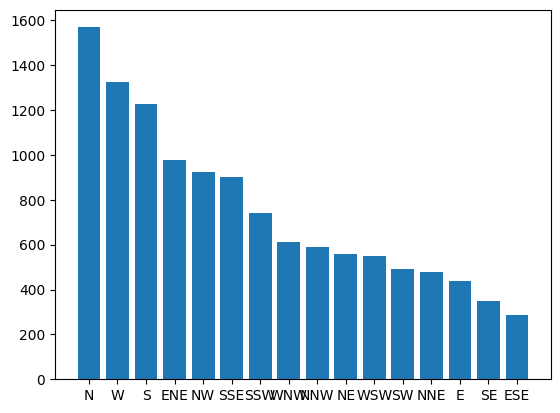

In [36]:
wind_direction_counts = df["WindGustDir"].value_counts()

plt.bar(wind_direction_counts.index, wind_direction_counts.values)
plt.show()

In [37]:
df.Location.sort_values().unique()

array(['Canberra', 'Melbourne', 'MelbourneAirport', 'Sydney',
       'SydneyAirport'], dtype=object)

Hasta el momento utilizamos 4 metodos para rellenar los datos faltantes.
1. Interpolacion: Lo quehace este metodo que es nos rellena el dato faltante con el promedio de el dato de arriba y el del dato de abajo. Si no tiene datos en la fila de arriba o abajo, busca el calor mas ceracano y reemplaza con ese promedio.
2. Funcion de rellenado para las variables discretas donde utilizamos la moda en base a la localidad y la estacion del año.
3. Funcion de rellenado de variables continuas donde utilizamos el promedio en base a la localidad y la estacion del año.
4. (fill missing data) esta funcion completa dependiendo el mes (asi es mas acertivo)

# 2. Visualizaciones

In [38]:
def create_histograms_by_location(df):
    """
    Crea histogramas por cada columna del DataFrame para cada localidad y los muestra uno al lado del otro.

    Args:
    - df: DataFrame de pandas.

    Returns:
    - None (muestra los histogramas uno al lado del otro).
    """
    locations = df['Location'].unique()

    column_names = df.columns.difference(['Location', 'Date'])

    num_locations = len(locations)
    num_columns = len(column_names)
    fig, axes = plt.subplots(num_columns, num_locations, figsize=(5 * num_locations, 5 * num_columns))

    for i, column_name in enumerate(column_names):
        for j, location in enumerate(locations):
            ax = axes[i, j]

            data = df[(df['Location'] == location)][column_name]

            ax.hist(data, bins=20, edgecolor='black')
            ax.set_title(f'Histograma de {column_name} en {location}')
            ax.set_xlabel(column_name)
            ax.set_ylabel('Frecuencia')

    plt.tight_layout()

    plt.show()

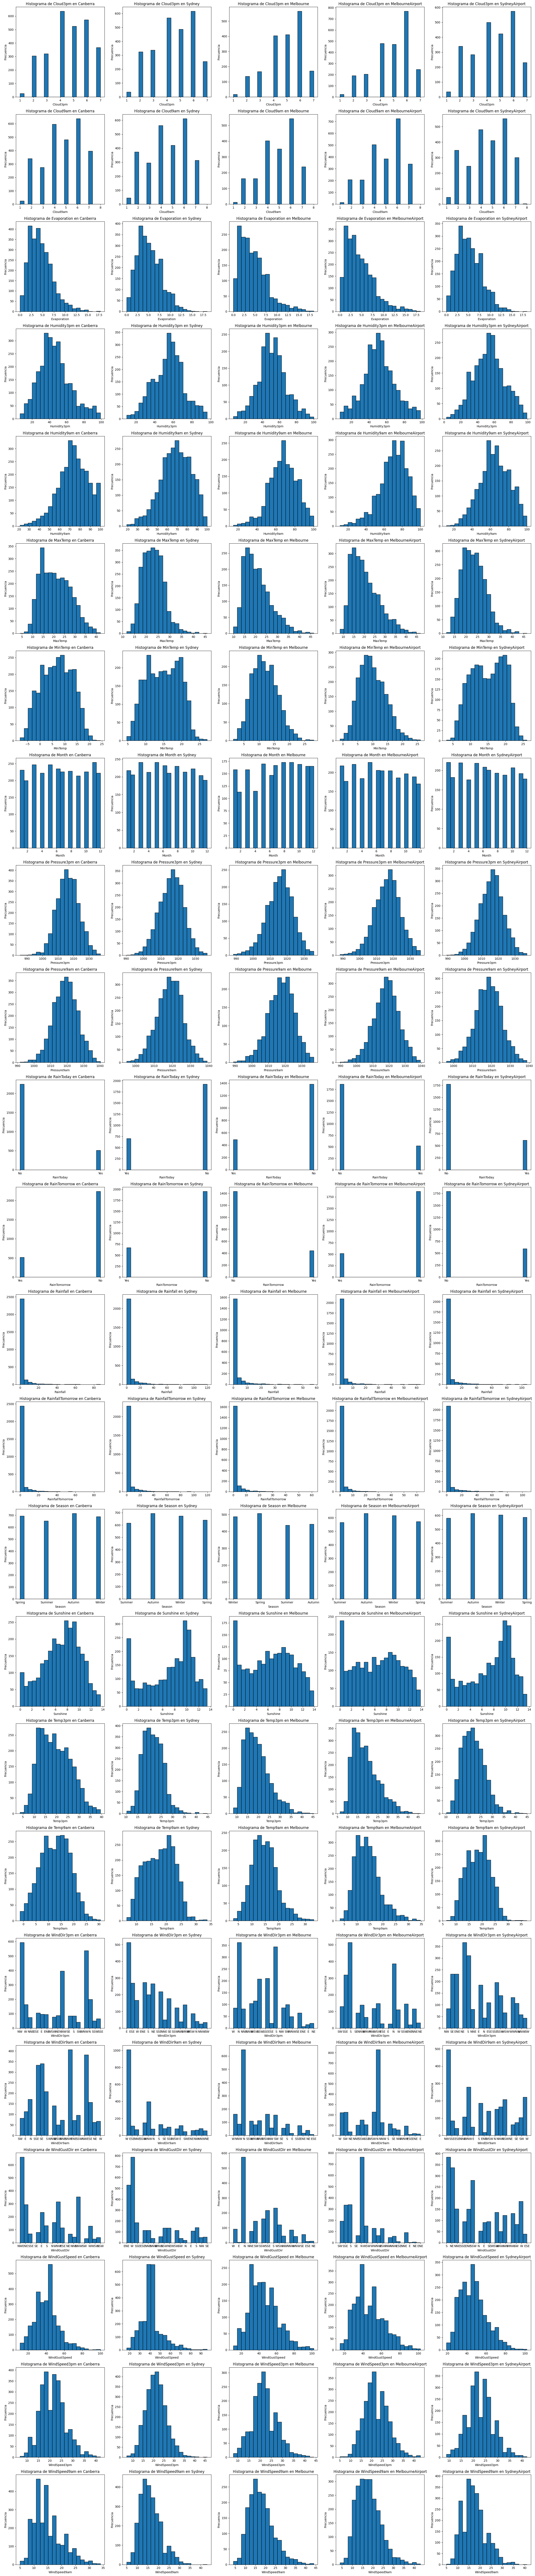

In [39]:
create_histograms_by_location(df)

Vamos a realizar un grafico preguntandonos cuanto llueve (en proporcion) en cada estacion dependiendo de la localidad

In [40]:
lluvia_localidad_estacion=df[["Location","RainfallTomorrow","Season"]]

In [41]:
lluvia_localidad_estacion = lluvia_localidad_estacion.groupby(['Location', 'Season'])['RainfallTomorrow'].sum().reset_index()

In [42]:
lluvia_localidad_estacion

Location  Season  RainfallTomorrow
0           Canberra  Autumn             945.7
1           Canberra  Spring            1448.6
2           Canberra  Summer            1588.6
3           Canberra  Winter            1020.1
4          Melbourne  Autumn             652.0
5          Melbourne  Spring             985.8
6          Melbourne  Summer             500.0
7          Melbourne  Winter             724.2
8   MelbourneAirport  Autumn             671.6
9   MelbourneAirport  Spring            1157.6
10  MelbourneAirport  Summer             777.2
11  MelbourneAirport  Winter             700.4
12            Sydney  Autumn            3034.6
13            Sydney  Spring            1408.2
14            Sydney  Summer            1866.8
15            Sydney  Winter            2412.4
16     SydneyAirport  Autumn            2121.4
17     SydneyAirport  Spring            1121.2
18     SydneyAirport  Summer            1796.8
19     SydneyAirport  Winter            1930.0

In [43]:
suma_total_por_localidad = lluvia_localidad_estacion.groupby('Location')['RainfallTomorrow'].sum().reset_index()
lluvia_localidad_estacion = lluvia_localidad_estacion.merge(suma_total_por_localidad, on='Location', suffixes=('', '_total'))
lluvia_localidad_estacion['Proportion'] = lluvia_localidad_estacion['RainfallTomorrow'] / lluvia_localidad_estacion['RainfallTomorrow_total']
lluvia_localidad_estacion = lluvia_localidad_estacion.drop('RainfallTomorrow_total', axis=1)

lluvia_localidad_estacion

Location  Season  RainfallTomorrow  Proportion
0           Canberra  Autumn             945.7    0.189027
1           Canberra  Spring            1448.6    0.289546
2           Canberra  Summer            1588.6    0.317529
3           Canberra  Winter            1020.1    0.203898
4          Melbourne  Autumn             652.0    0.227813
5          Melbourne  Spring             985.8    0.344444
6          Melbourne  Summer             500.0    0.174703
7          Melbourne  Winter             724.2    0.253040
8   MelbourneAirport  Autumn             671.6    0.203097
9   MelbourneAirport  Spring            1157.6    0.350067
10  MelbourneAirport  Summer             777.2    0.235031
11  MelbourneAirport  Winter             700.4    0.211806
12            Sydney  Autumn            3034.6    0.347925
13            Sydney  Spring            1408.2    0.161454
14            Sydney  Summer            1866.8    0.214033
15            Sydney  Winter            2412.4    0.276588
16     SydneyAirport  Autumn            2121.4    0.304388
17     SydneyAirport  Spring            1121.2    0.160875
18     SydneyAirport  Summer            1796.8    0.257813
19     SydneyAirport  Winter            1930.0    0.276925

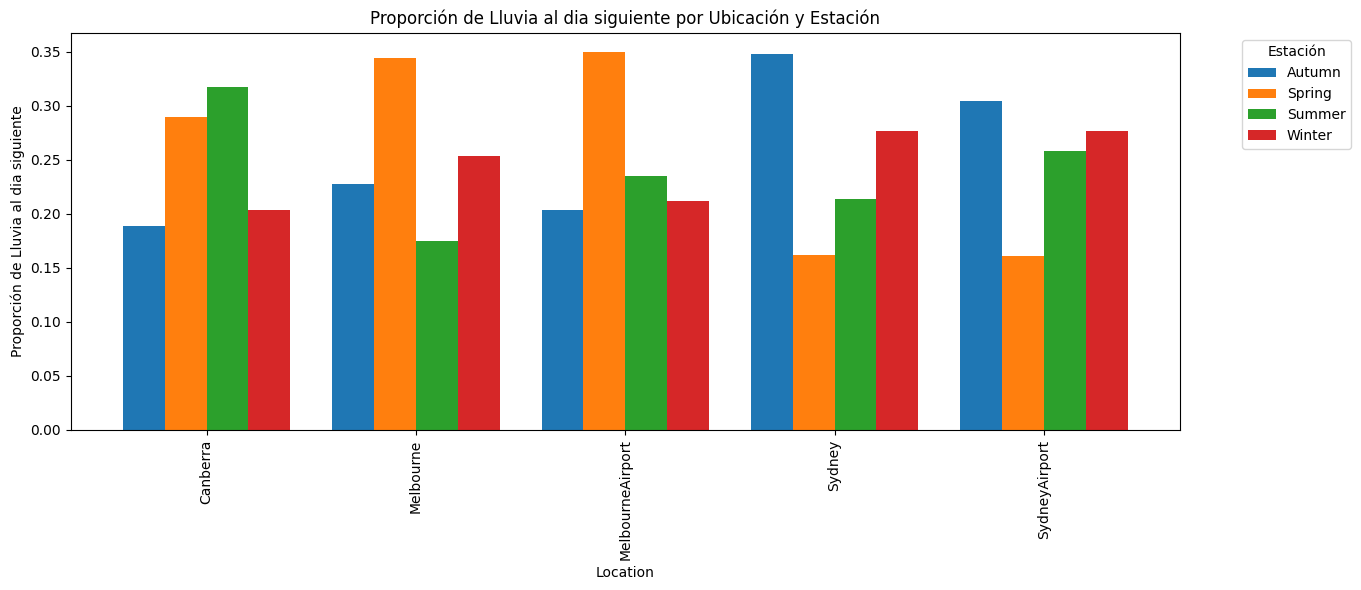

In [44]:
pivoteado = lluvia_localidad_estacion.pivot(index='Location', columns='Season', values='Proportion')
ax = pivoteado.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.xlabel('Location')
plt.ylabel('Proporción de Lluvia al dia siguiente')
plt.title('Proporción de Lluvia al dia siguiente por Ubicación y Estación')
plt.tight_layout()
plt.legend(title='Estación', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Con esto nos damos cuenta que vamos a tener que tener en cuenta la localidad y la estacion a la hora de evaluar de hacer uno o varios modelos predictivos porque lo que sucede es que en cada region es diferente en que estacion del año llueve mas. En Canberra llueve mas en verano mientras que en Melbourne llueve mas en primavera. En la otra vereda en Sydney llueve mas en Otoño.

Vamos a realizar una comparacion de la velocidad del viento dependiendo si llueve o no llueve. Para esto tendremos en cuenta localidad y estacion (al menos a la hora de realizar el df)

In [45]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainfallTomorrow', 'RainTomorrow', 'Month',
       'Season'],
      dtype='object')

In [46]:
lluvia_hoy=df[df["RainTomorrow"]=="Yes"]
lluvia_hoy=lluvia_hoy[["Location","WindGustSpeed","Season"]]
lluvia_hoy=lluvia_hoy.groupby(["Location","Season"])["WindGustSpeed"].mean().reset_index()
lluvia_hoy.rename(columns={"WindGustSpeed":"Wind Speed Rain"},inplace=True)

In [47]:
no_lluvia_hoy=df[df["RainTomorrow"]=="No"]
no_lluvia_hoy=no_lluvia_hoy[["Location","WindGustSpeed","Season"]]
no_lluvia_hoy=no_lluvia_hoy.groupby(["Location","Season"])["WindGustSpeed"].mean().reset_index()
no_lluvia_hoy["Wind Speed Rain"]=lluvia_hoy["Wind Speed Rain"]
no_lluvia_hoy.rename(columns={"WindGustSpeed":"Wind Speed No Rain"},inplace=True)

In [48]:
no_lluvia_hoy

Location  Season  Wind Speed No Rain  Wind Speed Rain
0           Canberra  Autumn           34.889298        42.480769
1           Canberra  Spring           44.338355        48.788599
2           Canberra  Summer           43.160261        46.971944
3           Canberra  Winter           36.089738        42.598379
4          Melbourne  Autumn           38.561047        50.106530
5          Melbourne  Spring           46.555658        54.997812
6          Melbourne  Summer           44.515173        49.117647
7          Melbourne  Winter           42.864797        51.985714
8   MelbourneAirport  Autumn           41.888264        51.971156
9   MelbourneAirport  Spring           47.184167        54.013072
10  MelbourneAirport  Summer           46.208194        54.116279
11  MelbourneAirport  Winter           44.409190        53.823859
12            Sydney  Autumn           37.477839        44.080240
13            Sydney  Spring           43.689077        46.370174
14            Sydney  Summer           42.730668        44.561254
15            Sydney  Winter           39.227193        42.825135
16     SydneyAirport  Autumn           41.704698        50.400000
17     SydneyAirport  Spring           49.374063        51.330827
18     SydneyAirport  Summer           49.703056        52.993561
19     SydneyAirport  Winter           42.554685        48.518470

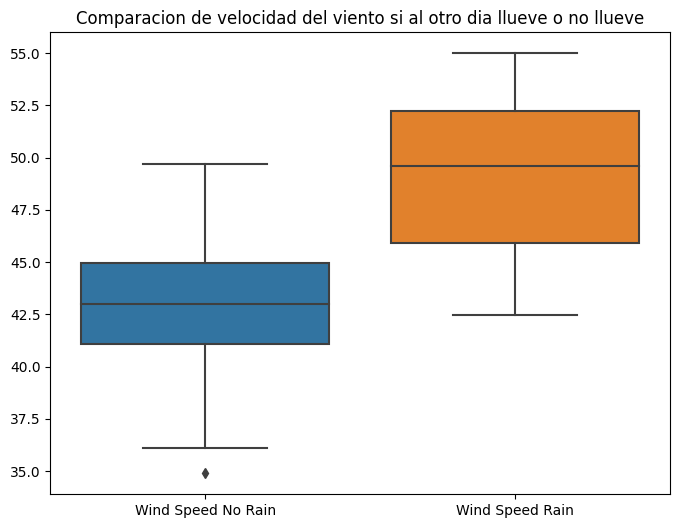

In [49]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=no_lluvia_hoy[['Wind Speed No Rain', 'Wind Speed Rain']])
plt.title('Comparacion de velocidad del viento si al otro dia llueve o no llueve')
plt.show()

Podemos ver que cuando al dia siguiente llueve, la velocidad promedio del viento es mayor a que cuando no llueve.

Ahora vamos a ver la relacion que hay entre la temperatura maxima y cuanto llueve al otro dia dependiendo de la localidad y las estaciones. Entendiendo como hipotesis que si hace mucho calor hoy, mañana deberia llover


In [50]:
temperatura_maxima=df[["Location","Season","MaxTemp","RainTomorrow","RainfallTomorrow"]]

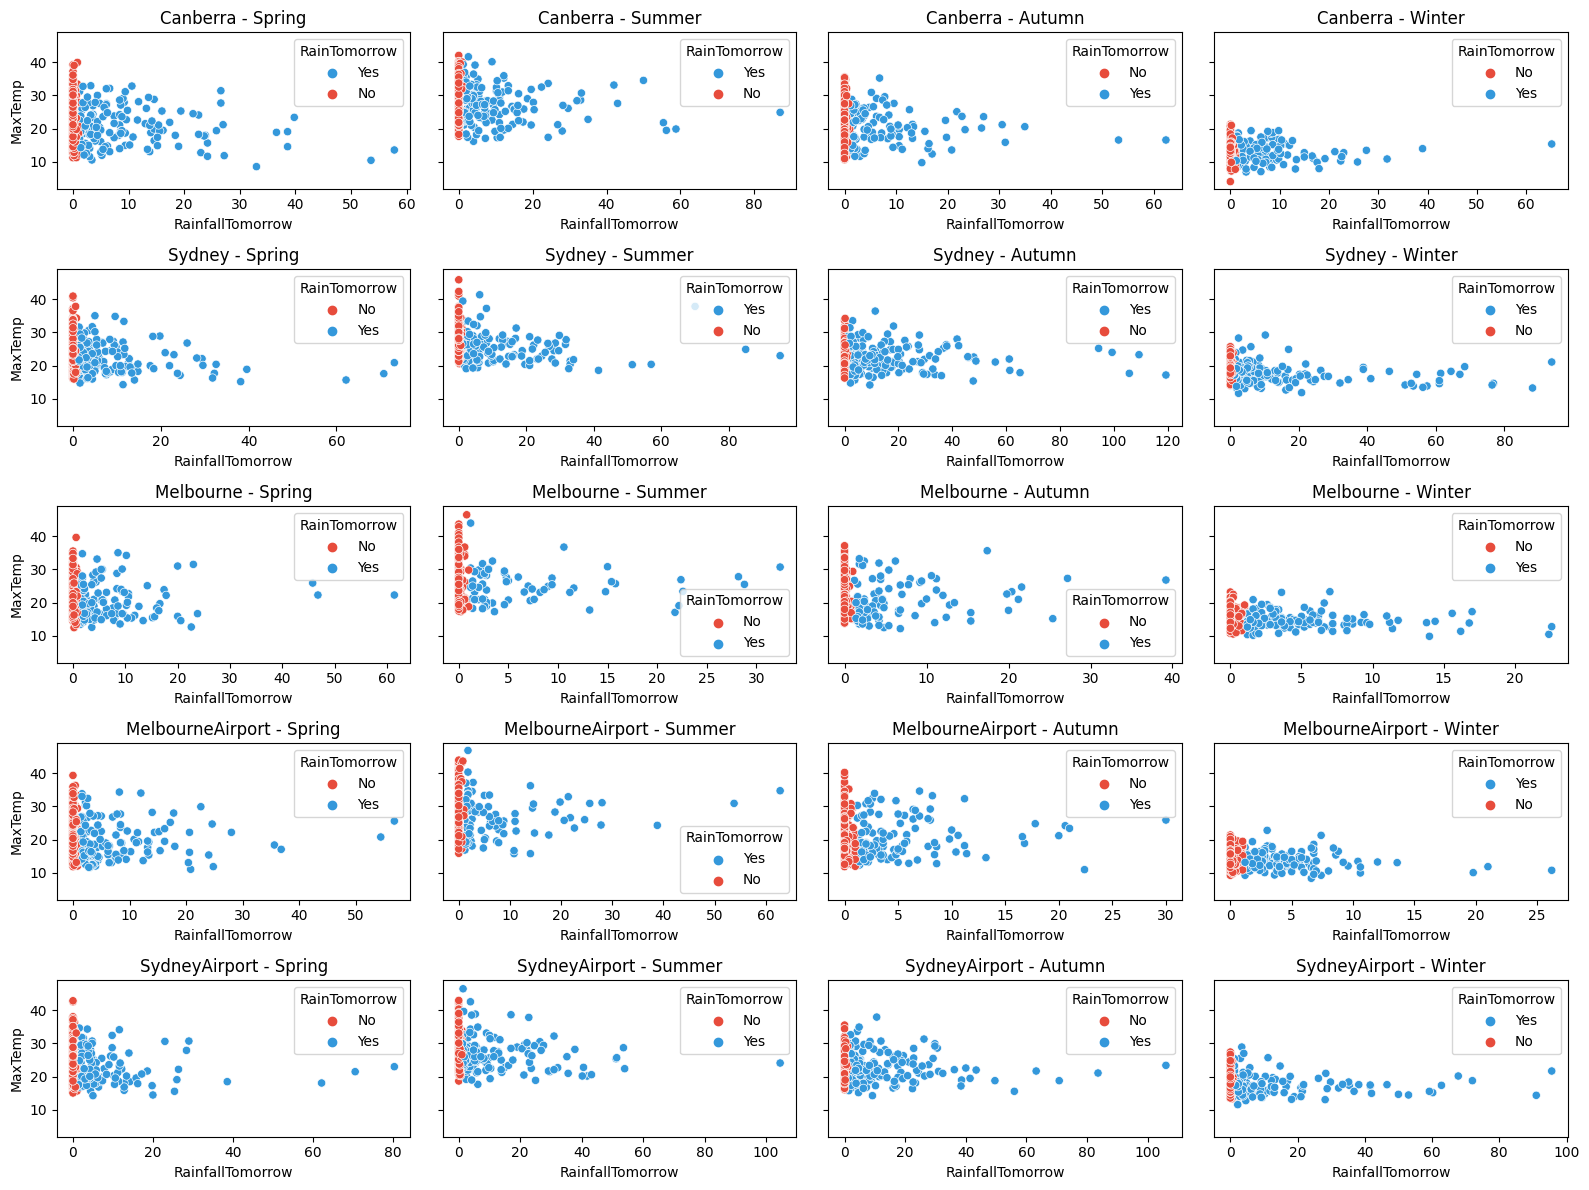

In [51]:
colores = {'Yes': '#3498db', 'No': '#e74c3c'}

ubicaciones = temperatura_maxima['Location'].unique()
estaciones = temperatura_maxima['Season'].unique()

n_filas = len(ubicaciones)
n_columnas = len(estaciones)

fig, axes = plt.subplots(n_filas, n_columnas, figsize=(16, 12), sharey=True)

for i, ubicacion in enumerate(ubicaciones):
    for j, estacion in enumerate(estaciones):
        ax = axes[i, j]
        datos = temperatura_maxima[(temperatura_maxima['Location'] == ubicacion) & (temperatura_maxima['Season'] == estacion)]
        sns.scatterplot(data=datos, x='RainfallTomorrow', y='MaxTemp', hue='RainTomorrow', palette=colores, ax=ax)
        ax.set_title(f'{ubicacion} - {estacion}')
        ax.set_xlabel('RainfallTomorrow')
        ax.set_ylabel('MaxTemp')

plt.tight_layout()
plt.show()


Con la matriz de scatterplots anterior podemos ver como no necesariamente si hace calor un dia al otro va a llover. Para realizar este scatterplot nos parecio necesario separar por estaciones y obviamente por localidades. Algo que nos gustaria destacar es que si bien hay dias donde hace frio y al otro dia llueve, esto podria ser porque muchas veces lo que sucede es que llueve un dia y al otro tambien llueve, vamos a ver en el siguiente grafico acerca de un poco mas de esto

In [52]:
llueve_mañana=df[["RainToday","RainTomorrow"]]
#llueve_mañana=llueve_mañana.groupby(["RainToday","RainTomorrow"]).value_counts().reset_index()
llueve_mañana = llueve_mañana.groupby(["RainToday", "RainTomorrow"]).size().reset_index(name="count")
llueve_mañana.rename(columns={0:"count"},inplace=True)

In [53]:
llueve_mañana

RainToday RainTomorrow  count
0        No           No   7655
1        No          Yes   1534
2       Yes           No   1626
3       Yes          Yes   1206

In [54]:
llueve_hoy_yes=llueve_mañana[llueve_mañana["RainToday"]=="Yes"]
llueve_hoy_yes["Proporcion"]=llueve_hoy_yes["count"]/llueve_hoy_yes["count"].sum()
llueve_hoy_No=llueve_mañana[llueve_mañana["RainToday"]=="No"]
llueve_hoy_No["Proporcion"]=llueve_hoy_No["count"]/llueve_hoy_No["count"].sum()

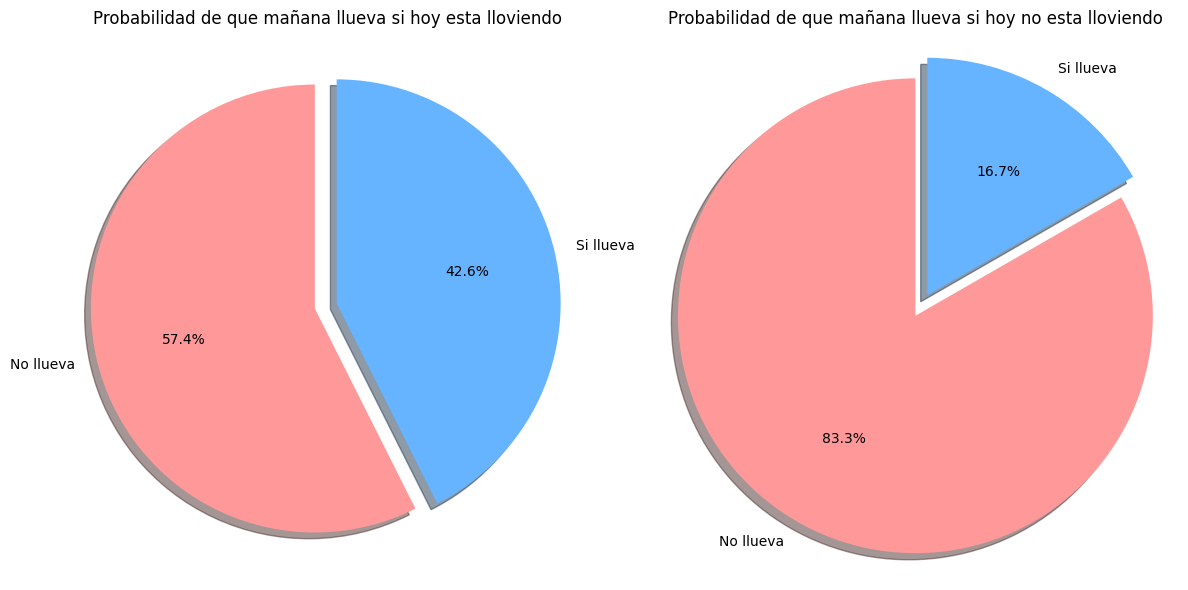

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

labels_yes = 'No llueva', 'Si llueva'
sizes_yes = [llueve_hoy_yes["Proporcion"].iloc[0], llueve_hoy_yes["Proporcion"].iloc[1]]
colors_yes = ['#ff9999', '#66b3ff']
explode_yes = (0.1, 0)

labels_no = 'No llueva', 'Si llueva'
sizes_no = [llueve_hoy_No["Proporcion"].iloc[0], llueve_hoy_No["Proporcion"].iloc[1]]
colors_no = ['#ff9999', '#66b3ff']
explode_no = (0.1, 0)

axes[0].pie(sizes_yes, explode=explode_yes, labels=labels_yes, colors=colors_yes, autopct='%1.1f%%', shadow=True, startangle=90)
axes[0].axis('equal')
axes[0].set_title('Probabilidad de que mañana llueva si hoy esta lloviendo')

axes[1].pie(sizes_no, explode=explode_no, labels=labels_no, colors=colors_no, autopct='%1.1f%%', shadow=True, startangle=90)
axes[1].axis('equal')
axes[1].set_title('Probabilidad de que mañana llueva si hoy no esta lloviendo')

plt.tight_layout()
plt.show()

Con esto podemos confirmar lo dicho anteriormente, si hoy esta lloviendo hay una probabilidade de que mañana continue lloviendo mayor a la que si hoy no esta lloviendo, mañana llueva.

Vamos a ver cuanto llovera mañana en promedio si hoy esta lloviendo  

In [56]:
cant_lluvia=df[["RainfallTomorrow","RainToday","RainTomorrow","Location"]]
cant_lluvia=cant_lluvia[(cant_lluvia["RainToday"]=="Yes")&(cant_lluvia["RainTomorrow"]=="Yes")]
cant_lluvia

RainfallTomorrow RainToday RainTomorrow       Location
45574               3.6       Yes          Yes       Canberra
45575              39.8       Yes          Yes       Canberra
45603               4.2       Yes          Yes       Canberra
45618               1.4       Yes          Yes       Canberra
45622               6.4       Yes          Yes       Canberra
...                 ...       ...          ...            ...
33493               3.4       Yes          Yes         Sydney
36502              15.6       Yes          Yes  SydneyAirport
33494              38.8       Yes          Yes         Sydney
36503               2.4       Yes          Yes  SydneyAirport
33496               1.2       Yes          Yes         Sydney

[1206 rows x 4 columns]

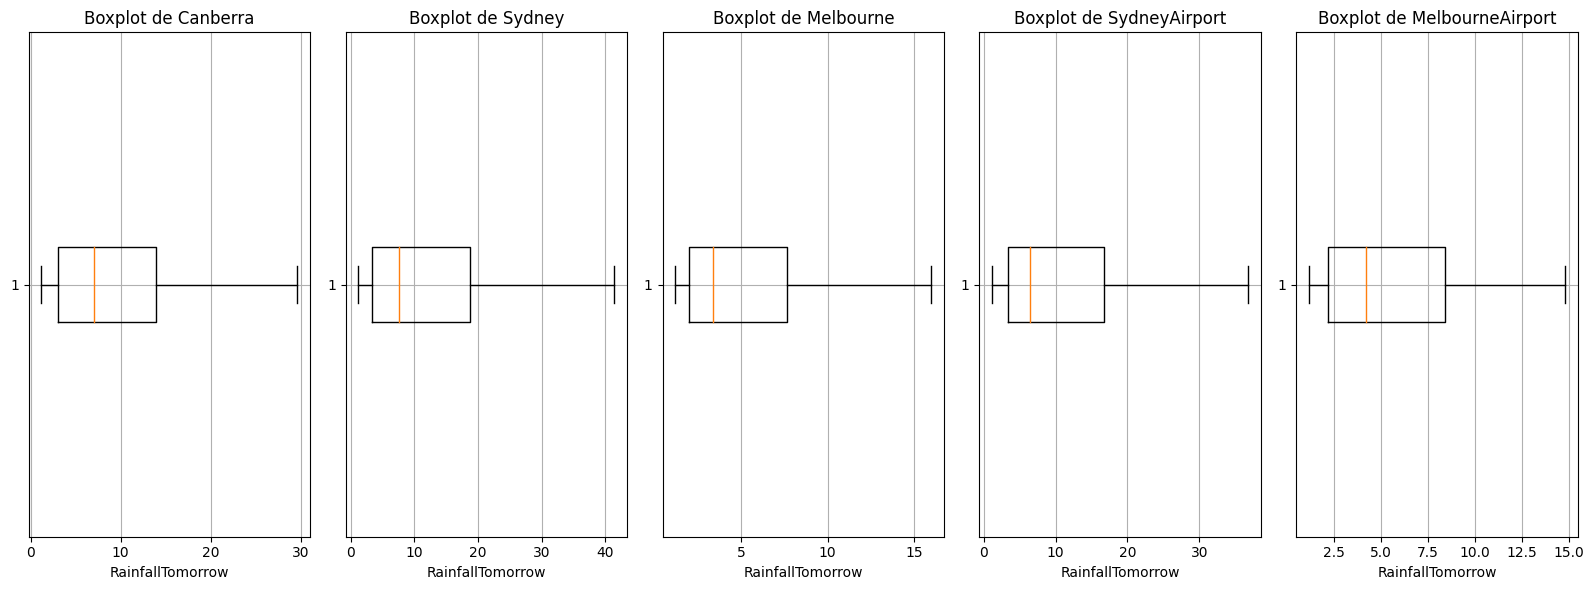

In [57]:
ubicaciones = cant_lluvia['Location'].unique()

plt.figure(figsize=(16, 6))

for i, ubicacion in enumerate(ubicaciones, 1):
    plt.subplot(1, len(ubicaciones), i)
    datos_ubicacion = cant_lluvia[cant_lluvia['Location'] == ubicacion]['RainfallTomorrow']
    plt.boxplot(datos_ubicacion, vert=False, showfliers=False)
    plt.title(f'Boxplot de {ubicacion}')
    plt.xlabel('RainfallTomorrow')
    plt.grid(True)

plt.tight_layout()

plt.show()

Podemos ver como la cantidad de lluvia que caera mañana dependiendo de si hoy llovio en Sydney es mayor que todos los demas lugares mientras que Melbourne es donde menos llueve.

Cual es la direccion del viento que probabilidad hay de que llueva dependiendo del lugar?

In [58]:
viento_lluvia=df[["Location","Season","WindGustDir","RainTomorrow"]]
viento_lluvia=viento_lluvia[viento_lluvia["RainTomorrow"]=="Yes"]
viento_lluvia = viento_lluvia.groupby('Location')['WindGustDir'].value_counts().groupby(level=0, group_keys=False).nlargest(5).reset_index(name='Count')

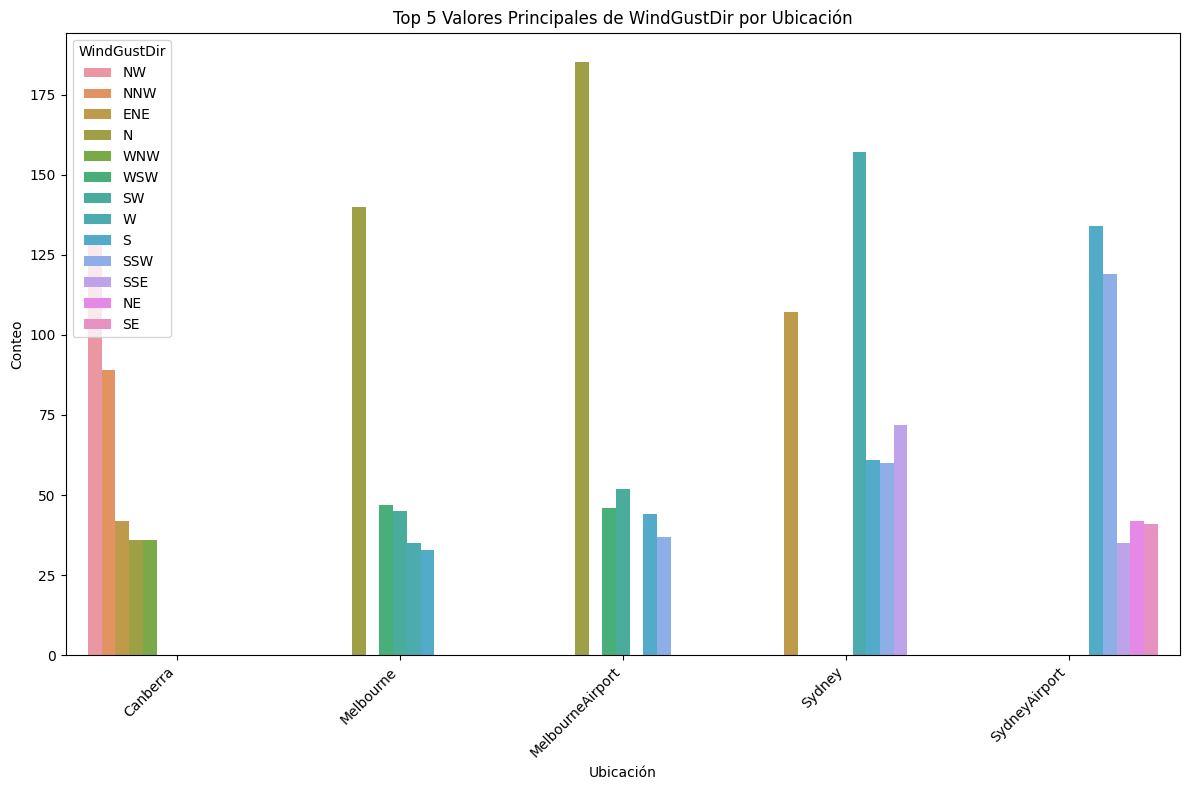

In [59]:
plt.figure(figsize=(12, 8))

sns.barplot(x='Location', y='Count', hue='WindGustDir', data=viento_lluvia)
plt.title('Top 5 Valores Principales de WindGustDir por Ubicación')
plt.xlabel('Ubicación')
plt.ylabel('Conteo')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Bueno podemos ver que de donde viene el viento claramente influye aunque es una realidad tambien que anteriormente decidimos rellenar los valores faltantes con la moda del lugar dependiendo la estacion por lo tanto este grafico claramente puede estar sesgado.

# 3. Codificación de variables categóricas

Para poder utilizar estas variables dentro de nuestros modelos, vamos a tener que transformarlas en dummys. Lo vamos a hacer utilizando la tecnica de One-Hot Encoding que transforma las variables categoricas en  0 (si hay ausencia) y 1 (si hay presencia) y crea columnas en nuestro dataframe

In [60]:
def create_dummy_variables(df, column_name):
    """
    Genera variables dummy para los valores únicos en una columna categórica del DataFrame.

    Args:
    - df: DataFrame de pandas.
    - column_name: Nombre de la columna para la cual se generarán las variables dummy.

    Returns:
    - DataFrame modificado con las variables dummy.
    """
    dummies = pd.get_dummies(df[column_name], prefix=column_name, drop_first=True)

    df = pd.concat([df, dummies], axis=1)

    df.drop(column_name, axis=1, inplace=True)

    return df


In [61]:
df_cp = df.copy()

df_cp = create_dummy_variables(df_cp, 'Location')
df_cp = create_dummy_variables(df_cp, 'Season')
df_cp = create_dummy_variables(df_cp, 'WindGustDir')
df_cp = create_dummy_variables(df_cp, 'WindDir3pm')
df_cp = create_dummy_variables(df_cp, 'WindDir9am')

df_cp['RainToday'] = df_cp['RainToday'].replace({'Yes': 1, 'No': 0})

df_cp['RainTomorrow'] = df_cp['RainTomorrow'].replace({'Yes': 1, 'No': 0})

df_cp.head()

Date  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
45573 2007-11-01      8.0     24.3       0.0          3.4       6.3   
45574 2007-11-02     14.0     26.9       3.6          4.4       9.7   
45575 2007-11-03     13.7     23.4       3.6          5.8       3.3   
45577 2007-11-05      7.6     16.1       2.8          5.6      10.6   
45578 2007-11-06      6.2     16.9       0.0          5.8       8.2   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  ...  \
45573           30.0             9            21         68.0  ...   
45574           39.0             9            15         80.0  ...   
45575           85.0            13            19         82.0  ...   
45577           50.0            20            26         68.0  ...   
45578           44.0            19            24         70.0  ...   

       WindDir9am_NNW  WindDir9am_NW  WindDir9am_S  WindDir9am_SE  \
45573               0              0             0              0   
45574               0              0             0              0   
45575               0              0             0              0   
45577               0              0             0              0   
45578               0              0             0              1   

       WindDir9am_SSE  WindDir9am_SSW  WindDir9am_SW  WindDir9am_W  \
45573               0               0              1             0   
45574               0               0              0             0   
45575               0               0              0             0   
45577               1               0              0             0   
45578               0               0              0             0   

       WindDir9am_WNW  WindDir9am_WSW  
45573               0               0  
45574               0               0  
45575               0               0  
45577               0               0  
45578               0               0  

[5 rows x 73 columns]

In [62]:
test_dataset = create_dummy_variables(test_dataset, 'Location')
test_dataset = create_dummy_variables(test_dataset, 'Season')
test_dataset = create_dummy_variables(test_dataset, 'WindGustDir')
test_dataset = create_dummy_variables(test_dataset, 'WindDir3pm')
test_dataset = create_dummy_variables(test_dataset, 'WindDir9am')

test_dataset['RainToday'] = test_dataset['RainToday'].replace({'Yes': 1, 'No': 0})

test_dataset['RainTomorrow'] = test_dataset['RainTomorrow'].replace({'Yes': 1, 'No': 0})

test_dataset.head()

Date  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
36428 2017-03-27     20.2     28.7       0.0          5.8      11.0   
30576 2009-03-16     16.1     26.8       0.4          6.8      10.8   
45934 2008-10-27      9.0     30.7       0.0          7.6      12.1   
33932 2010-02-27     19.3     29.3       0.4          3.8      11.8   
68547 2012-04-29     11.9     17.9       NaN          4.6       7.7   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  ...  \
36428           50.0          15.0          33.0         76.0  ...   
30576            NaN          17.0          22.0         42.0  ...   
45934           76.0           7.0          50.0         38.0  ...   
33932           46.0          11.0          26.0         65.0  ...   
68547           33.0           9.0          24.0         53.0  ...   

       WindDir9am_NNW  WindDir9am_NW  WindDir9am_S  WindDir9am_SE  \
36428               1              0             0              0   
30576               0              0             0              0   
45934               0              0             0              0   
33932               0              0             0              0   
68547               0              0             0              0   

       WindDir9am_SSE  WindDir9am_SSW  WindDir9am_SW  WindDir9am_W  \
36428               0               0              0             0   
30576               0               0              0             1   
45934               1               0              0             0   
33932               0               0              0             0   
68547               0               0              0             0   

       WindDir9am_WNW  WindDir9am_WSW  
36428               0               0  
30576               0               0  
45934               0               0  
33932               0               0  
68547               0               1  

[5 rows x 73 columns]

# 4. Balanceo Del Dataset


veremos si el dataframe esta balanceado o no. Esto siempre es viendolo con nuestra variable objetivo o sea la que queremos predecir

In [63]:
df_cp["RainTomorrow"].value_counts()

0    9281
1    2740
Name: RainTomorrow, dtype: int64

In [64]:
test_dataset=test_dataset.dropna()

In [65]:
test_dataset['RainTomorrow'] = test_dataset['RainTomorrow'].astype(int)

Claramente el dataframe esta desbalanceado ya que con esto nos va a predecir mejor cuando no llueve que cuando llueve y cuanto llueve. Lo que vamos a ahcer es con la libreria SMOTE realizar un over-sampling y poder balancear el dataframe. Aclaramos que los datos de test no lo vamos a tocar ya que deben ser como los datos "crudos" que le vamos a pasar, por lo que no tiene que tener ningun tratamiento previo 

In [66]:
# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X_train = df_cp.drop(["RainTomorrow", "Date"], axis=1)
y_train = df_cp["RainTomorrow"]

X_test=test_dataset.drop(["RainTomorrow", "Date"], axis=1)
y_test=test_dataset["RainTomorrow"]


# Aplicar SMOTE para el sobremuestreo
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [67]:
y_train.value_counts()

1    9281
0    9281
Name: RainTomorrow, dtype: int64

In [68]:
y_test.value_counts()

0    1587
1     506
Name: RainTomorrow, dtype: int64

In [69]:
train_dataset = pd.concat([X_train, y_train], axis=1)

In [70]:
test_dataset = pd.concat([X_test, y_test], axis=1)

# 5. Matriz de correlación

In [71]:
def correlated_variables(df, target_column, min_correlation=0.04):

    correlations = df.corr()[target_column].drop(target_column)

    filtered_correlations = correlations[correlations.abs() > min_correlation]

    if filtered_correlations.empty:
        print("No se encontraron variables con correlación mayor que el umbral especificado.")
        return {}

    correlated_variables = filtered_correlations.to_dict()

    return correlated_variables

def plot_correlation_graph(correlation_dict, target_column):
    if not correlation_dict:
        print("El diccionario de correlaciones está vacío. No se puede generar un gráfico.")
        return

    correlation_dict.pop(target_column, None)

    sorted_corr_df = pd.DataFrame.from_dict(correlation_dict, orient='index', columns=['Correlation'])
    sorted_corr_df['Correlation'] = sorted_corr_df['Correlation'].abs()

    sorted_corr_df = sorted_corr_df.sort_values(by='Correlation', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=sorted_corr_df.index, y='Correlation', data=sorted_corr_df, palette='viridis')
    plt.title(f'Relación (valor absoluto) entre variables y {target_column}')
    plt.xticks(rotation=90)
    plt.show()

Como tenemos muchos variables, creamos un grafico de barras de correlacion en vez de una matriz

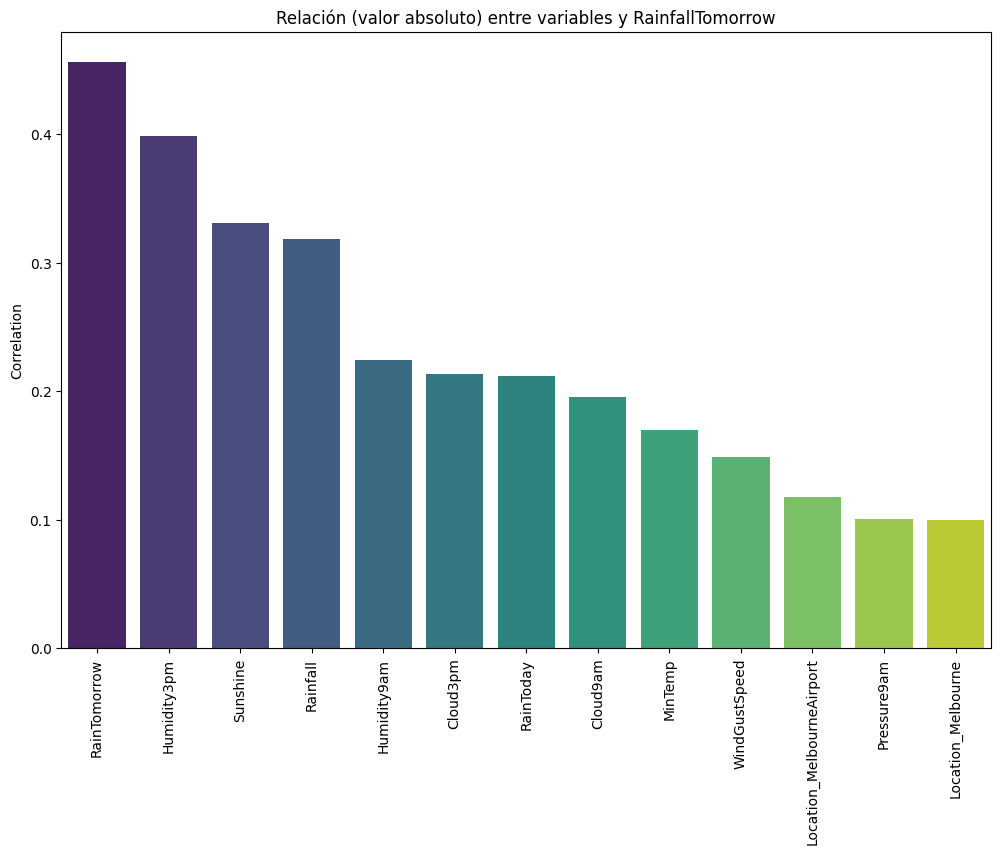

In [72]:
correlated_vars = correlated_variables(train_dataset, 'RainfallTomorrow', 0.1)
plot_correlation_graph(correlated_vars, 'RainfallTomorrow')

Dado el anterior grafico obtenemos que las variables con mas correlacion con RainfallTomorrow son:
*   Humidity3pm
*   Sunshine
*   Rainfall
*   Cloud3pm



# 6. Eleccion de features para nuestro modelo (feature engineering)

En base a todo lo previo que vimos anteriormente, vamos a realizar la seleccion de las caracteristicas de nuestro primer modelo de regresion lineal.

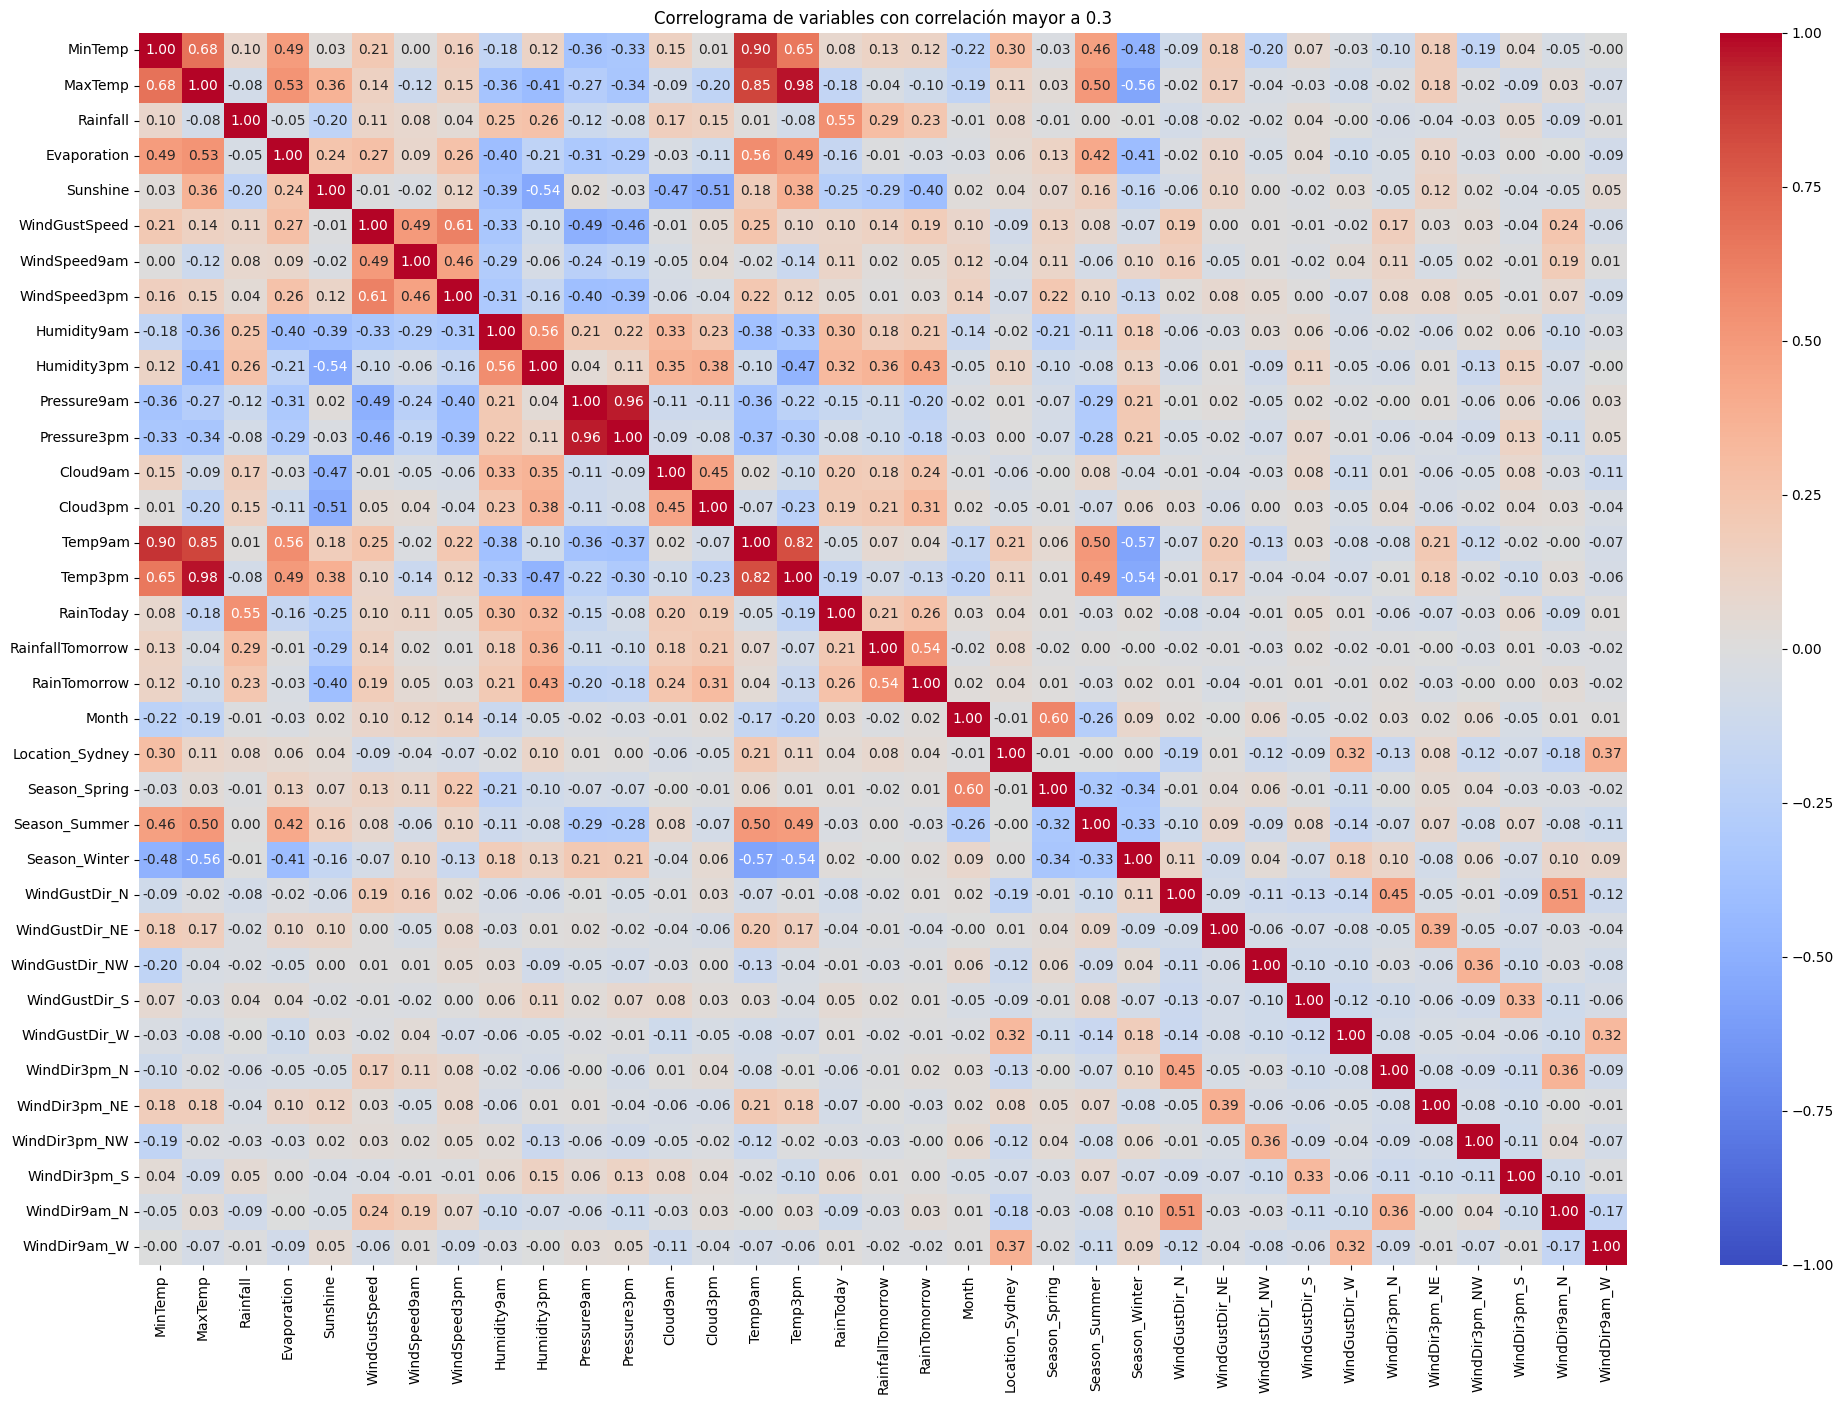

In [73]:
def generate_correlogram(df, threshold = 0.4):
    corr_matrix = df.corr()

    high_corr = (corr_matrix.abs() > threshold) & (corr_matrix != 1)

    mask = high_corr.values

    for i in range(mask.shape[0]):
        mask[i, i] = False

  
    filtered_labels = [label for i, label in enumerate(corr_matrix.columns) if any(mask[i])]

    plt.figure(figsize=(24, 16))
    sns.heatmap(corr_matrix.loc[filtered_labels, filtered_labels], annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlograma de variables con correlación mayor a {threshold}')
    plt.show()

generate_correlogram(df_cp, 0.3)

Podemos apreciar la matriz, si bien es una realidad que nos quedo muy grande, nos va a servir a futuro para algunos modelos

# Regresion Lineal

### Primer modelo:

Para este primer modelo utilizaremos aquellas variables que consideramos utiles. Por eemplo en aquellas variables que tienen 2 horas diferentes del dia solamente utilizaremos las de las 3pm y en temperatura la minima del dia.

In [74]:
primer_modelo = train_dataset[['MinTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed3pm',
       'Humidity3pm', 'Pressure3pm', 'Cloud3pm',
        'Temp3pm', 'RainToday', 'RainfallTomorrow', 'Month',
       'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Sydney',
       'Location_SydneyAirport', 'Season_Spring', 'Season_Summer',
       'Season_Winter']]


X_train_reg1 = primer_modelo[['MinTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed3pm',
       'Humidity3pm', 'Pressure3pm', 'Cloud3pm',
        'Temp3pm', 'RainToday', 'Month',
       'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Sydney',
       'Location_SydneyAirport', 'Season_Spring', 'Season_Summer',
       'Season_Winter']]
y_train_reg1 = primer_modelo['RainfallTomorrow']

In [75]:
X_test_reg1=X_test[['MinTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed3pm',
       'Humidity3pm', 'Pressure3pm', 'Cloud3pm',
        'Temp3pm', 'RainToday', 'Month',
       'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Sydney',
       'Location_SydneyAirport', 'Season_Spring', 'Season_Summer',
       'Season_Winter']]

Y_test_reg1=X_test["RainfallTomorrow"]

In [76]:
# Crear y ajustar el modelo de regresión lineal
reg = LinearRegression()
reg.fit(X_train_reg1, y_train_reg1)

LinearRegression()

In [77]:
y_pred = reg.predict(X_test_reg1)

In [78]:
# Calcular métricas de evaluación

mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio:", mse.round(4))

mae=mean_absolute_error(y_test, y_pred)
print("MAE:",mae.round(4))

reg.score(X_train_reg1,y_train_reg1), reg.score(X_test_reg1,Y_test_reg1)
print(f"""El R² para los datos de entrenamiento es: {reg.score(X_train_reg1,y_train_reg1).round(4)} y para los de testeo: {reg.score(X_test_reg1,Y_test_reg1)}""")

mape = (mae / (y_test)).mean() * 100
print("MAPE:",mape.round(4))

Error cuadrático medio: 21.815
MAE: 3.4932
El R² para los datos de entrenamiento es: 0.2753 y para los de testeo: 0.1230000567792987
MAPE: inf


Como podemos ver, nuestro primer modelo que tiene una buena aproximacion para los datos de test, por lo que vamos a seguir en busqueda. La metrica que nosotros usamos para la comparacion de modelos en el R2 en test.

### Segundo modelo:

Para este segundo modelo utilizaremos las variables cuya correlacion es mayor a 0.2, paea esto utilizamos la funcion correlated_variables para obtener una lista de las mismas

In [87]:
selected_features = list(correlated_variables(X_test, 'RainfallTomorrow', 0.2).keys())

tercer_modelo = X_test[selected_features + ['RainfallTomorrow']]

columnas_numericas = tercer_modelo.select_dtypes(include=['float64']).columns.tolist()

scaler1 = StandardScaler()

tercer_modelo[columnas_numericas] = scaler1.fit_transform(X_test[columnas_numericas])

X_train_reg2 = tercer_modelo[selected_features]
y_train_reg2 = tercer_modelo[['RainfallTomorrow']]

In [89]:
X_test_reg2=X_test[selected_features]
y_test_reg2=X_test["RainfallTomorrow"]
scaler = StandardScaler()
X_test_reg2=scaler.fit_transform(X_test_reg2)
y_test_reg2=scaler.transform(y_test_reg2.to_numpy().reshape(-1,1))

In [90]:
reg2 = LinearRegression()
reg2.fit(X_train_reg2, y_train_reg2)

LinearRegression()

In [91]:
y_pred_reg2 = reg2.predict(X_test_reg2)

In [92]:
mse = mean_squared_error(y_test_reg2, y_pred_reg2)
print("Error cuadrático medio:", mse.round(4))

mae=mean_absolute_error(y_test_reg2, y_pred_reg2)
print("MAE:",mae.round(4))

reg2.score(X_train_reg2,y_train_reg2), reg2.score(X_test_reg2,y_test_reg2)
print(f"El R² para los datos de entrenamiento es: {reg2.score(X_train_reg2,y_train_reg2)} y para los de testeo: { reg2.score(X_test_reg2,y_test_reg2).round(4)}")

mape = (mae / (y_test_reg2)).mean() * 100
print("MAPE:",mape.round(4))

Error cuadrático medio: 0.8933
MAE: 0.4518
El R² para los datos de entrenamiento es: 0.10668409327343809 y para los de testeo: 0.1067
MAPE: -170.5657


Este modelo da metricas aun peores que el primer modelo.

### Tercer modelo

Para este tercer modelo utilizamos todas las variables

In [93]:
X_train_reg3 = X_train.drop('RainfallTomorrow', axis=1)
y_train_reg3 = X_train['RainfallTomorrow']

In [94]:
X_test_reg3=X_test.drop('RainfallTomorrow', axis=1)
y_test_reg3=X_test["RainfallTomorrow"]

In [95]:
reg3 = LinearRegression()
reg3.fit(X_train_reg3, y_train_reg3)

LinearRegression()

In [96]:
y_pred_reg3 = reg3.predict(X_test_reg3)

print("Predicciones: {}, Valores actuales: {}".format(y_pred[:5], y_test_reg3[:5]))

Predicciones: [ 6.01589829  0.58444786  2.09196811 16.81637419  7.62718069], Valores actuales: 36428     0.0
45934     0.0
33932     0.0
68485    25.6
35810     1.2
Name: RainfallTomorrow, dtype: float64


Obtenemos el Error Cuadratico Medio (Mean Squared Error): Esta metrica mide el promedio de los cuadrados de las diferencias entre los valores reales y las predicciones del modelo

In [97]:
mse = mean_squared_error(y_test_reg3, y_pred_reg3)
print("Error cuadrático medio:", mse.round(4))

Error cuadrático medio: 38.6003


Calculamos el Error Absoluto Medio (Mean Absolute Error) es similar al MSE pero en vez de elevar al cuadrado, toma el valor absoluto de las diferencias entre los valores reales y las predicciones

In [98]:
mae=mean_absolute_error(y_test_reg3, y_pred_reg3)
print("MAE:",mae.round(4))

MAE: 3.4446


Ahora obtenemos el Coeficiente de determinacion R². Este se utiliza para calcular la puntuacion de precision del modelo en un conjunto de datos. La puntuacion suele representar que tan bien se ajusta el modelo a los datos reales.


*   R² =1 El modelo explica perfectamente toda la variabilidad en la variable dependiente
*   R² = 0: El modelo no explica nada de la variabilidad en la variable dependiente.

Lo hacemos para los datos de testeo y entrenamiento

In [99]:
reg3.score(X_train_reg3,y_train_reg3), reg3.score(X_test_reg3,y_test_reg3)
print(f"El R² para los datos de entrenamiento es: {reg3.score(X_train_reg3,y_train_reg3).round(4)} y para los de testeo: {reg3.score(X_test_reg3,y_test_reg3).round(4)}")

El R² para los datos de entrenamiento es: 0.2965 y para los de testeo: 0.1541


El MAPE mide el porcentaje promedio de error en las predicciones en relación con los valores reales. Cuanto menor sea el MAPE, mejor será el modelo de predicción.

In [100]:
mape = (mae / (y_test_reg3)).mean() * 100
print("MAPE:",mape.round(4))

MAPE: inf


RMSE (Error Cuadrático Medio de la Raíz):

El RMSE mide la raíz cuadrada del error cuadrático promedio entre las predicciones y los valores reales. Cuanto menor sea el RMSE, mejor será el modelo

In [101]:
rmse = np.sqrt(mse)
print("RMSE:",rmse.round(4))

RMSE: 6.2129


En cuanto a Regresiones Lineales sin regularizaciones, nos vamos a quedar con el tercer modelo.

# Metodos de regularizacion

definimos los metodos que vamos a usar: Lasso, Ridge y ElasticNet

In [240]:
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=0.1)
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)

## Lasso

In [241]:
lasso.fit(X_train_reg3,y_train_reg3)

Lasso(alpha=0.1)

In [242]:
lasso.score(X_train_reg3,y_train_reg3)

0.2760742089029198

In [243]:
y_pred_lasso = lasso.predict(X_test_reg3)

mae = mean_absolute_error(y_test_reg3, y_pred_lasso)
mse = mean_squared_error(y_test_reg3, y_pred_lasso)
rmse = np.sqrt(mse)
mape = (mae / y_test_reg3).mean() * 100

print("MAE:", mae.round(4))
print("MSE:", mse.round(4))
print("RMSE:",rmse.round(4))
print("MAPE:",mape.round(4))
print(lasso.score(X_test_reg3,y_test_reg3).round(4),lasso.score(X_train_reg3,y_train_reg3).round(4))
print("Predicciones: {}, Valores actuales: {}".format(y_pred_lasso[:5], y_test_reg3[:5]))

MAE: 3.6723
MSE: 39.9511
RMSE: 6.3207
MAPE: inf
0.1245 0.2761
Predicciones: [ 6.70830203  0.67649205  3.03017051 17.14897483  7.13398447], Valores actuales: 36428     0.0
45934     0.0
33932     0.0
68485    25.6
35810     1.2
Name: RainfallTomorrow, dtype: float64


## Ridge

In [244]:
ridge.fit(X_train_reg3,y_train_reg3)

Ridge(alpha=0.1)

In [245]:
ridge.score(X_train_reg3,y_train_reg3)

0.2965489709005392

In [246]:
y_pred_ridge = ridge.predict(X_test_reg3)

mae = mean_absolute_error(y_test_reg3, y_pred_ridge)
mse = mean_squared_error(y_test_reg3, y_pred_ridge)
rmse = np.sqrt(mse)
mape = (mae / y_test_reg3).mean() * 100

print("MAE:", mae.round(4))
print("MSE:", mse.round(4))
print("RMSE:",rmse.round(4))
print("MAPE:",mape.round(4))
print(ridge.score(X_test_reg3,y_test_reg3).round(4),ridge.score(X_train_reg3,y_train_reg3).round(4))
print("Predicciones: {}, Valores actuales: {}".format(y_pred_ridge[:5], y_test_reg3[:5]))

MAE: 3.4446
MSE: 38.6002
RMSE: 6.2129
MAPE: inf
0.1541 0.2965
Predicciones: [ 3.83996779  1.20042725  0.40942262 14.45578712  7.43913245], Valores actuales: 36428     0.0
45934     0.0
33932     0.0
68485    25.6
35810     1.2
Name: RainfallTomorrow, dtype: float64


## ElasticNet

In [247]:
elasticnet.fit(X_train_reg3,y_train_reg3)

ElasticNet(alpha=0.1)

In [248]:
elasticnet.score(X_train_reg3,y_train_reg3)

0.2789971192253582

In [249]:
y_pred_elasticnet = elasticnet.predict(X_test_reg3)

mae = mean_absolute_error(y_test_reg3, y_pred_elasticnet)
mse = mean_squared_error(y_test_reg3, y_pred_elasticnet)
rmse = np.sqrt(mse)
mape = (mae / y_test_reg3).mean() * 100

print("MAE:", mae.round(4))
print("MSE:", mse.round(4))
print("RMSE:",rmse.round(4))
print("MAPE:",mape.round(4))
print(elasticnet.score(X_test_reg3,y_test_reg3).round(4),elasticnet.score(X_train_reg3,y_train_reg3).round(4))
print("Predicciones: {}, Valores actuales: {}".format(y_pred_elasticnet[:5], y_test_reg3[:5]))

MAE: 3.6549
MSE: 39.8192
RMSE: 6.3102
MAPE: inf
0.1273 0.279
Predicciones: [ 6.36867364  0.96651142  2.78963936 16.66922406  7.23313803], Valores actuales: 36428     0.0
45934     0.0
33932     0.0
68485    25.6
35810     1.2
Name: RainfallTomorrow, dtype: float64


# Gradiente descendiente

In [102]:
def gradient_descent(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray,
                     y_test: np.ndarray, theta: np.ndarray, learning_rate: float,
                     num_iterations: int) -> (np.ndarray, list, list):
    N_train = len(y_train)
    N_test = len(y_test)
    train_errors = []
    test_errors = []

    for epoch in range(num_iterations):
        y_hat_train = X_train.dot(theta)
        gradient = (-2 / N_train) * X_train.T.dot(y_train - y_hat_train)
        theta -= learning_rate * gradient

        train_error = np.mean((y_train - y_hat_train) ** 2)
        train_errors.append(train_error)

        y_hat_test = X_test.dot(theta)
        test_error = np.mean((y_test - y_hat_test) ** 2)
        test_errors.append(test_error)

    return theta, train_errors, test_errors


In [103]:
#X_train, y_train escalado para descenso del gradiente
df_gradient = X_train[['MinTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed3pm',
       'Humidity3pm', 'Pressure3pm', 'Cloud3pm',
        'Temp3pm', 'RainToday', 'Month',
       'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Sydney',
       'Location_SydneyAirport', 'Season_Spring', 'Season_Summer',
       'Season_Winter'] + ['RainfallTomorrow']]

columnas_numericas = df_gradient.select_dtypes(include=['float64']).columns.tolist()

scaler2 = StandardScaler()

df_gradient[columnas_numericas] = scaler2.fit_transform(X_train[columnas_numericas])

X_train_dg = df_gradient.drop(columns=['RainfallTomorrow'])
y_train_dg = df_gradient['RainfallTomorrow']



In [105]:
#X_test,y_test escaldo para descenso del graidente
df_gradient = X_test[['MinTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed3pm',
       'Humidity3pm', 'Pressure3pm', 'Cloud3pm',
        'Temp3pm', 'RainToday', 'Month',
       'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Sydney',
       'Location_SydneyAirport', 'Season_Spring', 'Season_Summer',
       'Season_Winter'] + ['RainfallTomorrow']]

columnas_numericas = df_gradient.select_dtypes(include=['float64']).columns.tolist()

df_gradient[columnas_numericas] = scaler2.transform(X_test[columnas_numericas])

X_test_dg = df_gradient.drop(columns=['RainfallTomorrow'])
y_test_dg = df_gradient['RainfallTomorrow']

In [106]:
scaler3 = StandardScaler()
X_train_dg = scaler3.fit_transform(X_train_dg)
X_test_dg = scaler3.transform(X_test_dg)


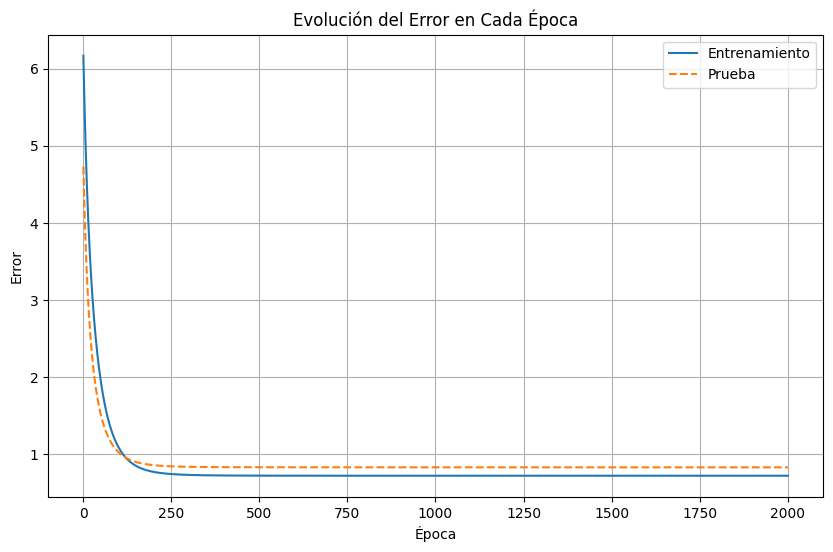

In [107]:

learning_rate = 0.01
num_iterations = 2000

theta_inicial = np.random.rand(X_train_dg.shape[1])

theta_optimo, train_errors, test_errors = gradient_descent(X_train_dg, y_train_dg, X_test_dg, y_test_dg, theta_inicial, learning_rate, num_iterations)

epocas = list(range(1, num_iterations + 1))

plt.figure(figsize=(10, 6))
plt.plot(epocas, train_errors, label='Entrenamiento',  linestyle='-')
plt.plot(epocas, test_errors, label='Prueba',  linestyle='--')
plt.title('Evolución del Error en Cada Época')
plt.xlabel('Época')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

In [108]:
# Realizar predicciones en el conjunto de entrenamiento y prueba
y_train_pred_dg = X_train_dg.dot(theta_optimo)
y_test_pred_dg = X_test_dg.dot(theta_optimo)

# Calcular R2 Score
r2_train = r2_score(y_train_dg, y_train_pred_dg)
r2_test = r2_score(y_test_dg, y_test_pred_dg)

# Calcular MSE
mse_train = mean_squared_error(y_train_dg, y_train_pred_dg)
mse_test = mean_squared_error(y_test_dg, y_test_pred_dg)

# Calcular RMSE
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Calcular MAE
mae_train = mean_absolute_error(y_train_dg, y_train_pred_dg)
mae_test = mean_absolute_error(y_test_dg, y_test_pred_dg)

# Calcular MAPE
mape_train = np.mean(np.abs((y_train_dg - y_train_pred_dg) / y_train_dg)) * 100
mape_test = np.mean(np.abs((y_test_dg - y_test_pred_dg) / y_test_dg)) * 100

# Imprimir las métricas
print(f'R2 Score en entrenamiento: {r2_train.round(4)}, en prueba: {r2_test.round(4)}')
print(f'MSE en entrenamiento: {mse_train.round(4)}, en prueba: {mse_test.round(4)}')
print(f'RMSE en entrenamiento: {rmse_train.round(4)}, en prueba: {rmse_test.round(4)}')
print(f'MAE en entrenamiento: {mae_train.round(4)}, en prueba: {mae_test.round(4)}')
print(f'MAPE en entrenamiento: {mape_train.round(4)}%, en prueba: {mape_test.round(4)}%')

R2 Score en entrenamiento: 0.2753, en prueba: 0.1666
MSE en entrenamiento: 0.7247, en prueba: 0.8334
RMSE en entrenamiento: 0.8513, en prueba: 0.9129
MAE en entrenamiento: 0.4699, en prueba: 0.4533
MAPE en entrenamiento: 330.7735%, en prueba: 200.8329%


# Regresion Logistica

## Primer Modelo

Vamos a realizar el primer modelo de Regresion Logistica para clasificacion. La idea de este modelo es intentar predecir si llovera mañana.

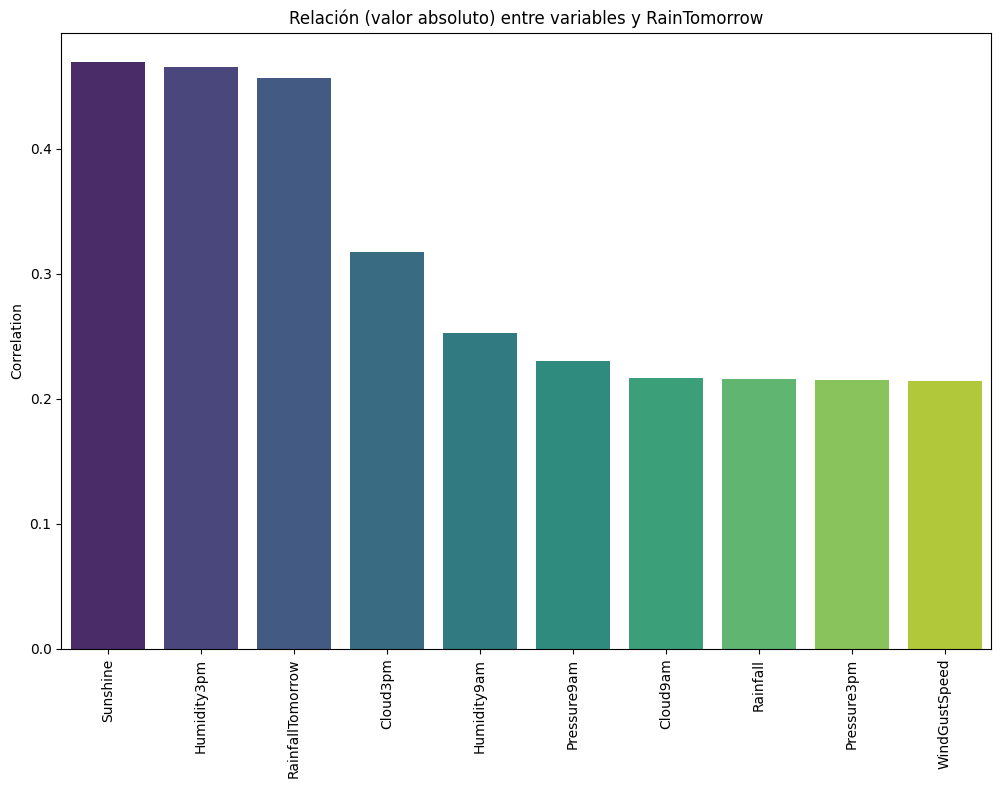

In [266]:
correlated_vars = correlated_variables(train_dataset, 'RainTomorrow', 0.2)
plot_correlation_graph(correlated_vars, 'RainTomorrow')

In [267]:
X_train_log1 = X_train[['Rainfall','Sunshine','WindGustSpeed','Humidity3pm', 'Pressure9am', 'Cloud9am','RainToday']]
y_train_log1 = y_train
X_test_log1=X_test[['Rainfall','Sunshine','WindGustSpeed','Humidity3pm', 'Pressure9am', 'Cloud9am','RainToday']]
y_test_log1=y_test

In [268]:
# Inicializar y entrenar un modelo de regresión logística
log1 = LogisticRegression(random_state=42)
log1.fit(X_train_log1, y_train_log1)

# Realizar predicciones en el conjunto de prueba
y_pred_log1 = log1.predict(X_test_log1)

In [269]:
print("Predicciones: {}, Valores actuales: {}".format(y_pred_log1[:5], y_test_log1[:5]))

Predicciones: [0 0 0 1 1], Valores actuales: 36428    0
45934    0
33932    0
68485    1
35810    1
Name: RainTomorrow, dtype: int32


In [270]:
y_probs_log1 = log1.predict_proba(X_test_log1)[:, 1]

In [271]:
fpr_log1, tpr_log1, thresholds_log1 = roc_curve(y_test_log1, y_probs_log1)
roc_auc_log1 = auc(fpr_log1, tpr_log1)

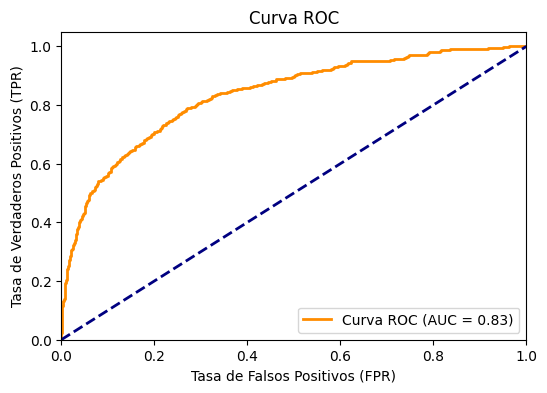

In [272]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_log1, tpr_log1, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_log1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Accuracy

Representa la cantidad de aciertos del modelo respecto del total de datos.

Es una buena métrica para problemas cuyos dataset están balanceados.

In [273]:
precision_log1 = accuracy_score(y_test_log1, y_pred_log1)
print("Precisión del modelo:", precision_log1.round(4))

Precisión del modelo: 0.7573


Con la metrica de accuracy vamos a medir los modelos de clasificacion para determinar cual es el mejor.

Recall

Representa, dentro de la misma clase, cuántas fueron correctamente clasificadas. El recall mide la capacidad del modelo para identificar todos los casos positivos en el conjunto de datos.

Donde:

1. Verdaderos Positivos (TP) son los casos en los que el modelo predijo correctamente la clase positiva.
2. Falsos Negativos (FN) son los casos en los que el modelo predijo incorrectamente la clase negativa cuando la verdadera clase era positiva.


In [274]:
recall_p_log1 = recall_score(y_test_log1, y_pred_log1,pos_label=1)
print("Recall del modelo para la clase positiva:", recall_p_log1.round(4))

Recall del modelo para la clase positiva: 0.749


In [275]:
recall_n_log1 = recall_score(y_test_log1, y_pred_log1,pos_label=0)
print("Recall del modelo para la clase negativa:", recall_n_log1.round(4))

Recall del modelo para la clase negativa: 0.7599


Precision

De las clases que se han clasificado como positivas, indica cuántas realmente lo son.

A menores falsos positivos, mayor la precisión.


In [276]:
precision_p_log1 = precision_score(y_test_log1, y_pred_log1, pos_label=1)
print("Precisión para la clase positiva:", precision_p_log1.round(4))

Precisión para la clase positiva: 0.4987


In [277]:
precision_n_log1 = precision_score(y_test_log1, y_pred_log1, pos_label=0)
print("Precisión para la clase negativa:", precision_n_log1.round(4))

Precisión para la clase negativa: 0.9047


F1 Score

Podría ser bueno considerar una métrica que tenga en cuenta tanto la precisión como el recall.

Se utiliza una media armónica

F1 = 2 * ((recall * precision)/(recall + precision))

In [278]:
f1_p_log1 = f1_score(y_test_log1, y_pred_log1,pos_label=1)
print("Puntaje F1 para la clase positiva:", f1_p_log1.round(4))

Puntaje F1 para la clase positiva: 0.5987


In [279]:
f1_n_log1 = f1_score(y_test_log1, y_pred_log1,pos_label=0)
print("Puntaje F1 para la clase negativa:", f1_n_log1.round(4))

Puntaje F1 para la clase negativa: 0.826


Area Under Curve

Mientras más cercano esté a 1, implica que la curva ROC está más cerca de contener al punto (0,1).

Si es 0.5, el modelo es tan malo como predecir random.


In [280]:
auc_score_log1 = roc_auc_score(y_test_log1, y_probs_log1)
print("AUC (Área bajo la Curva ROC):", auc_score_log1.round(4))

AUC (Área bajo la Curva ROC): 0.8338


## Segundo modelo

In [109]:
selected_features_log2 = list(correlated_variables(df_cp, 'RainTomorrow', 0.05).keys())

In [110]:
selected_features_log2 = [columna for columna in selected_features if columna != 'RainfallTomorrow']

In [111]:
regresion_log = train_dataset[selected_features_log2 + ['RainTomorrow']]

columnas_numericas = regresion_log.select_dtypes(include=['float64']).columns.tolist()

scaler4 = StandardScaler()

regresion_log[columnas_numericas] = scaler4.fit_transform(train_dataset[columnas_numericas])

X_train_log2 = regresion_log[selected_features_log2]
y_train_log2 = regresion_log['RainTomorrow']


In [113]:
regresion_log = test_dataset[selected_features_log2 + ['RainTomorrow']]

columnas_numericas = regresion_log.select_dtypes(include=['float64']).columns.tolist()

regresion_log[columnas_numericas] = scaler4.transform(test_dataset[columnas_numericas])

X_test_log2 = regresion_log[selected_features_log2]
y_test_log2 = regresion_log['RainTomorrow']

In [114]:
model_log_2 = LogisticRegression(random_state=42)
model_log_2.fit(X_train_log2, y_train_log2)

# Realizar predicciones en el conjunto de prueba
y_pred_log2 = model_log_2.predict(X_test_log2)

In [115]:
y_probs_log2 = model_log_2.predict_proba(X_test_log2)[:, 1]

In [116]:
fpr_log2, tpr_log2, thresholds_log2 = roc_curve(y_test_log2, y_probs_log2)
roc_auc_log2 = auc(fpr_log2, tpr_log2)

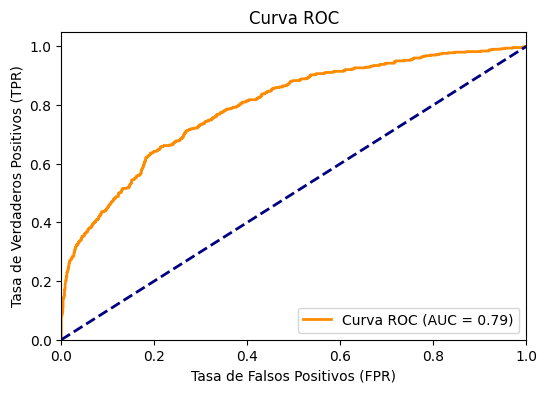

In [117]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_log2, tpr_log2, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_log2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [118]:
precision_log2 = accuracy_score(y_test_log2, y_pred_log2)
print("Precisión del modelo:", precision_log2.round(4))

Precisión del modelo: 0.7549


In [119]:
recall_p_log2 = recall_score(y_test_log2, y_pred_log2,pos_label=1)
print("Recall del modelo para la clase positiva:", recall_p_log2.round(4))

Recall del modelo para la clase positiva: 0.6561


In [120]:
recall_n_log2 = recall_score(y_test_log2, y_pred_log2,pos_label=0)
print("Recall del modelo para la clase negativa:", recall_n_log2.round(4))

Recall del modelo para la clase negativa: 0.7864


In [121]:
precision_p_log2 = precision_score(y_test_log2, y_pred_log2, pos_label=1)
print("Precisión para la clase positiva:", precision_p_log2.round(4))

Precisión para la clase positiva: 0.4948


In [122]:
precision_n_log2 = precision_score(y_test_log2, y_pred_log2, pos_label=0)
print("Precisión para la clase negativa:", precision_n_log2.round(4))

Precisión para la clase negativa: 0.8776


In [123]:
f1_p_log2 = f1_score(y_test_log2, y_pred_log2,pos_label=1)
print("Puntaje F1 para la clase positiva:", f1_p_log2.round(4))

Puntaje F1 para la clase positiva: 0.5641


In [124]:
f1_n_log2 = f1_score(y_test_log2, y_pred_log2,pos_label=0)
print("Puntaje F1 para la clase negativa:", f1_n_log2.round(4))

Puntaje F1 para la clase negativa: 0.8295


In [125]:
auc_score_log2 = roc_auc_score(y_test_log2, y_probs_log2)
print("AUC (Área bajo la Curva ROC):", auc_score_log2.round(4))

AUC (Área bajo la Curva ROC): 0.7943


## Tercer modelo

In [126]:
X_train_log3=X_train.drop("RainfallTomorrow",axis=1)
y_train_log3=y_train
X_test_log3=X_test.drop("RainfallTomorrow",axis=1)
y_test_log3=y_test

In [127]:
columns_to_scale = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                     'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                     'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
                     'Temp9am', 'Temp3pm', 'RainToday', 'Month']


scaler5 = StandardScaler()
X_train_log3[columns_to_scale] = scaler5.fit_transform(X_train_log3[columns_to_scale])

# Aplicar la misma transformación a X_test
X_test_log3[columns_to_scale] = scaler5.transform(X_test_log3[columns_to_scale])

In [128]:
model_log_3 = LogisticRegression(random_state=42)
model_log_3.fit(X_train_log3, y_train_log3)

# Realizar predicciones en el conjunto de prueba
y_pred_log3 = model_log_3.predict(X_test_log3)

In [129]:
y_probs_log3 = model_log_3.predict_proba(X_test_log3)[:, 1]

In [130]:
fpr_log3, tpr_log3, thresholds_log3 = roc_curve(y_test_log3, y_probs_log3)
roc_auc_log3 = auc(fpr_log3, tpr_log3)

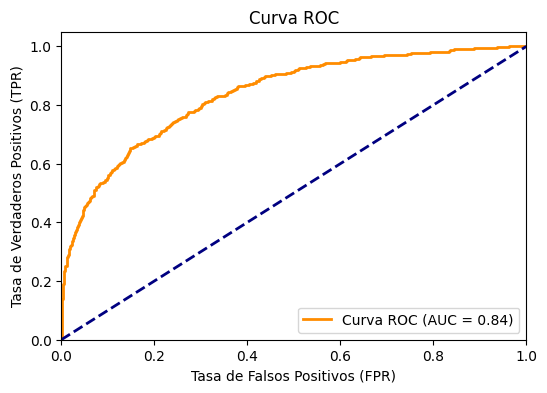

In [131]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_log3, tpr_log3, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_log3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [132]:
precision_log3 = accuracy_score(y_test_log3, y_pred_log3)
print("Precisión del modelo:", precision_log3.round(4))

Precisión del modelo: 0.8184


Este va a ser el mejor modelo de regresion logistica para clasificacion

In [133]:
recall_p_log3 = recall_score(y_test_log3, y_pred_log3,pos_label=1)
print("Recall del modelo para la clase positiva:", recall_p_log3)

Recall del modelo para la clase positiva: 0.541501976284585


In [134]:
recall_n_log3 = recall_score(y_test_log3, y_pred_log3,pos_label=0)
print("Recall del modelo para la clase negativa:", recall_n_log3)

Recall del modelo para la clase negativa: 0.9067422810333964


In [135]:
precision_p_log3 = precision_score(y_test_log3, y_pred_log3, pos_label=1)
print("Precisión para la clase positiva:", precision_p_log3)

Precisión para la clase positiva: 0.6492890995260664


In [136]:
precision_n_log3 = precision_score(y_test_log3, y_pred_log3, pos_label=0)
print("Precisión para la clase negativa:", precision_n_log3)

Precisión para la clase negativa: 0.8611609814482346


In [137]:
f1_p_log3 = f1_score(y_test_log3, y_pred_log3,pos_label=1)
print("Puntaje F1 para la clase positiva:", f1_p_log3)

Puntaje F1 para la clase positiva: 0.5905172413793103


In [138]:
f1_n_log3 = f1_score(y_test_log3, y_pred_log3,pos_label=0)
print("Puntaje F1 para la clase negativa:", f1_n_log3)

Puntaje F1 para la clase negativa: 0.8833640270104358


In [139]:
auc_score_log3 = roc_auc_score(y_test_log3, y_probs_log3)
print("AUC (Área bajo la Curva ROC):", auc_score_log3)

AUC (Área bajo la Curva ROC): 0.8381277225281498


# Modelos base


Lo modelos base son modelos que se realizan para ser superados por otro modelos ya que son basicos 

## Regresion lineal

In [313]:
X_train_base = X_train[['Humidity3pm', 'Sunshine',"Rainfall","Cloud3pm","Humidity9am"]]
y_train_base = X_train['RainfallTomorrow']
X_test_base = X_test[['Humidity3pm', 'Sunshine',"Rainfall","Cloud3pm","Humidity9am"]]
y_test_base = X_test['RainfallTomorrow']

regression_model_base = LinearRegression()

regression_model_base.fit(X_train_base, y_train_base)

y_pred_base = regression_model_base.predict(X_test_base)

mse = mean_squared_error(y_test_base, y_pred_base)
print("Error cuadrático medio:", mse.round(4))

mae_base=mean_absolute_error(y_test_base, y_pred_base)
print("MAE:",mae_base.round(4))

regression_model_base.score(X_train_base,y_train_base), regression_model_base.score(X_test_base,y_test_base)
print(f"""El R² para los datos de entrenamiento es: {regression_model_base.score(X_train_base,y_train_base).round(4)} y para los de testeo: {regression_model_base.score(X_test_base,y_test_base).round(4)}""")

mape_base = (mae_base / (y_test_base)).mean() * 100
print("MAPE:",mape_base.round(4))

Error cuadrático medio: 44.9096
MAE: 4.0728
El R² para los datos de entrenamiento es: 0.2162 y para los de testeo: 0.0158
MAPE: inf


Como vemos anteriormente, este modelo lo superamos con todos los que armamos

## Regresion Logistica


In [314]:

X_train_lbase = X_train[['Humidity3pm', 'Sunshine',"Rainfall","Cloud3pm","Humidity9am"]]
y_train_lbase = y_train
X_test_lbase=X_test[['Humidity3pm', 'Sunshine',"Rainfall","Cloud3pm","Humidity9am"]]
y_test_lbase=y_test




# Inicializar el modelo de regresión logística
logistic_model_lbase = LogisticRegression()

# Ajustar el modelo a los datos de entrenamiento
logistic_model_lbase.fit(X_train_lbase, y_train_lbase)

# Realizar predicciones en el conjunto de prueba
y_pred_lbase = logistic_model_lbase.predict(X_test_lbase)

# Calcular la precisión para evaluar el modelo
accuracy_lbase = accuracy_score(y_test_lbase, y_pred_lbase)
print("Precisión:", accuracy_lbase)

recall_p_lbase = recall_score(y_test_lbase, y_pred_lbase,pos_label=1)
print("Recall del modelo para la clase positiva:", recall_p_lbase.round(4))

recall_n_lbase = recall_score(y_test_lbase, y_pred_lbase,pos_label=0)
print("Recall del modelo para la clase negativa:", recall_n_lbase.round(4))

precision_p_lbase = precision_score(y_test_lbase, y_pred_lbase, pos_label=1)
print("Precisión para la clase positiva:", precision_p_lbase.round(4))

precision_n_lbase = precision_score(y_test_lbase, y_pred_lbase, pos_label=0)
print("Precisión para la clase negativa:", precision_n_lbase.round(4))

f1_p_lbase = f1_score(y_test_lbase, y_pred_lbase,pos_label=1)
print("Puntaje F1 para la clase positiva:", f1_p_lbase.round(4))

f1_n_lbase = f1_score(y_test_lbase, y_pred_lbase,pos_label=0)
print("Puntaje F1 para la clase negativa:", f1_n_lbase.round(4))


Precisión: 0.7195413282369804
Recall del modelo para la clase positiva: 0.7431
Recall del modelo para la clase negativa: 0.712
Precisión para la clase positiva: 0.4514
Precisión para la clase negativa: 0.8968
Puntaje F1 para la clase positiva: 0.5616
Puntaje F1 para la clase negativa: 0.7938


Como vemos estas metricas claramente tambien las superamos, las mismas al ser modelos base, no tienen todo el tratamiento previo que le dimos notros.

# Redes Neuronales

Para este modelo de arquitectura de red neuronal vamos a utilizar tensorflow

In [ ]:
!pip install tensorflow

## Redes neuronales para prediccion de cuanta lluvia

Vamos a realiar nuestro primer modelo de redes neuronales para la prediccion de cuanto llovera. Para esto utilizamos la libreria tensorflow 

In [140]:
X_train_rn1=X_train.drop(columns=["RainfallTomorrow"])
y_train_rn1=X_train["RainfallTomorrow"]
X_test_rn1=X_test.drop(columns=["RainfallTomorrow"])
y_test_rn1=X_test["RainfallTomorrow"]

In [143]:
columns_to_scale = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                     'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                     'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
                     'Temp9am', 'Temp3pm', 'Month']


scaler6 = StandardScaler()
X_train_rn1[columns_to_scale] = scaler6.fit_transform(X_train_rn1[columns_to_scale])
X_test_rn1[columns_to_scale] = scaler6.transform(X_test_rn1[columns_to_scale])

y_train_rn1=scaler6.fit_transform(y_train_rn1.to_numpy().reshape(-1,1))
y_test_rn1=scaler6.transform(y_test_rn1.to_numpy().reshape(-1,1))


In [144]:
model_rn1 = Sequential()
model_rn1.add(Dense(64, input_dim=X_train_rn1.shape[1], activation='leaky_relu'))
model_rn1.add(Dropout(0.05))
model_rn1.add(Dense(128, activation='leaky_relu'))
model_rn1.add(Dropout(0.05))
model_rn1.add(Dense(64, activation='leaky_relu'))
model_rn1.add(Dense(1, activation='linear'))

model_rn1.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

history_rn1 = model_rn1.fit(X_train_rn1, y_train_rn1, epochs=200, batch_size=32, validation_split=0.2)


Epoch 1/200
465/465 [==============================] - 2s 3ms/step - loss: 0.5095 - val_loss: 1.3404
Epoch 2/200
465/465 [==============================] - 1s 2ms/step - loss: 0.4780 - val_loss: 1.1379
Epoch 3/200
465/465 [==============================] - 1s 2ms/step - loss: 0.4082 - val_loss: 1.0869
Epoch 4/200
465/465 [==============================] - 1s 2ms/step - loss: 0.3895 - val_loss: 1.0785
Epoch 5/200
465/465 [==============================] - 1s 2ms/step - loss: 0.3752 - val_loss: 1.0619
Epoch 6/200
465/465 [==============================] - 1s 2ms/step - loss: 0.3635 - val_loss: 1.0020
Epoch 7/200
465/465 [==============================] - 1s 2ms/step - loss: 0.3368 - val_loss: 0.9888
Epoch 8/200
465/465 [==============================] - 1s 2ms/step - loss: 0.3301 - val_loss: 0.9203
Epoch 9/200
465/465 [==============================] - 1s 2ms/step - loss: 0.3199 - val_loss: 0.9245
Epoch 10/200
465/465 [==============================] - 1s 2ms/step - loss: 0.3061 - val_lo

66/66 [==============================] - 0s 1ms/step
R2 Score en test: 0.1692
MSE en test: 0.3584
RMSE en test: 0.5986
MAE en test: 0.2828



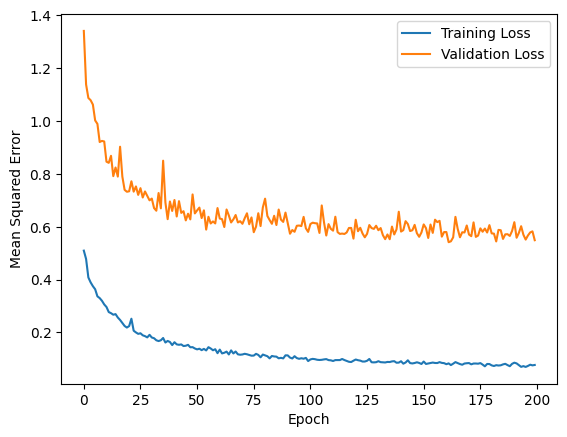

In [145]:

y_pred_rn1 = model_rn1.predict(X_test_rn1)

y_test_np_rn1 = y_test_rn1.flatten()

r2_test_rn1 = r2_score(y_test_np_rn1, y_pred_rn1)


mse_test_rn1 = mean_squared_error(y_test_np_rn1, y_pred_rn1)

rmse_test_rn1 = np.sqrt(mse_test_rn1)

mae_test_rn1 = mean_absolute_error(y_test_np_rn1, y_pred_rn1)

print(f'R2 Score en test: {r2_test_rn1.round(4)}')
print(f'MSE en test: {mse_test_rn1.round(4)}')
print(f'RMSE en test: {rmse_test_rn1.round(4)}')
print(f'MAE en test: {mae_test_rn1.round(4)}\n')

loss_history_rn1 = history_rn1.history['loss']
val_loss_history_rn1 = history_rn1.history['val_loss']

plt.plot(loss_history_rn1, label='Training Loss')
plt.plot(val_loss_history_rn1, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


Con una metrica de 0.24 de r2 podemos determinar que este modelo de redes neuronales es el mejor para regresion y prediccion de Cuanto llovera.

#### Otro modelo de redes neuronales para regresion


In [143]:
model_rn2 = Sequential()
model_rn2.add(Dense(64, input_dim=X_train_rn1.shape[1], activation='relu'))
model_rn2.add(Dropout(0.2))
model_rn2.add(Dense(32, activation='relu'))
model_rn2.add(Dropout(0.2))
model_rn2.add(Dense(1, activation='linear'))

model_rn2.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

model_rn2.fit(X_train_rn1, y_train_rn1, epochs=250, batch_size=32, validation_split=0.2)

y_pred_rn2 = model_rn2.predict(X_test_rn1)

y_test_np_rn2 = y_test_rn1.flatten()
r2_test_rn2 = r2_score(y_test_np_rn2, y_pred_rn2)
print(f"R2: {r2_test_rn2}")
mse_rn2 = mean_squared_error(y_test_rn1, y_pred_rn2)
print(f'Mean Squared Error on test set: {mse_rn2}')

Epoch 1/250
465/465 [==============================] - 1s 2ms/step - loss: 0.5702 - val_loss: 1.2983
Epoch 2/250
465/465 [==============================] - 1s 2ms/step - loss: 0.5001 - val_loss: 1.2208
Epoch 3/250
465/465 [==============================] - 1s 2ms/step - loss: 0.4658 - val_loss: 1.1811
Epoch 4/250
465/465 [==============================] - 1s 2ms/step - loss: 0.4400 - val_loss: 1.1417
Epoch 5/250
465/465 [==============================] - 1s 2ms/step - loss: 0.4268 - val_loss: 1.0700
Epoch 6/250
465/465 [==============================] - 1s 2ms/step - loss: 0.4314 - val_loss: 1.0476
Epoch 7/250
465/465 [==============================] - 1s 2ms/step - loss: 0.4022 - val_loss: 1.0907
Epoch 8/250
465/465 [==============================] - 1s 2ms/step - loss: 0.3922 - val_loss: 0.9985
Epoch 9/250
465/465 [==============================] - 1s 2ms/step - loss: 0.3670 - val_loss: 1.0331
Epoch 10/250
465/465 [==============================] - 1s 2ms/step - loss: 0.3705 - val_lo

In [145]:


class NeuralNetwork():
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        model = MLPRegressor(
            hidden_layer_sizes=(64, 32),
            activation='relu',
            solver='adam',
            alpha=0.0001,
            batch_size='auto',
            learning_rate='constant',
            learning_rate_init=0.001,
            max_iter=1000,
            random_state=42
        )
        return model

    def fit(self, epochs=1000):


        history = self.model.fit(X_train_rn1, y_train_rn1)

        y_pred = self.model.predict(X_test_rn1)

        r2_test = r2_score(y_test_rn1, y_pred)
        mse = mean_squared_error(y_test_rn1, y_pred)

        print(f'R2 on test set: {r2_test}')
        print(f'Mean Squared Error on test set: {mse}')

        return history.loss_curve_

    def predict(self):
        predictions = self.model.predict(X_test_rn1)
        return predictions



In [146]:
neural_network=NeuralNetwork()
loss_history=neural_network.fit(epochs=100)

R2 on test set: 0.034742692898102945
Mean Squared Error on test set: 0.965257307101897


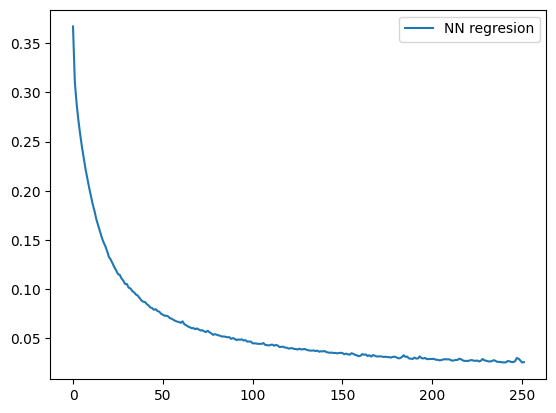

In [147]:
plt.plot(loss_history, label='NN regresion')
plt.legend()
plt.show()

In [ ]:
predictions = neural_network.predict()
print("Predicciones:", predictions[:5],y_test[:5])

Predicciones: [ 0.23773223 -0.23275211 -0.34169867  2.87064701 -0.20351719] 36428    0
45934    0
33932    0
68485    1
35810    1
Name: RainTomorrow, dtype: int64


## Redes neuronales para clasificacion (llovera o no)

In [148]:
X_train_rnc=X_train.drop(columns=["RainfallTomorrow"])
y_train_rnc=y_train
X_test_rnc=X_test.drop(columns=["RainfallTomorrow"])
y_test_rnc=y_test

In [149]:
columns_to_scale = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                     'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                     'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
                     'Temp9am', 'Temp3pm', 'RainToday', 'Month']


scaler7 = StandardScaler()
X_train_rnc[columns_to_scale] = scaler7.fit_transform(X_train_rnc[columns_to_scale])
X_test_rnc[columns_to_scale] = scaler7.transform(X_test_rnc[columns_to_scale])

In [150]:
y_test_rnc.value_counts()

0    1587
1     506
Name: RainTomorrow, dtype: int64

In [152]:
class NeuralNetwork_clas():
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=X_train_rnc.shape[1], activation="relu"))
        model.add(Dropout(0.05))
        model.add(Dense(32, activation="relu"))
        model.add(Dropout(0.05))
        model.add(Dense(1, activation="sigmoid"))
        print("Shape of X_train_rnc:", X_train_rnc.shape)
        print("Shape of y_train_rnc:", y_train_rnc.shape)
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
        print("Cant parametros: ", model.count_params())
        return model

    def fit(self, X, y, lr=0.0001, epochs=1000):
        X = np.array(X)
        y = np.array(y)

        history = self.model.fit(X, y, epochs=epochs, verbose=0)

        y_pred_prob = self.model.predict(X_test_rnc)
        y_pred_classes = (y_pred_prob > 0.5).astype(int)

        accuracy = accuracy_score(y_test_rnc, y_pred_classes)
        confusion_mat = confusion_matrix(y_test_rnc, y_pred_classes)

        print(f'Accuracy on test set: {accuracy}')
        print(f'Confusion Matrix on test set:\n{confusion_mat}')

        return history.history["loss"]

    def predict(self, X):
        X = np.array(X)
        print("Shape of X_test_rnc:", X.shape)
        predictions_prob = self.model.predict(X)
        predictions_classes = (predictions_prob > 0.5).astype(int)
        return predictions_classes

In [153]:
nn=NeuralNetwork_clas()
ls=nn.fit(X_train_rnc,y_train_rnc,lr=0.01,epochs=200)

Shape of X_train_rnc: (18562, 70)
Shape of y_train_rnc: (18562,)
Cant parametros:  6657
66/66 [==============================] - 0s 969us/step
Accuracy on test set: 0.8064978499761108
Confusion Matrix on test set:
[[1351  236]
 [ 169  337]]


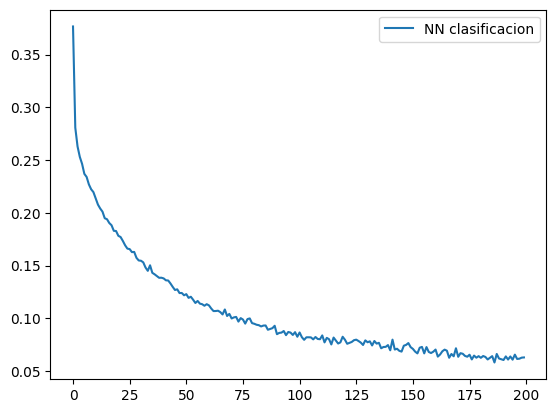

In [154]:
plt.plot(ls, label='NN clasificacion')
plt.legend()
plt.show()

# Optimizacion de Hiperparametros

## Metodo Grid Search

El método de optimización de hiperparámetros Grid Search es una técnica comúnmente utilizada en aprendizaje automático para encontrar la combinación óptima de hiperparámetros para un modelo.

La búsqueda Grid Search explora exhaustivamente diferentes combinaciones de hiperparámetros para un modelo de aprendizaje automático, evaluando el rendimiento de cada combinación mediante validación cruzada. El objetivo es encontrar la configuración de hiperparámetros que optimice una métrica de evaluación predefinida, como precisión o error cuadrático medio. Una vez encontrada la mejor combinación, se entrena el modelo final con esos hiperparámetros seleccionados. Este proceso ayuda a mejorar el rendimiento del modelo y ajustar su comportamiento para adaptarse mejor a los datos de entrenamiento.

Traemos el mejor modelo de regresion lineal que armamos

In [320]:
X_train_gs = X_train.drop("RainfallTomorrow",axis=1)
y_train_gs = X_train['RainfallTomorrow']
X_test_gs=X_test.drop("RainfallTomorrow",axis=1)
y_test_gs = X_test['RainfallTomorrow']

In [321]:
columns_to_scale = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                     'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                     'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
                     'Temp9am', 'Temp3pm', 'RainToday', 'Month']


scaler8 = StandardScaler()
X_train_rn1[columns_to_scale] = scaler8.fit_transform(X_train_rn1[columns_to_scale])
X_test_rn1[columns_to_scale] = scaler8.transform(X_test_rn1[columns_to_scale])

y_train_gs=scaler8.fit_transform(y_train_gs.to_numpy().reshape(-1,1))
y_test_gs=scaler8.transform(y_test_gs.to_numpy().reshape(-1,1))

In [322]:


param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}


regression_model = LinearRegression()


grid_search = GridSearchCV(regression_model, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train_gs, y_train_gs)

print("Mejor puntuación (neg_mean_squared_error):", grid_search.best_score_)
print("Mejores hiperparámetros:", grid_search.best_params_)


best_model = grid_search.best_estimator_


y_pred_gsr = best_model.predict(X_test_gs)


mse_gsr = mean_squared_error(y_test_gs, y_pred_gsr)
r2_gsr = r2_score(y_test_gs, y_pred_gsr)

print(f'Mean Squared Error on test set: {mse_gsr}')
print(f'R2 Score on test set: {r2_gsr}')

Mejor puntuación (neg_mean_squared_error): -0.71992986369055
Mejores hiperparámetros: {'fit_intercept': False, 'positive': False}
Mean Squared Error on test set: 0.8795026556614061
R2 Score on test set: 0.12049734433859394


Ahora lo realizamos con la mejor regresion logistica que hicimos

In [323]:
scores = ["precision", "recall"]

In [324]:

def print_dataframe(filtered_cv_results):
    ### Un print bonito de los resultados de cross validation
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()


def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.7, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.7

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

In [325]:
tuned_parameters = [
    {"class_weight": [None, 'balanced'], "C": [0.1, 1, 10,100], "solver": ['newton-cg'], "max_iter": [200, 500]}
]

grid_search = GridSearchCV(
    LogisticRegression(), tuned_parameters, scoring=scores, refit=refit_strategy
)
grid_search.fit(X_train.drop("RainfallTomorrow",axis=1), y_train)

All grid-search results:
precision: 0.891 (±0.012), recall: 0.818 (±0.219), for {'C': 0.1, 'class_weight': None, 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.891 (±0.012), recall: 0.818 (±0.219), for {'C': 0.1, 'class_weight': None, 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.891 (±0.012), recall: 0.818 (±0.219), for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.891 (±0.012), recall: 0.818 (±0.219), for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.894 (±0.013), recall: 0.809 (±0.239), for {'C': 1, 'class_weight': None, 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.894 (±0.013), recall: 0.809 (±0.239), for {'C': 1, 'class_weight': None, 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.894 (±0.013), recall: 0.809 (±0.239), for {'C': 1, 'class_weight': 'balanced', 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.894 (±0.013), recall: 0.809 (±0.239), for {'C': 1, 'cl

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'C': [0.1, 1, 10, 100],
                          'class_weight': [None, 'balanced'],
                          'max_iter': [200, 500], 'solver': ['newton-cg']}],
             refit=<function refit_strategy at 0x00000243A074A0D8>,
             scoring=['precision', 'recall'])

## Metodo Random Search

Random Search es similar a la búsqueda en cuadrícula,  en vez de explorar todas las combinaciones, selecciona aleatoriamente un conjunto limitado de combinaciones de hiperparámetros para evaluar. Esto puede ser más eficiente computacionalmente y aún así descubrir configuraciones efectivas, especialmente cuando el espacio de búsqueda es grande. Tambien utiliza validación cruzada para evaluar el rendimiento de cada combinación y selecciona la mejor.

In [335]:
X_train_rs = X_train.drop("RainfallTomorrow",axis=1)
y_train_rs = X_train['RainfallTomorrow']
X_test_rs=X_test.drop("RainfallTomorrow",axis=1)
y_test_rs = X_test['RainfallTomorrow']

In [336]:
# función para entrenar y evaluar un modelo con hiperparámetros dados
def train_evaluate_model(params, X_train, y_train, X_test, y_test):
    model = LinearRegression(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

In [350]:

linear_params = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}


linear_random_search = RandomizedSearchCV(LinearRegression(), linear_params, n_iter=4, cv=5, scoring='neg_mean_squared_error',verbose=1)
linear_random_search.fit(X_train_rs, y_train_rs)


best_linear_params = linear_random_search.best_params_
best_linear_model = LinearRegression(**best_linear_params)
best_linear_model.fit(X_train_rs, y_train_rs)

linear_search_mse = mean_squared_error(y_test_rs, best_linear_model.predict(X_test_rs))
linear_search_r2 = r2_score(y_test_rs, best_linear_model.predict(X_test_rs))

print(f'Mean Squared Error on test set: {linear_search_mse}')
print(f'R^2 on test set: {linear_search_r2}')
print("Mejores hiperparámetros para la regresión lineal:")
print(linear_random_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Mean Squared Error on test set: 38.59496897540197
R^2 on test set: 0.1541705820635315
Mejores hiperparámetros para la regresión lineal:
{'positive': False, 'fit_intercept': False}


In [351]:

# Define los hiperparámetros y sus valores para la regresión logística
logistic_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [50, 100, 200, 500]
}

# Realiza la búsqueda aleatoria con la mejor regresión logística existente
logistic_random_search = RandomizedSearchCV(LogisticRegression(), logistic_params, n_iter=4, cv=5, scoring='accuracy')
logistic_random_search.fit(X_train.drop("RainfallTomorrow",axis=1), y_train)

# Imprime el mejor resultado y los hiperparámetros óptimos
print("Mejor precisión:", logistic_random_search.best_score_)
print("Mejores hiperparámetros para la regresión logística:")
print(logistic_random_search.best_params_)

# Crea el modelo con los mejores hiperparámetros y ajústalo a los datos de entrenamiento
best_logistic_model = LogisticRegression(**logistic_random_search.best_params_)
best_logistic_model.fit(X_train.drop("RainfallTomorrow",axis=1), y_train)

# Realiza predicciones en el conjunto de prueba
y_pred_logistic = best_logistic_model.predict(X_test.drop("RainfallTomorrow",axis=1))

# Calcula la precisión en el conjunto de prueba
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("Precisión en el conjunto de prueba:", accuracy_logistic)

Mejor precisión: 0.8575173319278955
Mejores hiperparámetros para la regresión logística:
{'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 200, 'fit_intercept': True, 'C': 100}
Precisión en el conjunto de prueba: 0.8155757286192069


## Metodo Optuna


Optuna es un marco de optimización de hiperparámetros basado en algoritmos de optimización de árboles. En lugar de realizar una búsqueda exhaustiva (GridSearch) o aleatoria(RandomSearch), Optuna utiliza técnicas de optimización secuencial para encontrar de manera eficiente la mejor combinación de hiperparámetros para maximizar o minimizar una función objetivo específica. Optuna se adapta dinámicamente a las evaluaciones anteriores y dirige la búsqueda hacia regiones prometedoras del espacio de hiperparámetros. Esto lo hace eficaz para problemas complejos y costosos en términos computacionales.

In [155]:
pip install optuna

  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)


You should consider upgrading via the 'C:\Users\tomas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [352]:
X_train_op = X_train.drop("RainfallTomorrow",axis=1)
y_train_op = X_train['RainfallTomorrow']
X_test_op = X_test.drop("RainfallTomorrow",axis=1)
y_test_op = X_test['RainfallTomorrow']

In [353]:
columns_to_scale = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                     'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                     'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
                     'Temp9am', 'Temp3pm', 'RainToday', 'Month']


scaler9 = StandardScaler()
X_train_op[columns_to_scale] = scaler9.fit_transform(X_train_op[columns_to_scale])
X_test_op[columns_to_scale] = scaler9.transform(X_test_op[columns_to_scale])
y_train_op=scaler9.fit_transformtransform(y_train_op.to_numpy().reshape(-1,1))
y_test_op=scaler9.transform(y_test_op.to_numpy().reshape(-1,1))

### Regresion Lineal

In [355]:
def objective(trial):

    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    positive=trial.suggest_categorical('positive', [True, False])
    n_jobs = trial.suggest_int('n_jobs', -1, 1)  


    model = LinearRegression(fit_intercept=fit_intercept, n_jobs=n_jobs)

    model.fit(X_train_op, y_train_op)
    y_pred_op = model.predict(X_test_op)

    mse = mean_squared_error(y_test_op, y_pred_op)

    return mse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)


best_optuna_params = study.best_params


best_optuna_model_lr = LinearRegression(**best_optuna_params)


best_optuna_model_lr.fit(X_train_op, y_train_op)


y_pred_optuna = best_optuna_model_lr.predict(X_test_op)


final_metric = mean_squared_error(y_test_op, y_pred_optuna)

best_optuna_model_lr.score(X_train_op,y_train_op), best_optuna_model_lr.score(X_test_op,y_test_op)
print(f"""El R² para los datos de entrenamiento es: {best_optuna_model_lr.score(X_train_op,y_train_op).round(4)} y para los de testeo: {best_optuna_model_lr.score(X_test_op,y_test_op).round(4)}""")


print(f'Mean Squared Error on test set: {final_metric}')
print("Best Optuna Parameters:", best_optuna_params)

[I 2023-12-02 12:32:31,724] A new study created in memory with name: no-name-710db185-abe9-466b-9091-abba03c5583f
[I 2023-12-02 12:32:31,815] Trial 0 finished with value: 0.8278843504395642 and parameters: {'fit_intercept': False, 'positive': False, 'n_jobs': -1}. Best is trial 0 with value: 0.8278843504395642.
[I 2023-12-02 12:32:31,906] Trial 1 finished with value: 0.8346495946553593 and parameters: {'fit_intercept': True, 'positive': True, 'n_jobs': 0}. Best is trial 0 with value: 0.8278843504395642.
[I 2023-12-02 12:32:32,002] Trial 2 finished with value: 0.8346495946553593 and parameters: {'fit_intercept': True, 'positive': True, 'n_jobs': 0}. Best is trial 0 with value: 0.8278843504395642.
[I 2023-12-02 12:32:32,095] Trial 3 finished with value: 0.8278843504395642 and parameters: {'fit_intercept': False, 'positive': True, 'n_jobs': 0}. Best is trial 0 with value: 0.8278843504395642.
[I 2023-12-02 12:32:32,202] Trial 4 finished with value: 0.8346495946553593 and parameters: {'fit_

El R² para los datos de entrenamiento es: 0.2823 y para los de testeo: 0.1721
Mean Squared Error on test set: 0.8278843504395642
Best Optuna Parameters: {'fit_intercept': False, 'positive': False, 'n_jobs': -1}


Validacion Cruzada mejor modelo optuna regresion lineal

In [356]:

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

cross_val_scores = cross_val_score(best_optuna_model_lr, X_train_op, y_train_op, cv=kf, scoring='neg_mean_squared_error')

mse_scores = -cross_val_scores
rmse_scores = np.sqrt(mse_scores)
print("RMSE en cada fold:", rmse_scores)
print("RMSE medio:", rmse_scores.mean())

RMSE en cada fold: [0.78766824 0.91535483 0.84167649 0.82390568 0.87679641]
RMSE medio: 0.8490803276398543


### Regresion Logistica

In [357]:
X_train_log_p=X_train.drop("RainfallTomorrow",axis=1)
y_train_log_p=y_train
X_test_log_p=X_test.drop("RainfallTomorrow",axis=1)
y_test_log_p=y_test

In [358]:
columns_to_scale = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                     'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                     'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
                     'Temp9am', 'Temp3pm', 'RainToday', 'Month']


scaler10 = StandardScaler()
X_train_log_p[columns_to_scale] = scaler10.fit_transform(X_train_log_p[columns_to_scale])
X_test_log_p[columns_to_scale] = scaler10.transform(X_test_log_p[columns_to_scale])

In [359]:

def objective(trial):
    
    C = trial.suggest_loguniform('C', 0.01, 10.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])

    
    model = LogisticRegression(C=C, max_iter=max_iter, penalty=penalty, solver=solver)

    
    model.fit(X_train_log_p, y_train_log_p)
    y_pred = model.predict(X_test_log_p)

    
    mse = mean_squared_error(y_test_log_p, y_pred)

    return mse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
best_optuna_params = study.best_params
best_optuna_model_log = LogisticRegression(**best_optuna_params)
best_optuna_model_log.fit(X_train_log_p, y_train_log_p)
y_pred_optuna = best_optuna_model_log.predict(X_test_log_p)
final_metric = mean_squared_error(y_test_log_p, y_pred_optuna)
accuracy = accuracy_score(y_test_log_p, y_pred_optuna)
recall = recall_score(y_test_log_p, y_pred_optuna)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')

print(f'Mean Squared Error on test set: {final_metric}')
print("Best Optuna Parameters:", best_optuna_params)

[I 2023-12-02 12:32:59,708] A new study created in memory with name: no-name-714ba4bc-eac4-4b07-9a22-e989c77e60a8
[I 2023-12-02 12:33:00,324] Trial 0 finished with value: 0.20305781175346393 and parameters: {'C': 3.646166177927723, 'max_iter': 927, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.20305781175346393.
[I 2023-12-02 12:33:03,329] Trial 1 finished with value: 0.2016244624940277 and parameters: {'C': 0.7370525119867994, 'max_iter': 428, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 1 with value: 0.2016244624940277.
[I 2023-12-02 12:33:05,574] Trial 2 finished with value: 0.20114667940754896 and parameters: {'C': 0.21242863779818, 'max_iter': 883, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 2 with value: 0.20114667940754896.
[I 2023-12-02 12:33:05,763] Trial 3 finished with value: 0.20305781175346393 and parameters: {'C': 8.99695224023179, 'max_iter': 627, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 2 with value: 0.20114667940754896.

Accuracy: 0.8017200191113235
Recall: 0.6778656126482213
Mean Squared Error on test set: 0.19827998088867654
Best Optuna Parameters: {'C': 0.06358822554928491, 'max_iter': 450, 'penalty': 'l1', 'solver': 'liblinear'}


Validacion cruzada regresion logistica optuna

In [360]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

cross_val_scores = cross_val_score(best_optuna_model_log, X_train_log_p, y_train_log_p, cv=kf, scoring='accuracy')

print("Accuracy en cada fold:", cross_val_scores)
print("Accuracy medio:", cross_val_scores.mean())

Accuracy en cada fold: [0.87234043 0.88015082 0.88092672 0.87823276 0.86880388]
Accuracy medio: 0.8760909218078142


### Red Neuronal

Para regresion

In [361]:
X_train_rn1=X_train.drop(columns=["RainfallTomorrow"])
y_train_rn1=X_train["RainfallTomorrow"]
X_test_rn1=X_test.drop(columns=["RainfallTomorrow"])
y_test_rn1=X_test["RainfallTomorrow"]

In [362]:
columns_to_scale = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                     'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                     'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
                     'Temp9am', 'Temp3pm', 'RainToday', 'Month']


scaler11 = StandardScaler()
X_train_rn1[columns_to_scale] = scaler11.fit_transform(X_train_rn1[columns_to_scale])
X_test_rn1[columns_to_scale] = scaler11.transform(X_test_rn1[columns_to_scale])
y_train_rn1=scaler11.fit_transform(y_train_rn1.to_numpy().reshape(-1,1))
y_test_rn1=scaler11.transform(y_test_rn1.to_numpy().reshape(-1,1))

In [363]:



def create_model(trial):
    model = Sequential()
    model.add(Dense(trial.suggest_int('units_1', 32, 128), input_dim=X_train_rn1.shape[1], activation='relu'))
    model.add(Dropout(trial.suggest_float('dropout_1', 0.0, 0.5)))
    model.add(Dense(trial.suggest_int('units_2', 16, 64), activation='relu'))
    model.add(Dropout(trial.suggest_float('dropout_2', 0.0, 0.5)))
    model.add(Dense(1, activation='linear'))

    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    return model

def objective(trial):
    model = create_model(trial)

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_rn1, y_train_rn1,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=0,
        callbacks=[es]
    )

    val_loss = history.history['val_loss'][-1]
    return val_loss


study_rn1 = optuna.create_study(direction='minimize')
study_rn1.optimize(objective, n_trials=20)

best_params_rn1 = study_rn1.best_params
final_model_rn1 = create_model(study_rn1.best_trial)
es_rn1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
final_model_rn1.fit(X_train_rn1, y_train_rn1, epochs=200, batch_size=32, verbose=1, callbacks=[es_rn1])
test_loss_rn1 = final_model_rn1.evaluate(X_test_rn1, y_test_rn1)

print(f'Test Loss: {test_loss_rn1}')

[I 2023-12-02 12:33:36,382] A new study created in memory with name: no-name-f37a2f22-f955-4fcd-841c-dbff72c2a0b8
[I 2023-12-02 12:34:12,883] Trial 0 finished with value: 1.0834975242614746 and parameters: {'units_1': 66, 'dropout_1': 0.43395335916396033, 'units_2': 57, 'dropout_2': 0.2633252841361665, 'lr': 0.00014139443546486058}. Best is trial 0 with value: 1.0834975242614746.
[I 2023-12-02 12:34:48,964] Trial 1 finished with value: 1.22581148147583 and parameters: {'units_1': 112, 'dropout_1': 0.1679024874451971, 'units_2': 19, 'dropout_2': 0.36959470793772614, 'lr': 3.122753213590417e-05}. Best is trial 0 with value: 1.0834975242614746.
[I 2023-12-02 12:35:04,810] Trial 2 finished with value: 0.9473204016685486 and parameters: {'units_1': 68, 'dropout_1': 0.33321331831509843, 'units_2': 35, 'dropout_2': 0.2168878387222576, 'lr': 0.003545393442850921}. Best is trial 2 with value: 0.9473204016685486.
[I 2023-12-02 12:35:26,816] Trial 3 finished with value: 0.8986110687255859 and par

Epoch 1/200
581/581 [==============================] - 2s 2ms/step - loss: 0.8485
Epoch 2/200
581/581 [==============================] - 1s 1ms/step - loss: 0.7004
Epoch 3/200
581/581 [==============================] - 1s 2ms/step - loss: 0.6516
Epoch 4/200
581/581 [==============================] - 1s 2ms/step - loss: 0.6179
Epoch 5/200
581/581 [==============================] - 1s 2ms/step - loss: 0.5946
Epoch 6/200
581/581 [==============================] - 1s 2ms/step - loss: 0.5743
Epoch 7/200
581/581 [==============================] - 1s 2ms/step - loss: 0.5555
Epoch 8/200
581/581 [==============================] - 1s 2ms/step - loss: 0.5426
Epoch 9/200
581/581 [==============================] - 1s 2ms/step - loss: 0.5100
Epoch 10/200
581/581 [==============================] - 1s 2ms/step - loss: 0.4970
Epoch 11/200
581/581 [==============================] - 1s 2ms/step - loss: 0.4897
Epoch 12/200
581/581 [==============================] - 1s 2ms/step - loss: 0.4769
Epoch 13/200


In [364]:
y_pred_rn1 = final_model_rn1.predict(X_test_rn1)
test_loss_rn1 = mean_squared_error(y_test_rn1, y_pred_rn1)
r2_rn1 = r2_score(y_test_rn1, y_pred_rn1)

print(f'Test Loss (MSE) on test set: {test_loss_rn1}')
print(f'R^2 on test set: {r2_rn1}')

 1/66 [..............................] - ETA: 4s

66/66 [==============================] - 0s 1ms/step
Test Loss (MSE) on test set: 0.7872068618195123
R^2 on test set: 0.21279313818048773


Redes neuronales para clasificacion:

In [169]:
X_train_rnc=X_train.drop(columns=["RainfallTomorrow"])
y_train_rnc=y_train
X_test_rnc=X_test.drop(columns=["RainfallTomorrow"])
y_test_rnc=y_test

In [170]:
columns_to_scale = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                     'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                     'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
                     'Temp9am', 'Temp3pm', 'RainToday', 'Month']


scaler13 = StandardScaler()
X_train_rnc[columns_to_scale] = scaler13.fit_transform(X_train_rnc[columns_to_scale])
X_test_rnc[columns_to_scale] = scaler13.transform(X_test_rnc[columns_to_scale])


In [171]:

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

model_params = {'units_1': 104, 'dropout_1': 0.1713878624800142, 'units_2': 39, 'dropout_2': 0.21816170317528494, 'lr': 0.0012579322798480842}


def create_model():
    model = Sequential()
    model.add(Dense(model_params['units_1'], input_dim=X_train_rnc.shape[1], activation='relu'))
    model.add(Dropout(model_params['dropout_1']))
    model.add(Dense(model_params['units_2'], activation='relu'))
    model.add(Dropout(model_params['dropout_2']))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=model_params['lr']), loss='binary_crossentropy', metrics=['accuracy'])
    return model

fold_accuracies = []

for train_index, test_index in skf.split(X_train_rnc, y_train_rnc):
    X_train_fold, X_test_fold = X_train_rnc.iloc[train_index], X_train_rnc.iloc[test_index]
    y_train_fold, y_test_fold = y_train_rnc.iloc[train_index], y_train_rnc.iloc[test_index]

    model = create_model()

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_test_fold, y_test_fold),
        epochs=50,
        batch_size=32,
        verbose=0,
        callbacks=[es]
    )

    y_pred_fold = (model.predict(X_test_fold) > 0.5).astype(int)
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    fold_accuracies.append(accuracy)


for i, accuracy in enumerate(fold_accuracies, 1):
    print(f'Fold {i} Accuracy: {accuracy}')


print(f'Mean Accuracy: {np.mean(fold_accuracies)}')
print(f'Standard Deviation: {np.std(fold_accuracies)}')


116/116 [==============================] - 0s 1ms/step
Fold 1 Accuracy: 0.889577161325074
Fold 2 Accuracy: 0.894155669270132
Fold 3 Accuracy: 0.8976293103448276
Fold 4 Accuracy: 0.8855064655172413
Fold 5 Accuracy: 0.8922413793103449
Mean Accuracy: 0.8918219971535241
Standard Deviation: 0.00410541157958036


# explicabilidad

In [172]:
!pip install shap


You should consider upgrading via the 'C:\Users\tomas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [365]:

shap.initjs()

## Regresion Lineal

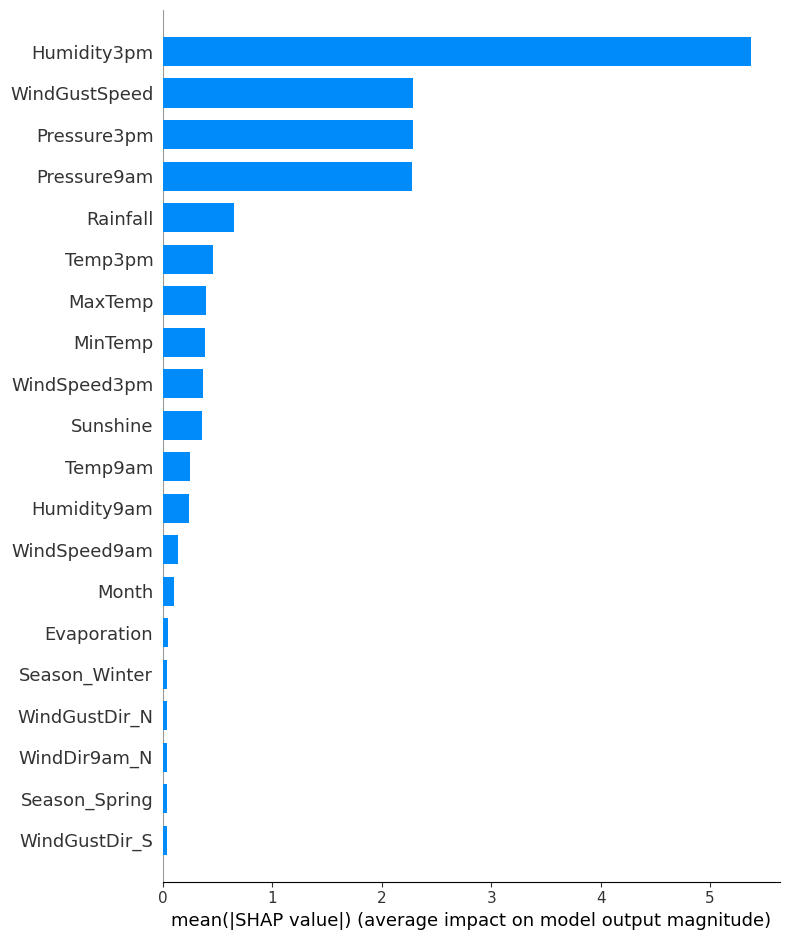

In [173]:

explainer_lr = shap.Explainer(best_optuna_model_lr, X_test.drop("RainfallTomorrow",axis=1).iloc[:300, :])


shap_values_lr = explainer_lr.shap_values(X_test.drop("RainfallTomorrow",axis=1).iloc[:300, :])


shap.summary_plot(shap_values_lr,
                  X_test.drop("RainfallTomorrow",axis=1).iloc[:300, :],
                  feature_names= X_test.drop("RainfallTomorrow",axis=1).columns,
                  plot_type="bar")

Como podes ver en el grafico, el valor principal que mas peso tiene a la hora de predecir el modelo cuanto llovera es La humedad a las 3pm , la velocidad del viento y la presion tanto de la mañana como la de la tarde. 

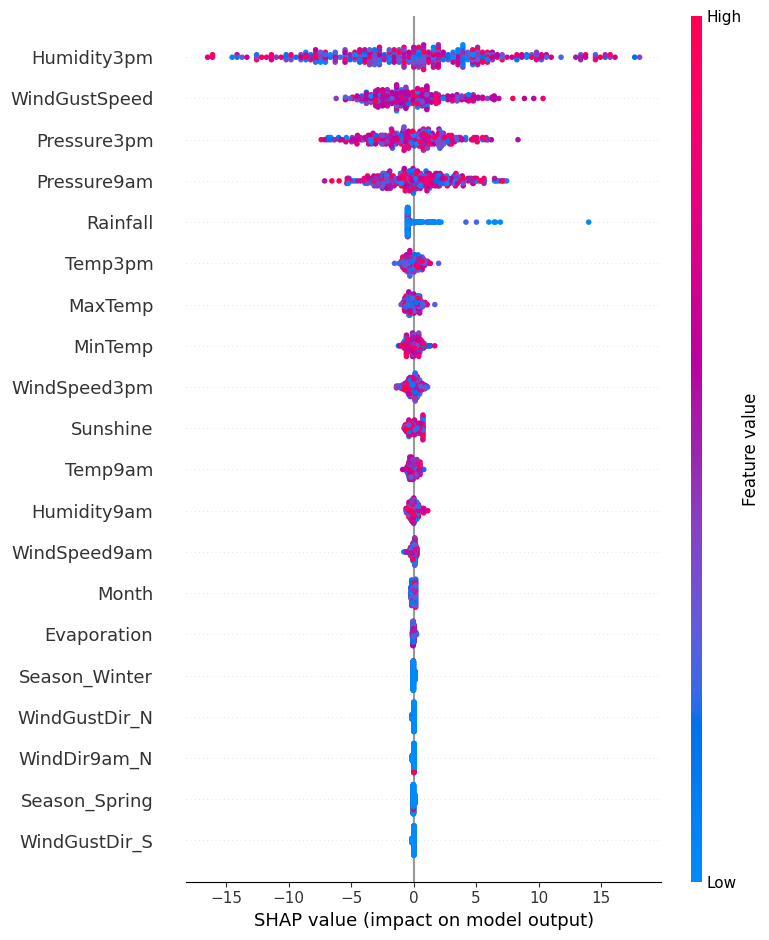

In [174]:

shap.summary_plot(shap_values_lr,  X_train.drop("RainfallTomorrow", axis=1).iloc[:300, :])


En este grafico podemos ver como las variables explicativas humedad a las 3pm , la velocidad del viento y la presion tanto de la mañana como la de la tarde influyen para predecir cuanto llovera asi tambien como si no llovera.
Mientras que variables como si llovio hoy, y la temperatura, nos encontramos que a mayor lluvia hoy, es probable que mañana siga lloviendo (dependiendo de cuanto llovio mañana puede seguir lloviendo una cantidad al menos) y a mayor temperatura hoy es esperable que mañana llueva. A mayor temperatura mas llovera

In [175]:
ind = 0
shap.initjs()


base_value_lr = explainer_lr.expected_value


shap.plots.force(base_value_lr, shap_values_lr[ind], feature_names= X_train.drop("RainfallTomorrow", axis=1).columns)

En este grafico de tire y afloje se puede ver como las variables que mas influyen para que mañana llueva son: HUmedad a las 3pm o sea que a mayor humedad se espera mas precippitacion al otro dia, presion a las 3pm y velocidad del viento. Mientras que las variables que mejor explican que no va a llover son una temperatura minima baja, velocidad del viento y que llueva poco

## Regresion Logistica

In [176]:
explainer_log = shap.Explainer(best_optuna_model_log, X_train.drop("RainfallTomorrow", axis=1))

shap_values_log = explainer_log.shap_values(X_test.drop("RainfallTomorrow", axis=1))

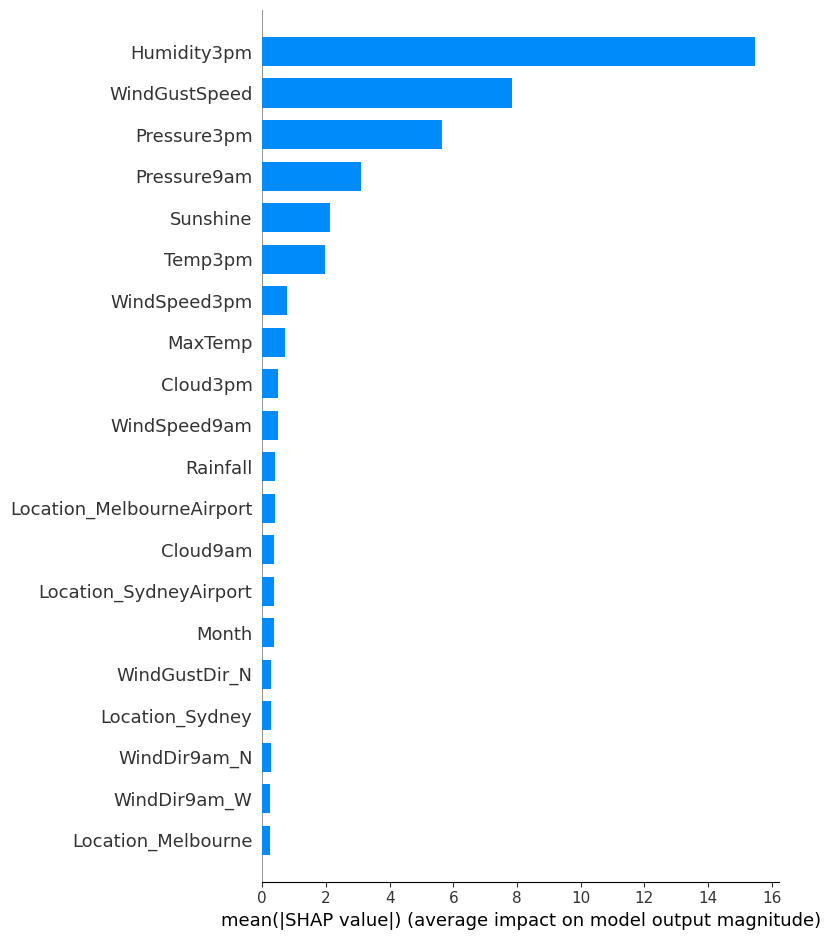

In [177]:
shap.summary_plot(shap_values_log, X_test.drop("RainfallTomorrow", axis=1), plot_type="bar")

Misma conclusion que el de regresion lineal

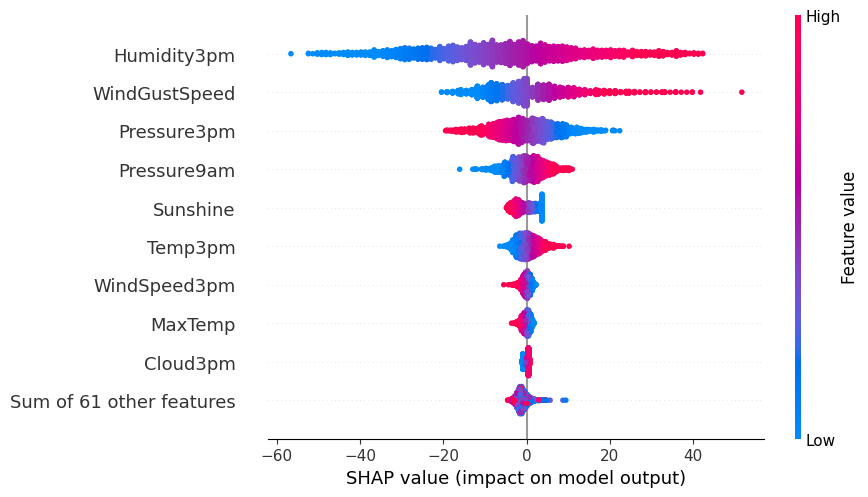

In [178]:
shap_values_log = shap.Explanation(
    values=shap_values_log,
    base_values=explainer_log.expected_value,
    data=X_test.drop("RainfallTomorrow", axis=1),
    feature_names=X_test.drop("RainfallTomorrow", axis=1).columns
)


shap.plots.beeswarm(shap_values_log)


En este gracio se puede ver lo mismo pero lo podemos apreciar un poco mejor a lo explicado previamente. Una humedad baja a las 3 de la tarde es sinonimo practicamente que no llovera mientras que alto es quiere decir que llovera. Lo mismo para la velocidad del viento, cuanto mas alta es, mas probable es que llueve 

In [179]:
shap.initjs()


sample_instances_log = X_test.drop("RainfallTomorrow", axis=1).iloc[:300, :]


shap_values_samples_log = explainer_log.shap_values(sample_instances_log)


shap.force_plot(
    base_value=explainer_log.expected_value,
    shap_values=shap_values_samples_log,
    features=sample_instances_log
)


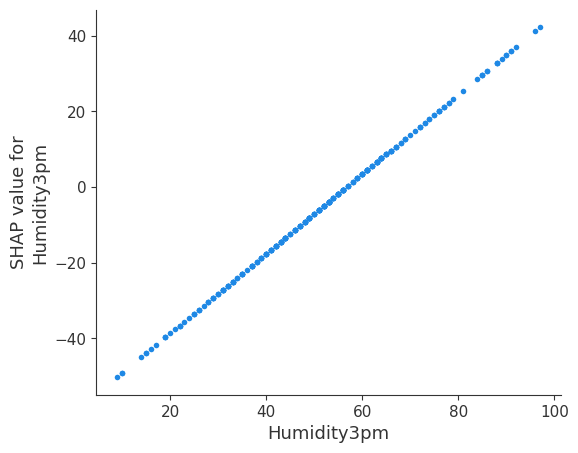

In [180]:
shap.dependence_plot('Humidity3pm', shap_values_samples_log, sample_instances_log, interaction_index=None)

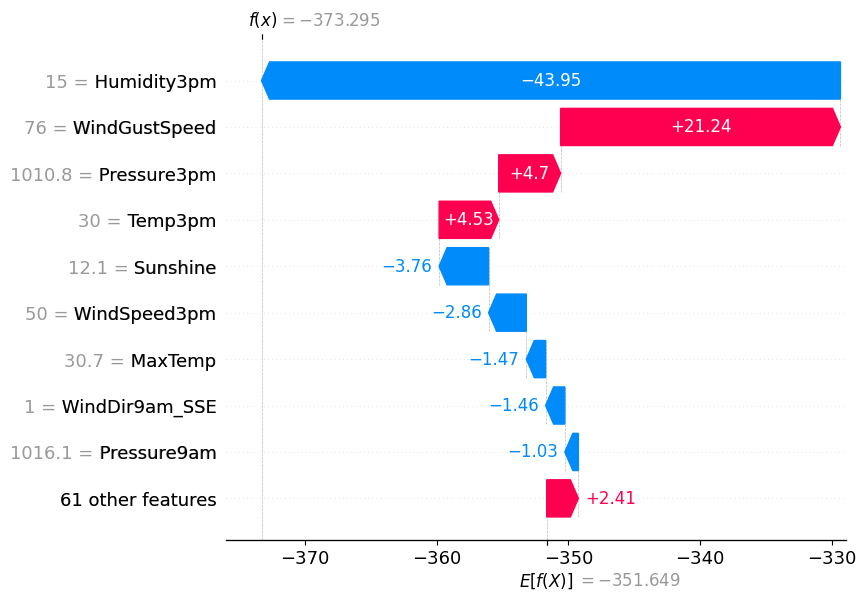

In [181]:

index = 1


explanation_log = shap.Explanation(
    values=shap_values_log[index],
    base_values=explainer_log.expected_value,
    data=X_test.drop("RainfallTomorrow", axis=1).iloc[index, :],
    feature_names=X_test.drop("RainfallTomorrow", axis=1).columns
)


shap.plots.waterfall(explanation_log, max_display=10)

Un poco de lo explicado anteriormente pero puesto en un grafico, una humedad baja hace pocas probabilidades de lluvia, un viento alto lo contrario, una presion atmosferica de 1010 existen mas probabilidades de lluvia y una alta temperatura produce lo mismo

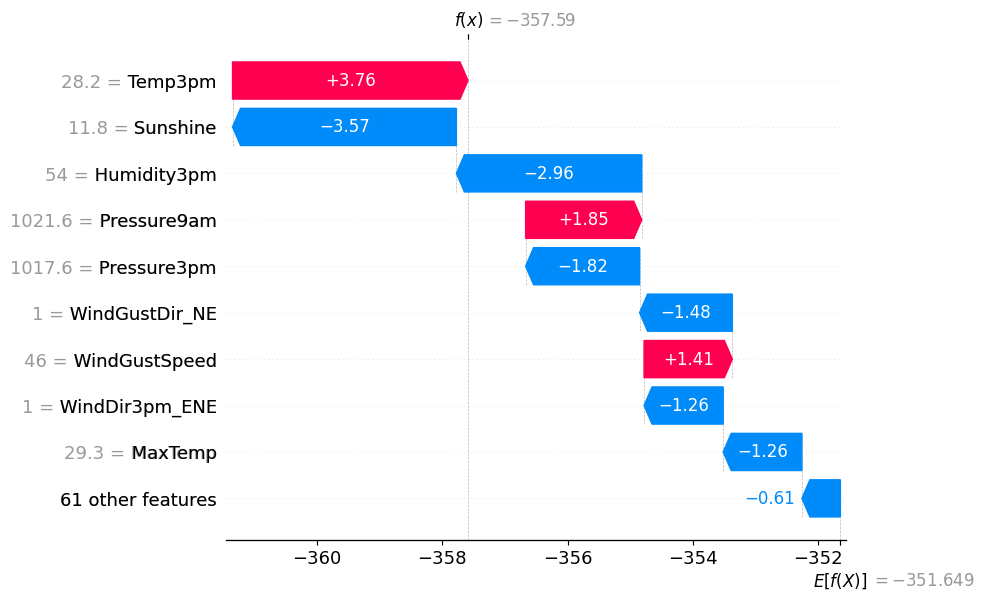

In [182]:
index = 2

explanation_log = shap.Explanation(
    values=shap_values_log[index],
    base_values=explainer_log.expected_value,
    data=X_test.drop("RainfallTomorrow", axis=1).iloc[index, :],
    feature_names=X_test.drop("RainfallTomorrow", axis=1).columns
)


shap.plots.waterfall(explanation_log, max_display=10)

## Red Neuronal

In [377]:

def f(X):
    return model_rn1.predict(X)


explainer_nn = shap.Explainer(f, X_train_rn1.iloc[:120, :])
shap_values_nn = explainer_nn.shap_values(X_test_rn1.iloc[:120, :])

explainer_kernel_nn = shap.KernelExplainer(f, X_train_rn1.iloc[:120, :])
shap_values_kernel_nn = explainer_kernel_nn.shap_values(X_test_rn1.iloc[:120, :])

 48/162 [=======>......................] - ETA: 0s

132/132 [==============================] - 0s 1ms/step


Permutation explainer:   5%|▌         | 6/120 [00:00<?, ?it/s]

127/127 [==============================] - 0s 1ms/step


Permutation explainer:   7%|▋         | 8/120 [00:12<01:45,  1.06it/s]

132/132 [==============================] - 0s 1ms/step


Permutation explainer:   8%|▊         | 9/120 [00:14<02:24,  1.30s/it]

126/126 [==============================] - 0s 908us/step


Permutation explainer:   8%|▊         | 10/120 [00:16<02:44,  1.50s/it]

126/126 [==============================] - 0s 1ms/step


Permutation explainer:   9%|▉         | 11/120 [00:18<02:57,  1.63s/it]

136/136 [==============================] - 0s 992us/step


Permutation explainer:  10%|█         | 12/120 [00:19<03:02,  1.69s/it]

125/125 [==============================] - 0s 1ms/step


Permutation explainer:  11%|█         | 13/120 [00:21<03:02,  1.71s/it]

129/129 [==============================] - 0s 1ms/step


Permutation explainer:  12%|█▏        | 14/120 [00:23<03:04,  1.74s/it]

132/132 [==============================] - 0s 1ms/step


Permutation explainer:  12%|█▎        | 15/120 [00:25<03:05,  1.77s/it]

131/131 [==============================] - 0s 1ms/step


Permutation explainer:  13%|█▎        | 16/120 [00:27<03:03,  1.77s/it]

129/129 [==============================] - 0s 984us/step


Permutation explainer:  14%|█▍        | 17/120 [00:28<03:03,  1.78s/it]

124/124 [==============================] - 0s 983us/step


Permutation explainer:  15%|█▌        | 18/120 [00:30<03:01,  1.78s/it]

134/134 [==============================] - 0s 993us/step


Permutation explainer:  16%|█▌        | 19/120 [00:32<03:00,  1.79s/it]

115/115 [==============================] - 0s 999us/step


Permutation explainer:  17%|█▋        | 20/120 [00:34<02:55,  1.75s/it]

130/130 [==============================] - 0s 1ms/step


Permutation explainer:  18%|█▊        | 21/120 [00:35<02:55,  1.77s/it]

134/134 [==============================] - 0s 1ms/step


Permutation explainer:  18%|█▊        | 22/120 [00:37<02:53,  1.77s/it]

136/136 [==============================] - 0s 865us/step


Permutation explainer:  19%|█▉        | 23/120 [00:39<02:54,  1.80s/it]

125/125 [==============================] - 0s 1ms/step


Permutation explainer:  20%|██        | 24/120 [00:41<02:53,  1.80s/it]

134/134 [==============================] - 0s 1ms/step


Permutation explainer:  21%|██        | 25/120 [00:43<02:50,  1.79s/it]

129/129 [==============================] - 0s 1ms/step


Permutation explainer:  22%|██▏       | 26/120 [00:44<02:48,  1.79s/it]

127/127 [==============================] - 0s 907us/step


Permutation explainer:  22%|██▎       | 27/120 [00:46<02:46,  1.79s/it]

139/139 [==============================] - 0s 999us/step


Permutation explainer:  23%|██▎       | 28/120 [00:48<02:45,  1.80s/it]

128/128 [==============================] - 0s 902us/step


Permutation explainer:  24%|██▍       | 29/120 [00:50<02:41,  1.78s/it]

125/125 [==============================] - 0s 935us/step


Permutation explainer:  25%|██▌       | 30/120 [00:52<02:42,  1.80s/it]

129/129 [==============================] - 0s 1ms/step


Permutation explainer:  26%|██▌       | 31/120 [00:54<02:42,  1.82s/it]

129/129 [==============================] - 0s 1ms/step


Permutation explainer:  27%|██▋       | 32/120 [00:55<02:39,  1.81s/it]

129/129 [==============================] - 0s 1ms/step


Permutation explainer:  28%|██▊       | 33/120 [00:57<02:42,  1.86s/it]

135/135 [==============================] - 0s 1ms/step


Permutation explainer:  28%|██▊       | 34/120 [00:59<02:42,  1.89s/it]

132/132 [==============================] - 0s 1ms/step


Permutation explainer:  29%|██▉       | 35/120 [01:01<02:39,  1.88s/it]

126/126 [==============================] - 0s 1ms/step


Permutation explainer:  30%|███       | 36/120 [01:03<02:32,  1.81s/it]

127/127 [==============================] - 0s 1000us/step


Permutation explainer:  31%|███       | 37/120 [01:05<02:30,  1.81s/it]

120/120 [==============================] - 0s 1000us/step


Permutation explainer:  32%|███▏      | 38/120 [01:06<02:24,  1.77s/it]

127/127 [==============================] - 0s 1ms/step


Permutation explainer:  32%|███▎      | 39/120 [01:08<02:26,  1.81s/it]

137/137 [==============================] - 0s 1ms/step


Permutation explainer:  33%|███▎      | 40/120 [01:10<02:26,  1.83s/it]

134/134 [==============================] - 0s 1ms/step


Permutation explainer:  34%|███▍      | 41/120 [01:12<02:24,  1.83s/it]

139/139 [==============================] - 0s 1ms/step


Permutation explainer:  35%|███▌      | 42/120 [01:14<02:21,  1.81s/it]

133/133 [==============================] - 0s 1ms/step


Permutation explainer:  36%|███▌      | 43/120 [01:16<02:20,  1.82s/it]

133/133 [==============================] - 0s 1ms/step


Permutation explainer:  37%|███▋      | 44/120 [01:17<02:18,  1.82s/it]

130/130 [==============================] - 0s 992us/step


Permutation explainer:  38%|███▊      | 45/120 [01:19<02:15,  1.81s/it]

126/126 [==============================] - 0s 1ms/step


Permutation explainer:  38%|███▊      | 46/120 [01:21<02:16,  1.85s/it]

142/142 [==============================] - 0s 1ms/step


Permutation explainer:  39%|███▉      | 47/120 [01:23<02:20,  1.92s/it]

123/123 [==============================] - 0s 1ms/step


Permutation explainer:  40%|████      | 48/120 [01:25<02:18,  1.93s/it]

141/141 [==============================] - 0s 1ms/step


Permutation explainer:  41%|████      | 49/120 [01:27<02:16,  1.92s/it]

129/129 [==============================] - 0s 1ms/step


Permutation explainer:  42%|████▏     | 50/120 [01:29<02:12,  1.89s/it]

138/138 [==============================] - 0s 978us/step


Permutation explainer:  42%|████▎     | 51/120 [01:31<02:10,  1.90s/it]

133/133 [==============================] - 0s 1ms/step


Permutation explainer:  43%|████▎     | 52/120 [01:33<02:11,  1.93s/it]

139/139 [==============================] - 0s 1ms/step


Permutation explainer:  44%|████▍     | 53/120 [01:35<02:09,  1.94s/it]

122/122 [==============================] - 0s 1ms/step


Permutation explainer:  45%|████▌     | 54/120 [01:37<02:06,  1.92s/it]

141/141 [==============================] - 0s 1ms/step


Permutation explainer:  46%|████▌     | 55/120 [01:38<02:04,  1.91s/it]

135/135 [==============================] - 0s 1ms/step


Permutation explainer:  47%|████▋     | 56/120 [01:40<02:04,  1.94s/it]

120/120 [==============================] - 0s 1ms/step


Permutation explainer:  48%|████▊     | 57/120 [01:42<01:58,  1.88s/it]

128/128 [==============================] - 0s 1ms/step


Permutation explainer:  48%|████▊     | 58/120 [01:44<01:54,  1.85s/it]

128/128 [==============================] - 0s 1ms/step


Permutation explainer:  49%|████▉     | 59/120 [01:46<01:52,  1.84s/it]

136/136 [==============================] - 0s 1ms/step


Permutation explainer:  50%|█████     | 60/120 [01:48<01:51,  1.85s/it]

139/139 [==============================] - 0s 992us/step


Permutation explainer:  51%|█████     | 61/120 [01:50<01:52,  1.91s/it]

137/137 [==============================] - 0s 990us/step


Permutation explainer:  52%|█████▏    | 62/120 [01:52<01:50,  1.90s/it]

131/131 [==============================] - 0s 976us/step


Permutation explainer:  52%|█████▎    | 63/120 [01:53<01:46,  1.88s/it]

127/127 [==============================] - 0s 1ms/step


Permutation explainer:  53%|█████▎    | 64/120 [01:55<01:47,  1.91s/it]

125/125 [==============================] - 0s 1ms/step


Permutation explainer:  54%|█████▍    | 65/120 [01:57<01:43,  1.88s/it]

128/128 [==============================] - 0s 999us/step


Permutation explainer:  55%|█████▌    | 66/120 [01:59<01:41,  1.88s/it]

126/126 [==============================] - 0s 956us/step


Permutation explainer:  56%|█████▌    | 67/120 [02:01<01:43,  1.96s/it]

138/138 [==============================] - 0s 1ms/step


Permutation explainer:  57%|█████▋    | 68/120 [02:03<01:43,  1.98s/it]

128/128 [==============================] - 0s 1ms/step


Permutation explainer:  57%|█████▊    | 69/120 [02:05<01:38,  1.93s/it]

129/129 [==============================] - 0s 1ms/step


Permutation explainer:  58%|█████▊    | 70/120 [02:07<01:34,  1.89s/it]

120/120 [==============================] - 0s 1ms/step


Permutation explainer:  59%|█████▉    | 71/120 [02:09<01:32,  1.89s/it]

132/132 [==============================] - 0s 999us/step


Permutation explainer:  60%|██████    | 72/120 [02:11<01:31,  1.90s/it]

134/134 [==============================] - 0s 1ms/step


Permutation explainer:  61%|██████    | 73/120 [02:13<01:28,  1.89s/it]

147/147 [==============================] - 0s 1ms/step


Permutation explainer:  62%|██████▏   | 74/120 [02:14<01:27,  1.90s/it]

122/122 [==============================] - 0s 1ms/step


Permutation explainer:  62%|██████▎   | 75/120 [02:16<01:23,  1.84s/it]

139/139 [==============================] - 0s 999us/step


Permutation explainer:  63%|██████▎   | 76/120 [02:18<01:22,  1.88s/it]

145/145 [==============================] - 0s 1ms/step


Permutation explainer:  64%|██████▍   | 77/120 [02:20<01:22,  1.92s/it]

135/135 [==============================] - 0s 1ms/step


Permutation explainer:  65%|██████▌   | 78/120 [02:22<01:19,  1.89s/it]

133/133 [==============================] - 0s 1ms/step


Permutation explainer:  66%|██████▌   | 79/120 [02:24<01:16,  1.87s/it]

129/129 [==============================] - 0s 1ms/step


Permutation explainer:  67%|██████▋   | 80/120 [02:26<01:16,  1.90s/it]

128/128 [==============================] - 0s 1ms/step


Permutation explainer:  68%|██████▊   | 81/120 [02:28<01:12,  1.87s/it]

138/138 [==============================] - 0s 992us/step


Permutation explainer:  68%|██████▊   | 82/120 [02:30<01:16,  2.01s/it]

134/134 [==============================] - 0s 1ms/step


Permutation explainer:  69%|██████▉   | 83/120 [02:32<01:13,  1.99s/it]

131/131 [==============================] - 0s 1ms/step


Permutation explainer:  70%|███████   | 84/120 [02:34<01:11,  1.97s/it]

129/129 [==============================] - 0s 1ms/step


Permutation explainer:  71%|███████   | 85/120 [02:36<01:07,  1.93s/it]

142/142 [==============================] - 0s 992us/step


Permutation explainer:  72%|███████▏  | 86/120 [02:37<01:04,  1.91s/it]

140/140 [==============================] - 0s 1ms/step


Permutation explainer:  72%|███████▎  | 87/120 [02:39<01:03,  1.93s/it]

128/128 [==============================] - 0s 1ms/step


Permutation explainer:  73%|███████▎  | 88/120 [02:41<01:01,  1.91s/it]

132/132 [==============================] - 0s 1ms/step


Permutation explainer:  74%|███████▍  | 89/120 [02:43<00:58,  1.88s/it]

134/134 [==============================] - 0s 1ms/step


Permutation explainer:  75%|███████▌  | 90/120 [02:45<00:57,  1.92s/it]

136/136 [==============================] - 0s 1ms/step


Permutation explainer:  76%|███████▌  | 91/120 [02:47<00:56,  1.95s/it]

123/123 [==============================] - 0s 1ms/step


Permutation explainer:  77%|███████▋  | 92/120 [02:49<00:54,  1.93s/it]

138/138 [==============================] - 0s 1ms/step


Permutation explainer:  78%|███████▊  | 93/120 [02:51<00:51,  1.90s/it]

137/137 [==============================] - 0s 1ms/step


Permutation explainer:  78%|███████▊  | 94/120 [02:53<00:48,  1.88s/it]

131/131 [==============================] - 0s 1ms/step


Permutation explainer:  79%|███████▉  | 95/120 [02:55<00:46,  1.87s/it]

138/138 [==============================] - 0s 994us/step


Permutation explainer:  80%|████████  | 96/120 [02:56<00:45,  1.89s/it]

134/134 [==============================] - 0s 1ms/step


Permutation explainer:  81%|████████  | 97/120 [02:58<00:43,  1.87s/it]

139/139 [==============================] - 0s 1ms/step


Permutation explainer:  82%|████████▏ | 98/120 [03:00<00:41,  1.87s/it]

128/128 [==============================] - 0s 1ms/step


Permutation explainer:  82%|████████▎ | 99/120 [03:02<00:40,  1.92s/it]

130/130 [==============================] - 0s 976us/step


Permutation explainer:  83%|████████▎ | 100/120 [03:04<00:38,  1.90s/it]

133/133 [==============================] - 0s 1ms/step


Permutation explainer:  84%|████████▍ | 101/120 [03:06<00:36,  1.92s/it]

123/123 [==============================] - 0s 1ms/step


Permutation explainer:  85%|████████▌ | 102/120 [03:08<00:33,  1.88s/it]

136/136 [==============================] - 0s 1ms/step


Permutation explainer:  86%|████████▌ | 103/120 [03:10<00:31,  1.88s/it]

138/138 [==============================] - 0s 1ms/step


Permutation explainer:  87%|████████▋ | 104/120 [03:12<00:30,  1.92s/it]

136/136 [==============================] - 0s 1ms/step


Permutation explainer:  88%|████████▊ | 105/120 [03:14<00:29,  1.94s/it]

122/122 [==============================] - 0s 1ms/step


Permutation explainer:  88%|████████▊ | 106/120 [03:15<00:26,  1.89s/it]

137/137 [==============================] - 0s 1ms/step


Permutation explainer:  89%|████████▉ | 107/120 [03:18<00:25,  1.94s/it]

128/128 [==============================] - 0s 1ms/step


Permutation explainer:  90%|█████████ | 108/120 [03:19<00:23,  1.93s/it]

139/139 [==============================] - 0s 1ms/step


Permutation explainer:  91%|█████████ | 109/120 [03:21<00:21,  1.91s/it]

125/125 [==============================] - 0s 1ms/step


Permutation explainer:  92%|█████████▏| 110/120 [03:23<00:18,  1.87s/it]

126/126 [==============================] - 0s 1ms/step


Permutation explainer:  92%|█████████▎| 111/120 [03:25<00:17,  1.89s/it]

135/135 [==============================] - 0s 994us/step


Permutation explainer:  93%|█████████▎| 112/120 [03:27<00:15,  1.94s/it]

126/126 [==============================] - 0s 1ms/step


Permutation explainer:  94%|█████████▍| 113/120 [03:29<00:13,  1.90s/it]

135/135 [==============================] - 0s 1ms/step


Permutation explainer:  95%|█████████▌| 114/120 [03:31<00:11,  1.90s/it]

117/117 [==============================] - 0s 1ms/step


Permutation explainer:  96%|█████████▌| 115/120 [03:33<00:09,  1.85s/it]

123/123 [==============================] - 0s 983us/step


Permutation explainer:  97%|█████████▋| 116/120 [03:34<00:07,  1.85s/it]

119/119 [==============================] - 0s 1ms/step


Permutation explainer:  98%|█████████▊| 117/120 [03:36<00:05,  1.85s/it]

122/122 [==============================] - 0s 999us/step


Permutation explainer:  98%|█████████▊| 118/120 [03:38<00:03,  1.87s/it]

123/123 [==============================] - 0s 1ms/step


Permutation explainer:  99%|█████████▉| 119/120 [03:40<00:01,  1.88s/it]

136/136 [==============================] - 0s 1ms/step


Permutation explainer: 100%|██████████| 120/120 [03:42<00:00,  1.90s/it]

140/140 [==============================] - 0s 1ms/step


Permutation explainer: 121it [03:44,  1.95s/it]                         

4/4 [==============================] - 0s 2ms/step



Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/120 [00:00<?, ?it/s]

8175/8175 [==============================] - 9s 1ms/step


  1%|          | 1/120 [00:15<30:23, 15.33s/it]

8168/8168 [==============================] - 8s 1ms/step


  2%|▏         | 2/120 [00:29<29:02, 14.77s/it]

8175/8175 [==============================] - 9s 1ms/step


  2%|▎         | 3/120 [00:43<27:57, 14.34s/it]

8175/8175 [==============================] - 9s 1ms/step


  3%|▎         | 4/120 [00:57<27:21, 14.15s/it]

8190/8190 [==============================] - 9s 1ms/step


  4%|▍         | 5/120 [01:12<27:53, 14.55s/it]

8175/8175 [==============================] - 9s 1ms/step


  5%|▌         | 6/120 [01:26<27:08, 14.28s/it]

8175/8175 [==============================] - 9s 1ms/step


  6%|▌         | 7/120 [01:40<26:40, 14.17s/it]

8175/8175 [==============================] - 9s 1ms/step


  7%|▋         | 8/120 [01:54<26:26, 14.17s/it]

8175/8175 [==============================] - 9s 1ms/step


  8%|▊         | 9/120 [02:08<26:04, 14.10s/it]

8168/8168 [==============================] - 9s 1ms/step


  8%|▊         | 10/120 [02:22<25:36, 13.97s/it]

8175/8175 [==============================] - 9s 1ms/step


  9%|▉         | 11/120 [02:36<25:26, 14.01s/it]

8168/8168 [==============================] - 8s 1ms/step


 10%|█         | 12/120 [02:49<24:41, 13.71s/it]

8175/8175 [==============================] - 9s 1ms/step


 11%|█         | 13/120 [03:03<24:31, 13.75s/it]

8183/8183 [==============================] - 8s 1ms/step


 12%|█▏        | 14/120 [03:25<28:45, 16.27s/it]

8175/8175 [==============================] - 9s 1ms/step


 12%|█▎        | 15/120 [03:39<27:16, 15.58s/it]

8175/8175 [==============================] - 10s 1ms/step


 13%|█▎        | 16/120 [03:53<26:20, 15.20s/it]

8175/8175 [==============================] - 9s 1ms/step


 14%|█▍        | 17/120 [04:07<25:29, 14.85s/it]

8175/8175 [==============================] - 9s 1ms/step


 15%|█▌        | 18/120 [04:21<24:40, 14.51s/it]

8168/8168 [==============================] - 8s 980us/step


 16%|█▌        | 19/120 [04:34<23:33, 14.00s/it]

8183/8183 [==============================] - 8s 985us/step


 17%|█▋        | 20/120 [04:47<22:52, 13.73s/it]

8175/8175 [==============================] - 9s 1ms/step


 18%|█▊        | 21/120 [05:01<22:47, 13.81s/it]

8183/8183 [==============================] - 8s 977us/step


 18%|█▊        | 22/120 [05:13<22:00, 13.47s/it]

8175/8175 [==============================] - 9s 1ms/step


 19%|█▉        | 23/120 [05:27<22:04, 13.66s/it]

8175/8175 [==============================] - 9s 1ms/step


 20%|██        | 24/120 [05:41<22:01, 13.77s/it]

8175/8175 [==============================] - 9s 1ms/step


 21%|██        | 25/120 [05:55<21:51, 13.81s/it]

8168/8168 [==============================] - 8s 997us/step


 22%|██▏       | 26/120 [06:08<21:14, 13.56s/it]

8183/8183 [==============================] - 8s 994us/step


 22%|██▎       | 27/120 [06:21<20:45, 13.39s/it]

8168/8168 [==============================] - 8s 989us/step


 23%|██▎       | 28/120 [06:34<20:14, 13.20s/it]

8168/8168 [==============================] - 8s 1ms/step


 24%|██▍       | 29/120 [06:47<19:53, 13.12s/it]

8175/8175 [==============================] - 9s 1ms/step


 25%|██▌       | 30/120 [07:01<20:07, 13.42s/it]

8183/8183 [==============================] - 8s 982us/step


 26%|██▌       | 31/120 [07:14<19:38, 13.24s/it]

8183/8183 [==============================] - 8s 983us/step


 27%|██▋       | 32/120 [07:27<19:19, 13.17s/it]

8183/8183 [==============================] - 8s 1ms/step


 28%|██▊       | 33/120 [07:40<19:10, 13.22s/it]

8175/8175 [==============================] - 9s 1ms/step


 28%|██▊       | 34/120 [07:54<19:18, 13.48s/it]

8175/8175 [==============================] - 9s 1ms/step


 29%|██▉       | 35/120 [08:08<19:16, 13.60s/it]

8175/8175 [==============================] - 9s 1ms/step


 30%|███       | 36/120 [08:22<19:09, 13.69s/it]

8168/8168 [==============================] - 8s 1ms/step


 31%|███       | 37/120 [08:35<18:38, 13.47s/it]

8175/8175 [==============================] - 9s 1ms/step


 32%|███▏      | 38/120 [08:49<18:38, 13.64s/it]

8175/8175 [==============================] - 9s 1ms/step


 32%|███▎      | 39/120 [09:03<18:34, 13.76s/it]

8175/8175 [==============================] - 9s 1ms/step


 33%|███▎      | 40/120 [09:17<18:27, 13.84s/it]

8175/8175 [==============================] - 9s 1ms/step


 34%|███▍      | 41/120 [09:31<18:22, 13.96s/it]

8183/8183 [==============================] - 8s 1ms/step


 35%|███▌      | 42/120 [09:44<17:46, 13.67s/it]

8168/8168 [==============================] - 8s 1ms/step


 36%|███▌      | 43/120 [09:58<17:17, 13.48s/it]

8175/8175 [==============================] - 9s 1ms/step


 37%|███▋      | 44/120 [10:11<17:13, 13.60s/it]

8175/8175 [==============================] - 9s 1ms/step


 38%|███▊      | 45/120 [10:25<17:10, 13.74s/it]

8175/8175 [==============================] - 9s 1ms/step


 38%|███▊      | 46/120 [10:40<17:06, 13.87s/it]

8168/8168 [==============================] - 8s 979us/step


 39%|███▉      | 47/120 [10:52<16:29, 13.56s/it]

8183/8183 [==============================] - 8s 1ms/step


 40%|████      | 48/120 [11:05<16:02, 13.36s/it]

8190/8190 [==============================] - 9s 1ms/step


 41%|████      | 49/120 [11:19<15:59, 13.51s/it]

8175/8175 [==============================] - 9s 1ms/step


 42%|████▏     | 50/120 [11:33<15:53, 13.62s/it]

8183/8183 [==============================] - 8s 990us/step


 42%|████▎     | 51/120 [11:46<15:29, 13.47s/it]

8175/8175 [==============================] - 9s 1ms/step


 43%|████▎     | 52/120 [12:00<15:28, 13.65s/it]

8168/8168 [==============================] - 8s 1ms/step


 44%|████▍     | 53/120 [12:14<15:07, 13.54s/it]

8175/8175 [==============================] - 9s 1ms/step


 45%|████▌     | 54/120 [12:28<15:12, 13.83s/it]

8175/8175 [==============================] - 11s 1ms/step


 46%|████▌     | 55/120 [12:44<15:38, 14.44s/it]

8175/8175 [==============================] - 9s 1ms/step


 47%|████▋     | 56/120 [12:58<15:11, 14.24s/it]

8168/8168 [==============================] - 8s 1ms/step


 48%|████▊     | 57/120 [13:11<14:33, 13.87s/it]

8175/8175 [==============================] - 9s 1ms/step


 48%|████▊     | 58/120 [13:25<14:34, 14.10s/it]

8175/8175 [==============================] - 9s 1ms/step


 49%|████▉     | 59/120 [13:39<14:07, 13.89s/it]

8175/8175 [==============================] - 9s 1ms/step


 50%|█████     | 60/120 [13:52<13:40, 13.68s/it]

8175/8175 [==============================] - 9s 1ms/step


 51%|█████     | 61/120 [14:05<13:20, 13.58s/it]

8175/8175 [==============================] - 9s 1ms/step


 52%|█████▏    | 62/120 [14:20<13:22, 13.83s/it]

8175/8175 [==============================] - 9s 1ms/step


 52%|█████▎    | 63/120 [14:34<13:13, 13.92s/it]

8175/8175 [==============================] - 9s 1ms/step


 53%|█████▎    | 64/120 [14:47<12:51, 13.78s/it]

8183/8183 [==============================] - 8s 955us/step


 54%|█████▍    | 65/120 [15:00<12:12, 13.33s/it]

8183/8183 [==============================] - 8s 963us/step


 55%|█████▌    | 66/120 [15:12<11:49, 13.14s/it]

8183/8183 [==============================] - 10s 1ms/step


 56%|█████▌    | 67/120 [15:27<11:58, 13.56s/it]

8168/8168 [==============================] - 8s 995us/step


 57%|█████▋    | 68/120 [15:39<11:30, 13.29s/it]

8168/8168 [==============================] - 9s 1ms/step


 57%|█████▊    | 69/120 [15:55<11:47, 13.87s/it]

8168/8168 [==============================] - 8s 1ms/step


 58%|█████▊    | 70/120 [16:08<11:30, 13.82s/it]

8183/8183 [==============================] - 9s 1ms/step


 59%|█████▉    | 71/120 [16:23<11:25, 13.99s/it]

8175/8175 [==============================] - 12s 1ms/step


 60%|██████    | 72/120 [16:41<12:05, 15.12s/it]

8183/8183 [==============================] - 11s 1ms/step


 61%|██████    | 73/120 [17:03<13:31, 17.26s/it]

8168/8168 [==============================] - 8s 916us/step


 62%|██████▏   | 74/120 [17:16<12:12, 15.92s/it]

8183/8183 [==============================] - 10s 1ms/step


 62%|██████▎   | 75/120 [17:31<11:52, 15.83s/it]

8183/8183 [==============================] - 10s 1ms/step


 63%|██████▎   | 76/120 [17:47<11:32, 15.74s/it]

8168/8168 [==============================] - 9s 1ms/step


 64%|██████▍   | 77/120 [18:01<11:03, 15.44s/it]

8175/8175 [==============================] - 10s 1ms/step


 65%|██████▌   | 78/120 [18:17<10:51, 15.52s/it]

8183/8183 [==============================] - 9s 1ms/step


 66%|██████▌   | 79/120 [18:32<10:23, 15.21s/it]

8175/8175 [==============================] - 13s 2ms/step


 67%|██████▋   | 80/120 [18:51<10:54, 16.36s/it]

8175/8175 [==============================] - 11s 1ms/step


 68%|██████▊   | 81/120 [19:07<10:35, 16.30s/it]

8183/8183 [==============================] - 8s 947us/step


 68%|██████▊   | 82/120 [19:19<09:35, 15.16s/it]

8175/8175 [==============================] - 9s 1ms/step


 69%|██████▉   | 83/120 [19:33<09:02, 14.66s/it]

8175/8175 [==============================] - 9s 1ms/step


 70%|███████   | 84/120 [19:46<08:31, 14.19s/it]

8175/8175 [==============================] - 9s 1ms/step


 71%|███████   | 85/120 [20:00<08:10, 14.03s/it]

8183/8183 [==============================] - 7s 909us/step


 72%|███████▏  | 86/120 [20:12<07:35, 13.39s/it]

8175/8175 [==============================] - 8s 1ms/step


 72%|███████▎  | 87/120 [20:25<07:20, 13.35s/it]

8175/8175 [==============================] - 9s 1ms/step


 73%|███████▎  | 88/120 [20:38<07:06, 13.32s/it]

8175/8175 [==============================] - 9s 1ms/step


 74%|███████▍  | 89/120 [20:51<06:51, 13.27s/it]

8183/8183 [==============================] - 8s 947us/step


 75%|███████▌  | 90/120 [21:04<06:30, 13.01s/it]

8175/8175 [==============================] - 9s 1ms/step


 76%|███████▌  | 91/120 [21:17<06:18, 13.07s/it]

8175/8175 [==============================] - 9s 1ms/step


 77%|███████▋  | 92/120 [21:30<06:08, 13.17s/it]

8175/8175 [==============================] - 9s 1ms/step


 78%|███████▊  | 93/120 [21:44<06:00, 13.35s/it]

8175/8175 [==============================] - 9s 1ms/step


 78%|███████▊  | 94/120 [21:57<05:46, 13.31s/it]

8183/8183 [==============================] - 8s 994us/step


 79%|███████▉  | 95/120 [22:10<05:28, 13.16s/it]

8168/8168 [==============================] - 8s 962us/step


 80%|████████  | 96/120 [22:23<05:11, 12.99s/it]

8175/8175 [==============================] - 9s 1ms/step


 81%|████████  | 97/120 [22:36<05:01, 13.11s/it]

8175/8175 [==============================] - 9s 1ms/step


 82%|████████▏ | 98/120 [22:50<04:51, 13.27s/it]

8183/8183 [==============================] - 8s 944us/step


 82%|████████▎ | 99/120 [23:02<04:32, 12.99s/it]

8175/8175 [==============================] - 9s 1ms/step


 83%|████████▎ | 100/120 [23:15<04:21, 13.09s/it]

8175/8175 [==============================] - 9s 1ms/step


 84%|████████▍ | 101/120 [23:28<04:08, 13.06s/it]

8183/8183 [==============================] - 8s 1ms/step


 85%|████████▌ | 102/120 [23:42<03:58, 13.26s/it]

8175/8175 [==============================] - 10s 1ms/step


 86%|████████▌ | 103/120 [23:57<03:51, 13.63s/it]

8175/8175 [==============================] - 9s 1ms/step


 87%|████████▋ | 104/120 [24:11<03:39, 13.75s/it]

8168/8168 [==============================] - 8s 985us/step


 88%|████████▊ | 105/120 [24:23<03:22, 13.48s/it]

8175/8175 [==============================] - 9s 1ms/step


 88%|████████▊ | 106/120 [24:37<03:09, 13.55s/it]

8168/8168 [==============================] - 8s 987us/step


 89%|████████▉ | 107/120 [24:50<02:53, 13.35s/it]

8175/8175 [==============================] - 9s 1ms/step


 90%|█████████ | 108/120 [25:04<02:42, 13.53s/it]

8168/8168 [==============================] - 8s 973us/step


 91%|█████████ | 109/120 [25:26<02:57, 16.09s/it]

8183/8183 [==============================] - 8s 1ms/step


 92%|█████████▏| 110/120 [25:39<02:33, 15.31s/it]

8175/8175 [==============================] - 10s 1ms/step


 92%|█████████▎| 111/120 [25:54<02:16, 15.18s/it]

8175/8175 [==============================] - 10s 1ms/step


 93%|█████████▎| 112/120 [26:08<01:58, 14.86s/it]

8175/8175 [==============================] - 9s 1ms/step


 94%|█████████▍| 113/120 [26:22<01:41, 14.49s/it]

8175/8175 [==============================] - 9s 1ms/step


 95%|█████████▌| 114/120 [26:36<01:26, 14.39s/it]

8168/8168 [==============================] - 8s 1ms/step


 96%|█████████▌| 115/120 [26:49<01:09, 13.97s/it]

8168/8168 [==============================] - 9s 1ms/step


 97%|█████████▋| 116/120 [27:03<00:55, 13.98s/it]

8168/8168 [==============================] - 8s 976us/step


 98%|█████████▊| 117/120 [27:16<00:40, 13.60s/it]

8175/8175 [==============================] - 9s 1ms/step


 98%|█████████▊| 118/120 [27:30<00:27, 13.64s/it]

8183/8183 [==============================] - 8s 966us/step


 99%|█████████▉| 119/120 [27:42<00:13, 13.35s/it]

8175/8175 [==============================] - 9s 1ms/step


100%|██████████| 120/120 [27:56<00:00, 13.97s/it]


Primero que nada aclarar que las visualizaciones no son las mejores y que el recorte fue en 120 debido al gran volumen computacional que se necesita para este tipo de calculos. Llevo 1hora en 120 con placa grafico

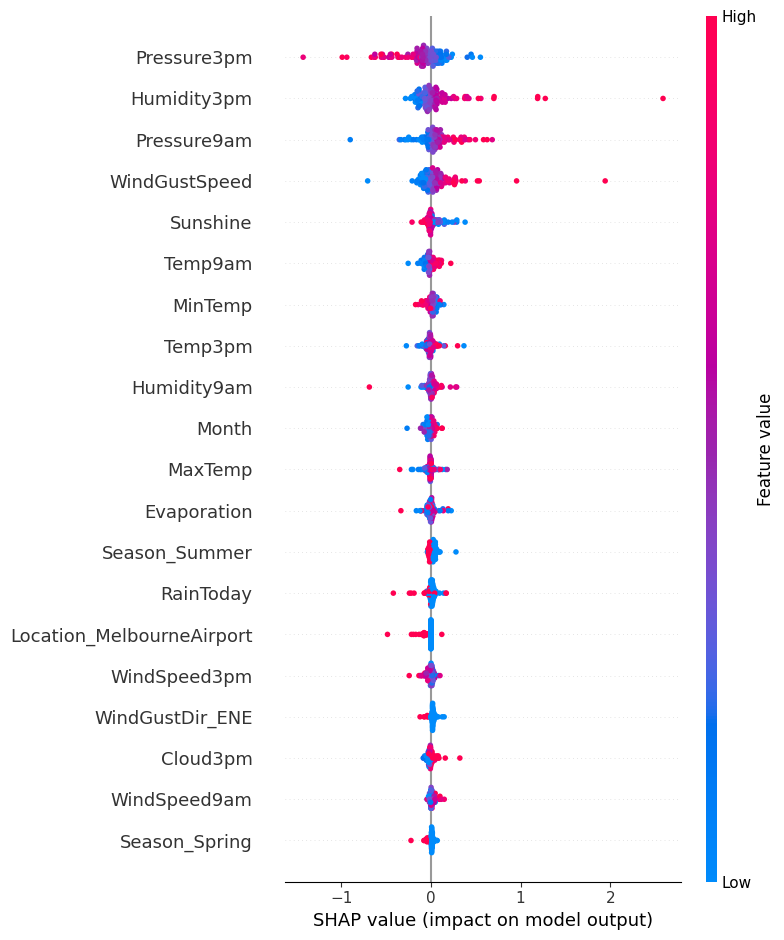

In [378]:
# Visualizar un resumen de las contribuciones de las características
shap.summary_plot(shap_values_nn, X_test.drop("RainfallTomorrow",axis=1).iloc[:120, :])

Podemos ver que cambian los graficos en comparacion con el SHAP de la regresion lineal, aca podemos ver como La presion a la tarde es mas importante que la humedad. Entonces vemos que a menor presion, mas chances hay que llueva y a mayor humedad lo mismo. Mientras que en la presion de la mañana, a mayor presion es mas probable que mas llueva.

In [379]:
shap.initjs()
shap.force_plot(explainer_kernel_nn.expected_value, shap_values_kernel_nn[0], X_test.drop("RainfallTomorrow", axis=1).iloc[:120, :])

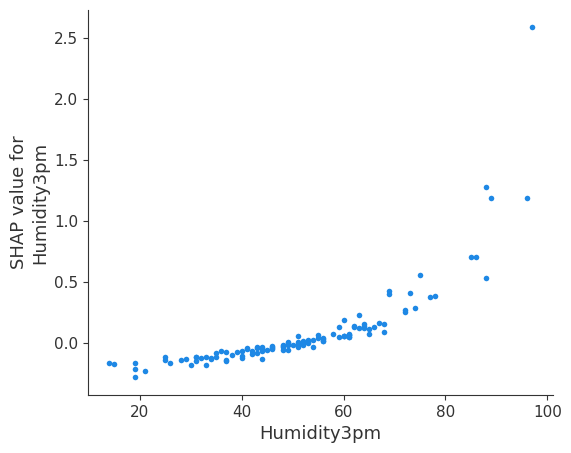

In [380]:
shap.dependence_plot('Humidity3pm', shap_values_nn, X_test.drop("RainfallTomorrow", axis=1).iloc[:120, :], interaction_index=None)

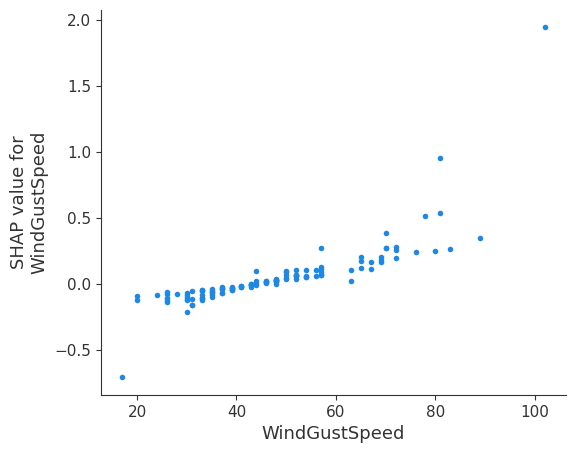

In [381]:
shap.dependence_plot('WindGustSpeed', shap_values_nn, X_test.drop("RainfallTomorrow", axis=1).iloc[:120, :], interaction_index=None)

# Produccion

1. Tenemos que crear la funcion para establecer las features que hemos conseguido y necesitan de entrada nuestro modelo

In [420]:
df_produccion=pd.read_csv("weatherAUS.csv", encoding="UTF-8")

In [382]:
def create_dummy_variables(df, column_name):
    """
    Genera variables dummy para los valores únicos en una columna categórica del DataFrame.

    Args:
    - df: DataFrame de pandas.
    - column_name: Nombre de la columna para la cual se generarán las variables dummy.

    Returns:
    - DataFrame modificado con las variables dummy.
    """
    dummies = pd.get_dummies(df[column_name], prefix=column_name, drop_first=True)

    df = pd.concat([df, dummies], axis=1)

    df.drop(column_name, axis=1, inplace=True)

    return df


In [383]:
def clean_and_transformation(df):
    ciudades=["Melbourne","MelbourneAirport","Canberra","Sydney","SydneyAirport"]
    df["Date"] = pd.to_datetime(df["Date"])
    df['Month'] = df["Date"].dt.month
    df['Season'] = df["Month"].map({1: 'Summer', 2: 'Summer', 3: 'Autumn', 4: 'Autumn', 5: 'Autumn', 6: 'Winter', 7: 'Winter', 8: 'Winter', 9: 'Spring', 10: 'Spring', 11: 'Spring', 12: 'Summer'})
    df=df.query("Location.isin(@ciudades)")
    df = create_dummy_variables(df, 'Location')
    df = create_dummy_variables(df, 'Season')
    df = create_dummy_variables(df, 'WindGustDir')
    df = create_dummy_variables(df, 'WindDir3pm')
    df = create_dummy_variables(df, 'WindDir9am')
    df['RainToday'] = df['RainToday'].replace({'Yes': 1, 'No': 0})

    return df

In [384]:
from sklearn.base import BaseEstimator, TransformerMixin

class CleanAndTransformation(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No es necesario hacer nada en fit para un transformador

    def transform(self, X):
        ciudades = ["Melbourne", "MelbourneAirport", "Canberra", "Sydney", "SydneyAirport"]
        X["Date"] = pd.to_datetime(X["Date"])
        X['Month'] = X["Date"].dt.month
        X['Season'] = X["Month"].map({1: 'Summer', 2: 'Summer', 3: 'Autumn', 4: 'Autumn', 5: 'Autumn', 6: 'Winter', 7: 'Winter', 8: 'Winter', 9: 'Spring', 10: 'Spring', 11: 'Spring', 12: 'Summer'})
        X = X.query("Location.isin(@ciudades)")
        # Supongo que create_dummy_variables es una función que crea variables dummy
        X = create_dummy_variables(X, 'Location')
        X = create_dummy_variables(X, 'Season')
        X = create_dummy_variables(X, 'WindGustDir')
        X = create_dummy_variables(X, 'WindDir3pm')
        X = create_dummy_variables(X, 'WindDir9am')
        X['RainToday'] = X['RainToday'].replace({'Yes': 1, 'No': 0})
        X= X.drop(columns=["RainTomorrow", "RainfallTomorrow", "Unnamed: 0", "Date"])
        X = X.dropna()
        return X

In [408]:

class ScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_scale):
        self.columns_to_scale = columns_to_scale
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns_to_scale])
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        X_transformed[self.columns_to_scale] = self.scaler.transform(X_transformed[self.columns_to_scale])
        print(X_transformed)  # Corregir el nombre de la variable
        return X_transformed
    
    def inverse_transform(self, X):
        X_inverse = X.copy()
        X_inverse[self.columns_to_scale] = self.scaler.inverse_transform(X_inverse[self.columns_to_scale])
        return X_inverse



In [409]:
clean_and_transform = CleanAndTransformation()
scaler_transform = ScalerTransformer(columns_to_scale=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                                                      'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                                                      'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
                                                      'Temp9am', 'Temp3pm', 'Month'])



Creamos la pipeline para poder poner en produccion al modelo.

In [410]:

pipeline2 = Pipeline([
    ('Clean and Transformation', clean_and_transform),
    ('Standard Scaler',scaler_transform),
    ('Model', model_rn1)
])

TESTING PIPELINE

In [390]:
df_produccion=pd.read_csv("weatherAUS.csv", encoding="UTF-8")

In [411]:
df_produccion_transformed = pipeline2['Clean and Transformation'].transform(df_produccion)
df_produccion_transformed = pipeline2['Standard Scaler'].fit_transform(df_produccion_transformed)
predictions_produccion = pipeline2['Model'].predict(df_produccion_transformed)

        MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
31159  0.148547 -0.231872 -0.307216    -0.598256  1.053122      -0.530866   
31160  0.222823 -0.031762 -0.340085     0.572935  1.079136      -0.265301   
31161  0.594204  0.218374 -0.340085     0.247605  1.079136      -0.265301   
31165  0.148547  0.835379 -0.307216    -0.337991  1.365285      -0.796431   
31166  0.501359  0.351781 -0.340085     0.638001  0.714945       0.597786   
...         ...       ...       ...          ...       ...            ...   
70366 -1.058441 -0.982283 -0.340085    -0.793454  0.506836      -0.398083   
70367 -0.798474 -1.365826 -0.241477    -1.379050 -1.782360      -1.393953   
70368 -1.002734 -1.265771 -0.307216    -1.379050 -1.782360      -1.393953   
70369 -0.872751 -1.132365 -0.340085    -1.053719 -0.221544      -0.066127   
70370 -0.705629 -1.565935 -0.110000    -0.988653 -0.325599      -0.995605   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
31159  

In [412]:
predictions_produccion = pipeline2['Model'].predict(df_produccion_transformed)

 44/338 [==>...........................] - ETA: 0s

338/338 [==============================] - 0s 1ms/step


In [413]:
predictions_produccion


array([[-0.4311487 ],
       [-0.48431396],
       [-0.38755253],
       ...,
       [-0.45499378],
       [-0.35534233],
       [-0.43464524]], dtype=float32)

In [414]:


joblib.dump(pipeline2, 'redes_regresion_tp.joblib')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...metrics\mean
......vars
.........0
.........1
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-12-02 19:45:13         2807
metadata.json                                  2023-12-02 19:45:13           64
variables.h5                                   2023-12-02 19:45:13       103944


['redes_regresion_tp.joblib']

PipeLine para el modelo de clasificacion

In [387]:
best_optuna_model_log

LogisticRegression(C=0.06358822554928491, max_iter=450, penalty='l1',
                   solver='liblinear')

In [388]:
pipeline3 = Pipeline([
    ('Clean and Transformation', clean_and_transform),
    ('Standard Scaler',scaler_transform),
    ('Model', best_optuna_model_log)
])

In [395]:
df_produccion_transformed_log = pipeline3['Clean and Transformation'].transform(df_produccion)
df_produccion_transformed_log = pipeline3['Standard Scaler'].fit_transform(df_produccion_transformed_log)
predictions_produccion_log = pipeline3['Model'].predict(df_produccion_transformed_log)

        MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
31159  0.148547 -0.231872 -0.307216    -0.598256  1.053122      -0.530866   
31160  0.222823 -0.031762 -0.340085     0.572935  1.079136      -0.265301   
31161  0.594204  0.218374 -0.340085     0.247605  1.079136      -0.265301   
31165  0.148547  0.835379 -0.307216    -0.337991  1.365285      -0.796431   
31166  0.501359  0.351781 -0.340085     0.638001  0.714945       0.597786   
...         ...       ...       ...          ...       ...            ...   
70366 -1.058441 -0.982283 -0.340085    -0.793454  0.506836      -0.398083   
70367 -0.798474 -1.365826 -0.241477    -1.379050 -1.782360      -1.393953   
70368 -1.002734 -1.265771 -0.307216    -1.379050 -1.782360      -1.393953   
70369 -0.872751 -1.132365 -0.340085    -1.053719 -0.221544      -0.066127   
70370 -0.705629 -1.565935 -0.110000    -0.988653 -0.325599      -0.995605   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
31159  

In [399]:
predictions_produccion_log

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [400]:
joblib.dump(pipeline3, 'regresion_logistica_tp.joblib')

['regresion_logistica_tp.joblib']

# Conclusion Final

Como conclusion final del trabajo podemos decir que es muy dificil poder predecir cuanto llovera mañana, claramente esto se debe a que la cantidad de variables que hay que tener en cuanto son muchas y que a pesar de que usemos las tecnicas de machine learning, como de deep learning que son muy buenas, el modelaje de un tipo de problema climatico es algo muy profesional. Pero algo que si podemos determinar con una mayor precision es si va a llover o no, claramente existe una mayor facilidad a la hora de predecir cuestiones binarias, o sea problemas de clasificacion mientras que los problemas de regresion son mas dificiles de poder medir con una exactitud la cual podremos estar tranquilos. 

Pero mas alla de esto, esta metodologia de trabajo de un TP que sea toda la materia creo que fue muy buena porque en la industria si no estoy equivocado se trabaja de esta manera, con proyectos que duran meses en realizarse. 

Dicho esto y volviendo a lo anterior, los metodos utilizados han dado sus frutos y hemos logrado poder predecir al menos con una exactitud importante si al otro dia llovera o no. 

Para terminar la justificaciones. Aclaramos que los modelos que elegimos en el caso de la regresion logistica para comparar el rendimiento usamos la metrica de F1 tanto para positivos como negativos ya que podría ser bueno considerar una métrica que tenga en cuenta tanto la precisión como el recall. Como podemos observar nuestra regresion logistica es mejor prediciendo los dias que no va a llover que los que si llovera. Teniendo en cuenta esta consideracion obteniendo la mejor arquitectura de red neuronal y los mejores hiperparametros consideramos utilizar el modelo "best_optuna_model_log" para produccion

Continuando con el modelo para regresion, tomamos en cuenta para comparar los mismos el r2 ya que esta metrica tiene en cuenta el error general del modelo sin penalizar tanto los valores anomalos. Por lo cual nos parece que es la metrica mas adecuada para este tipo de problema. Teniendo en cuenta esta consideracion obteniendo la mejor arquitectura de red neuronal y los mejores hiperparametros consideramos utilizar el modelo "model_rn1" para produccion